In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # Display any number of columns
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

import matplotlib as mpl # Additional plotting functionality
mpl.rcParams['figure.dpi'] = 400 # High resolution figures

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore") 

from scipy.stats import ks_2samp

# 1. Introduction
  The goal is to use the loan data to build a model that can predict the loan status (whether or not a loan will be fully paid 
  or charged off) and interpret the results to find the factors which affect the result. 

# 2. Data

  We are using the Lending Club data that is available on [Kaggle] 
  (https://www.kaggle.com/wordsforthewise/lending-club). 
  
  The dataset contains loans from 2007 to 2018Q4 with 151 associated features.
 # 3. Data Dictionary
  This Dataset has definitions for all the features that are present in the main dataset.
     

In [2]:
df = pd.read_csv('input/accepted_2007_to_2018Q4.csv.gz',compression='gzip',low_memory=True)
dict_df = pd.read_csv('input\LCDataDictionary.csv')

In [3]:
dict_df.columns

Index(['LoanStatNew', 'Description', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10'],
      dtype='object')

In [4]:
dict_df = dict_df[dict_df.columns[:2]]
dict_df.set_index('LoanStatNew', inplace=True)
dict_df.head()

Description
LoanStatNew                                                                                        
acc_now_delinq                      The number of accounts on which the borrower is now delinquent.
acc_open_past_24mths                                     Number of trades opened in past 24 months.
addr_state                               The state provided by the borrower in the loan application
all_util                                                      Balance to credit limit on all trades
annual_inc            The self-reported annual income provided by the borrower during registration.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [6]:
df.sample(5)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
1496018  135527178        nan   20000.00     20000.00         20000.00   
777423   139959516        nan   40000.00     40000.00         40000.00   
760326   140730327        nan    3900.00      3900.00          3900.00   
1178520   29373891        nan    6000.00      6000.00          6000.00   
2150451  120253598        nan   24325.00     24325.00         24325.00   

               term  int_rate  installment grade sub_grade  \
1496018   36 months     10.07       646.01     B        B2   
777423    60 months     10.47       859.17     B        B2   
760326    36 months     11.55       128.70     B        B4   
1178520   36 months      9.17       191.28     B        B1   
2150451   60 months     15.05       579.33     C        C4   

                                        emp_title emp_length home_ownership  \
1496018                             Hotel manager    5 years           RENT   
777423                             Master Plumber  10+ years            OWN   
760326   Patient Financial Service Representative    6 years           RENT   
1178520                         Deputy Prosecutor    2 years           RENT   
2150451                Healthcare Account Manager    2 years       MORTGAGE   

         annual_inc verification_status   issue_d loan_status pymnt_plan  \
1496018   582000.00     Source Verified  Jun-2018     Current          n   
777423    180000.00     Source Verified  Sep-2018     Current          n   
760326     35000.00        Not Verified  Sep-2018     Current          n   
1178520    52000.00     Source Verified  Oct-2014  Fully Paid          n   
2150451   130000.00        Not Verified  Oct-2017     Current          n   

                                                                        url  \
1496018  https://lendingclub.com/browse/loanDetail.action?loan_id=135527178   
777423   https://lendingclub.com/browse/loanDetail.action?loan_id=139959516   
760326   https://lendingclub.com/browse/loanDetail.action?loan_id=140730327   
1178520   https://lendingclub.com/browse/loanDetail.action?loan_id=29373891   
2150451  https://lendingclub.com/browse/loanDetail.action?loan_id=120253598   

        desc             purpose                    title zip_code addr_state  \
1496018  NaN  debt_consolidation       Debt consolidation    891xx         NV   
777423   NaN         credit_card  Credit card refinancing    221xx         VA   
760326   NaN         credit_card  Credit card refinancing    908xx         CA   
1178520  NaN  debt_consolidation       Debt consolidation    591xx         MT   
2150451  NaN  debt_consolidation       Debt consolidation    486xx         MI   

          dti  delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
1496018  1.71         0.00         Jan-2014          690.00           694.00   
777423  13.19         1.00         Jan-1994          695.00           699.00   
760326  14.71         1.00         Feb-2005          670.00           674.00   
1178520 32.52         0.00         Apr-2001          660.00           664.00   
2150451 23.18         0.00         Feb-2006          690.00           694.00   

         inq_last_6mths  mths_since_last_delinq  mths_since_last_record  \
1496018            0.00                     nan                     nan   
777423             0.00                   11.00                     nan   
760326             0.00                   20.00                     nan   
1178520            0.00                     nan                     nan   
2150451            0.00                   28.00                     nan   

         open_acc  pub_rec  revol_bal  revol_util  total_acc  \
1496018      8.00     0.00   12776.00       46.30       8.00   
777423      13.00     0.00   42892.00       69.50      32.00   
760326       4.00     0.00    5942.00       87.40      22.00   
1178520     18.00     0.00   15573.00       37.50      26.00   
2150451     14.00     0.00   19407.00       73.20   

# 3. Identify the target Variable
As we are trying find out if a loan will be fully paid or charged off. Use the loan_status as target variable

In [7]:
df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

Our focus is only on the loans that are fully paid or charged off. We will consider only the rows with loan_status being "fully paid" or "charged off"

In [8]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]
df['loan_status'].value_counts(normalize=False, dropna=False)

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

In [9]:
df['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid    0.80
Charged Off   0.20
Name: loan_status, dtype: float64

80% (1.08M) of the loans have been fully paid, and about 20% (268k) have been charged off. 

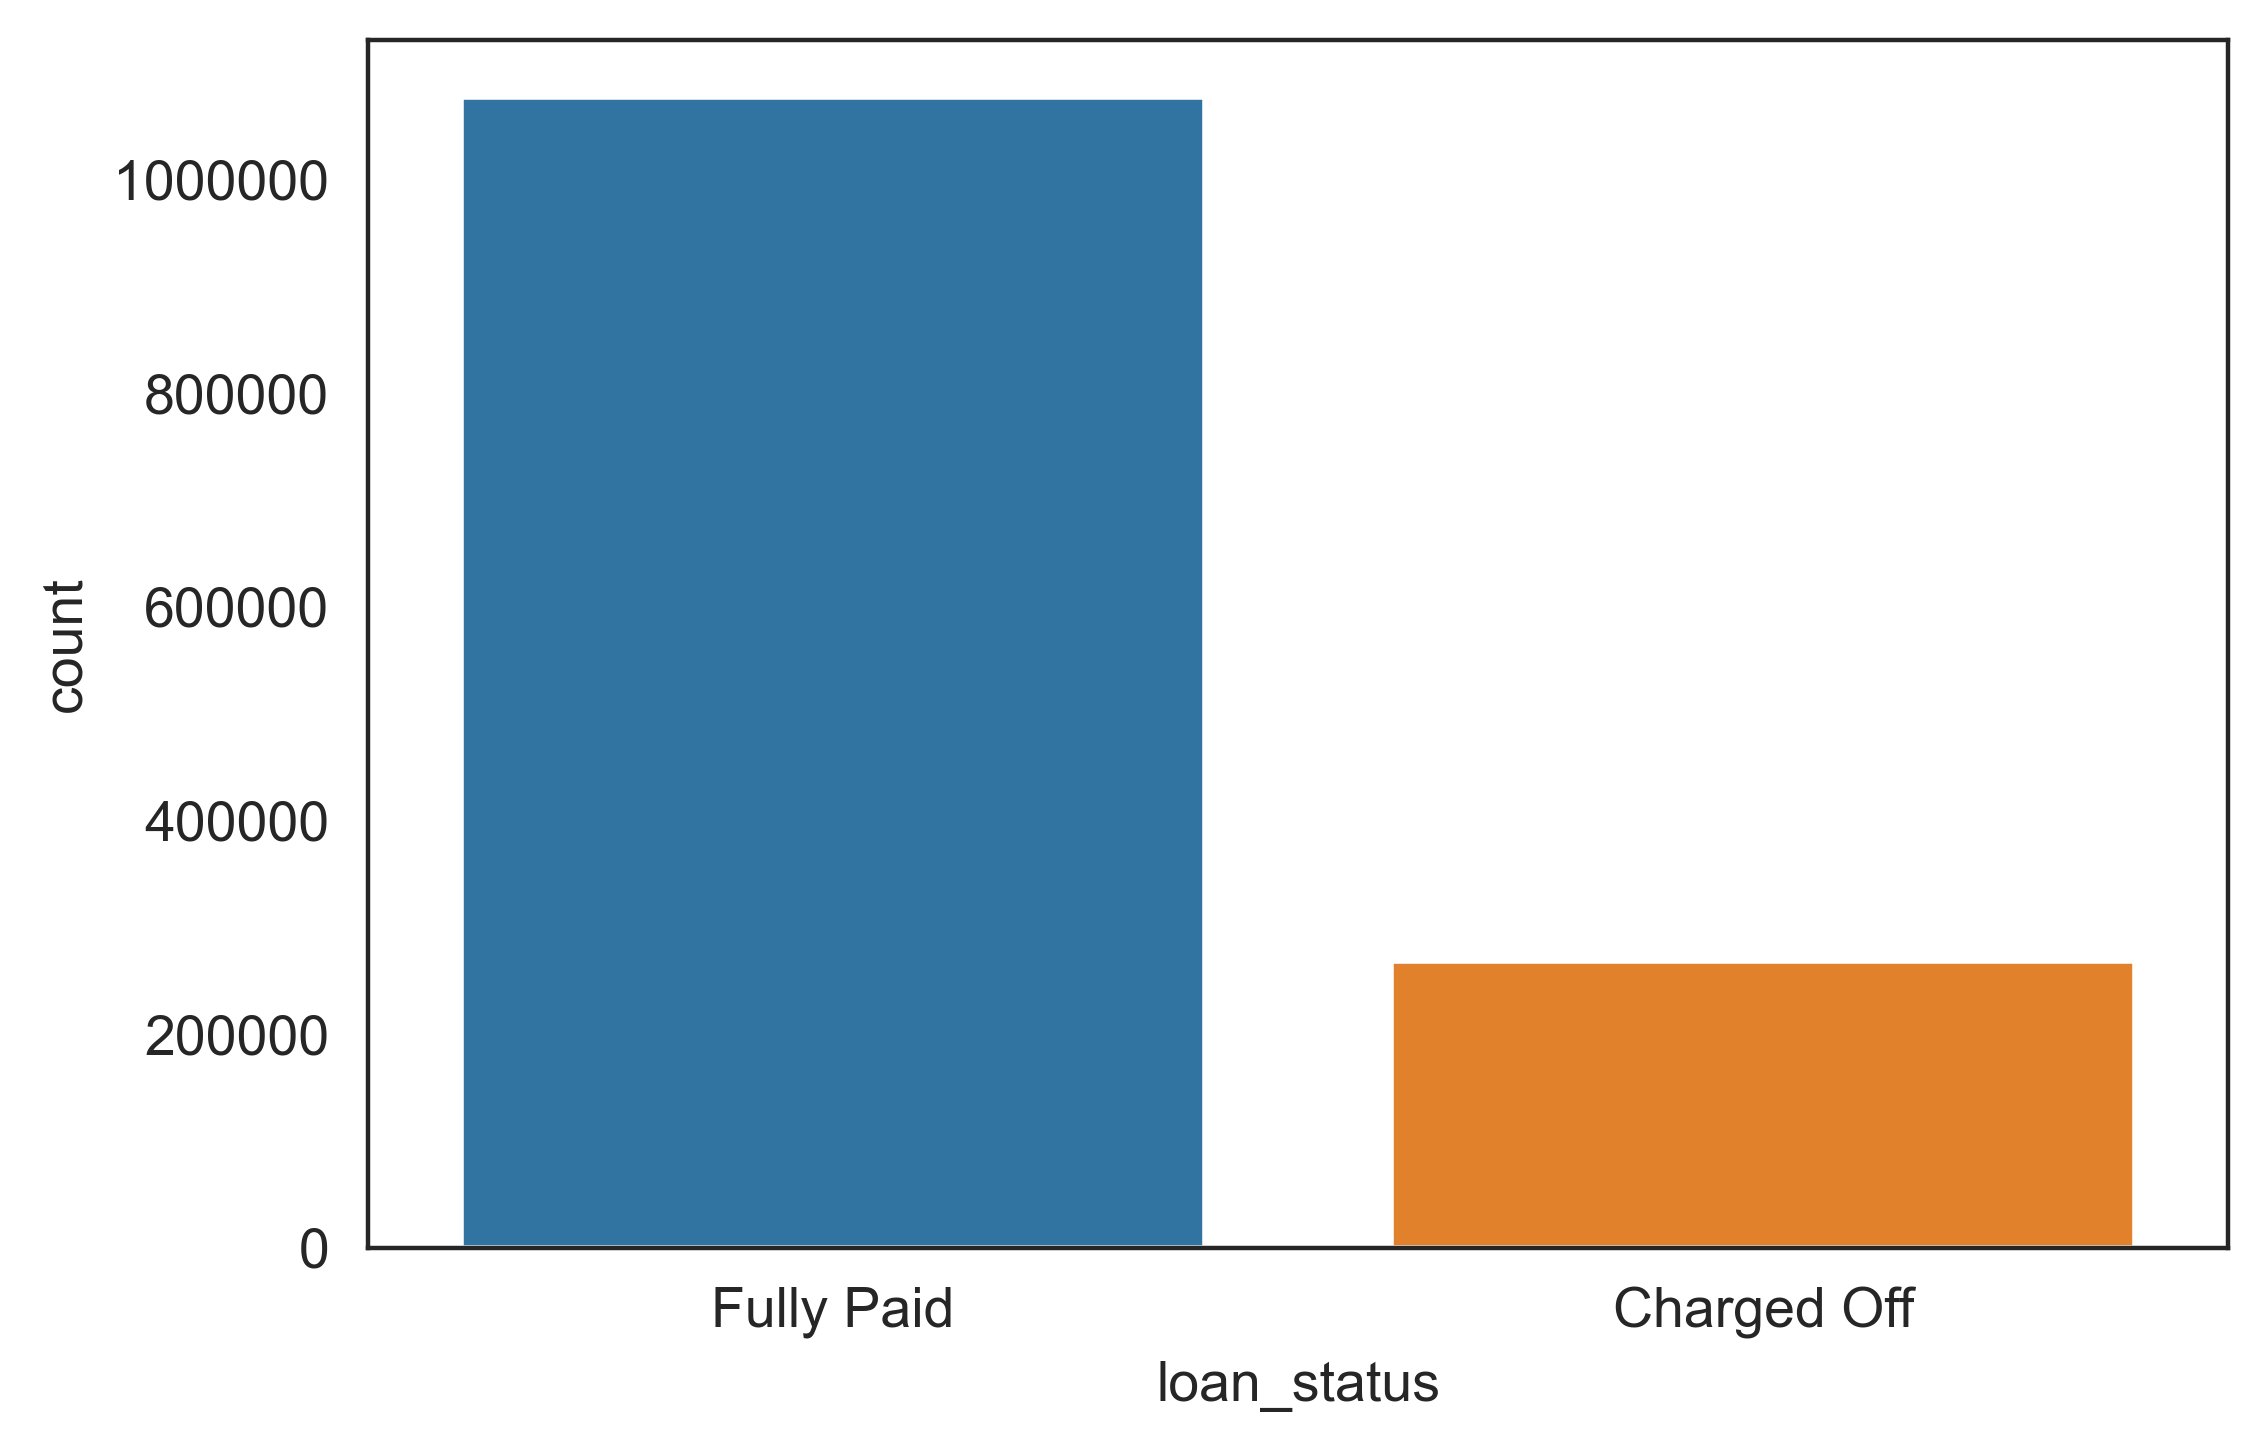

In [10]:
sns.countplot(x='loan_status',data=df)
plt.ticklabel_format(style='plain', axis='y')

This data is clearly imbalanced data. There are lot more instances of fully paid loans than charged off loans. But it is quite natual to have less number of charged off loans.

# 4. Feature Selection - EDA
- We will evaulare individual features in this section
- Identify the features with missing data
- Drop the features with if they are missing data above 50%
- Also Drop the features that do not add valye in building model.

In [11]:
# Create a function to dispaly the features with missing values, and % of total values, & datatype
def nan_table(df):
     # Total number of missing values
    nan_val = df.isnull().sum()
    # Percentage of missing values
    nan_val_percent = 100 * df.isnull().sum() / len(df)
    nan_val_type = df.dtypes
    # Create a table with the results
    nan_val_table = pd.concat([nan_val, nan_val_percent, nan_val_type], axis=1)
        
     # Rename the columns to have a meaningful name
    nan_val_table_ren_columns = nan_val_table.rename(columns = {0 : 'NaN Values Count', 1 : 'NaN Values %', 2: 'Type'})
        
    # Sort the table by percentage of missing in descending order
    nan_val_table_ren_columns = nan_val_table_ren_columns[nan_val_table_ren_columns.iloc[:,1] != 0].sort_values('NaN Values %', ascending=False).round(1)
        
    # Print summary 
    print("Input file has " + str(df.shape[1]) + " columns")
    print("There are " + str(nan_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return nan_val_table_ren_columns

In [12]:
nan_table(df)

Input file has 151 columns
There are 105 columns that have missing values.


NaN Values Count  NaN Values %  \
member_id                                            1345310        100.00   
next_pymnt_d                                         1345310        100.00   
orig_projected_additional_accrued_interest           1341551         99.70   
hardship_type                                        1339556         99.60   
hardship_reason                                      1339556         99.60   
hardship_status                                      1339556         99.60   
deferral_term                                        1339556         99.60   
hardship_amount                                      1339556         99.60   
hardship_start_date                                  1339556         99.60   
hardship_end_date                                    1339556         99.60   
payment_plan_start_date                              1339556         99.60   
hardship_length                                      1339556         99.60   
hardship_dpd                                         1339556         99.60   
hardship_loan_status                                 1339556         99.60   
hardship_payoff_balance_amount                       1339556         99.60   
hardship_last_payment_amount                         1339556         99.60   
sec_app_mths_since_last_major_derog                  1338665         99.50   
sec_app_revol_util                                   1327008         98.60   
revol_bal_joint                                      1326681         98.60   
sec_app_chargeoff_within_12_mths                     1326680         98.60   
sec_app_open_act_il                                  1326680         98.60   
sec_app_open_acc                                     1326680         98.60   
sec_app_mort_acc                                     1326680         98.60   
sec_app_inq_last_6mths                               1326680         98.60   
sec_app_earliest_cr_line                             1326680         98.60   
sec_app_fico_range_high                              1326680         98.60   
sec_app_num_rev_accts                                1326680         98.60   
sec_app_fico_range_low                               1326680         98.60   
sec_app_collections_12_mths_ex_med                   1326680         98.60   
verification_status_joint                            1319715         98.10   
dti_joint                                            1319513         98.10   
annual_inc_joint                                     1319510         98.10   
debt_settlement_flag_date                            1312034         97.50   
settlement_status                                    1312034         97.50   
settlement_date                                      1312034         97.50   
settlement_amount                                    1312034         97.50   
settlement_percentage                                1312034         97.50   
settlement_term                                      1312034         97.50   
desc                                                 1221778         90.80   
mths_since_last_record                               1116755         83.00   
mths_since_recent_bc_dlq                             1026290         76.30   
mths_since_last_major_derog                           991560         73.70   
mths_since_recent_revol_delinq                        895348         66.60   
il_util                                               880294         65.40   
mths_since_rcnt_il                                    821928         61.10   
all_util                                              807765         60.00   
open_acc_6m                                           807713         60.00   
inq_last_12m                                          807713         60.00   
total_cu_tl                                           807713         60.00   
open_rv_12m                                           807712         60.00   
open_il_12m                                           807712      

Based on the above counts it is evident that there is a considerable gap between feature missing some data (about 13% and below) and those with missing a lot of data (upto 100% missing data). So we will discard the features that are missing 50% or above data.

In [13]:
missing_proportion = df.isnull().mean()
drop_list = sorted(missing_proportion[missing_proportion > 0.50].index)

In [14]:
print(drop_list)
print('\n')
print('Number of columns to be dropped: ', len(drop_list))

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

Create a function to drop the columns from the dataset

In [15]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

In [16]:
drop_cols(drop_list)
df.shape

(1345310, 93)

As our goal is to predict whether a loan will be paid off or not before approving the loan. Therefore, drop the features that are unavailable before approving a loan.

In [17]:
print(sorted(df.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

After reviewing the data dictionary for each feature, below columns are identified as the columns that are not availble before approving the loan.

In [18]:
# dict_df

In [19]:
discard_cols = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
             'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 
             'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 
             'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 
             'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
             'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 
             'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 
             'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  'out_prncp', 'out_prncp_inv', 
             'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 
             'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 
             'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']

In [20]:
drop_cols(discard_cols)

In [21]:
print(sorted(df.columns))
print('\n')
print('Remaining columns that need further review: ', len(df.columns))

['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'open_acc', 'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'url', 'verification_status', 'zip_code']


Remaining columns that need further review:  35


#### Let's  evaluate the remaining features and decide whether to keep them or drop them off 

In [22]:
df['id'].nunique()

1345310

In [23]:
print(dict_df.loc['zip_code'])
print(dict_df.loc['emp_title'])
print(dict_df.loc['purpose'])
print(dict_df.loc['title'])
print(dict_df.loc['url'])

Description    The first 3 numbers of the zip code provided by the borrower in the loan application.
Name: zip_code, dtype: object
Description    The job title supplied by the Borrower when applying for the loan.*
Name: emp_title, dtype: object
Description    A category provided by the borrower for the loan request. 
Name: purpose, dtype: object
Description    The loan title provided by the borrower
Name: title, dtype: object
Description    URL for the LC page with listing data.
Name: url, dtype: object


In [24]:
df['emp_title'].nunique()

378353

In [25]:
print(df['purpose'].value_counts())
print(df['purpose'].nunique())

debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving                  9480
vacation                9065
house                   7253
wedding                 2294
renewable_energy         933
educational              326
Name: purpose, dtype: int64
14


In [26]:
print(df['title'].nunique())

61682


In [27]:
df['title'].value_counts().head(10)

Debt consolidation         660960
Credit card refinancing    249910
Home improvement            75073
Other                       66778
Major purchase              24045
Debt Consolidation          15695
Medical expenses            13576
Business                    11750
Car financing               11220
Vacation                     8046
Name: title, dtype: int64

There is no difference between the features 'purpose' and 'title'. So we will drop title. In addition to this we can also drop id, emp_title, zip_code, and url features too. 

In [28]:
drop_feat = ['id', 'title', 'zip_code', 'emp_title', 'url']
drop_cols(drop_feat)

#### Let's create a function for generating plots to evaulate the relation between the target varaible and different features

In [29]:
def plot_func(col_name, title, continuous):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    
    # plot1: counts distribution of the variable    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#050df7', saturation=1, ax=ax1)
    ax1.set_xlabel(title)
    ax1.set_ylabel('Count')
    ax1.ticklabel_format(style='plain', axis='y')
    ax1.set_title(title)

          
    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df)
        ax2.set_ylabel('')
        ax2.set_title(title + ' by Loan Status')
    else:
        Charged_Off_rates = df.groupby(col_name)['loan_status'].value_counts(normalize=True)[:,'Charged Off']
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#fc5305', saturation=1)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charged Off Rate by ' + title)
        ax2.set_xlabel(title)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'loan_status', height=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='loan_status', data=df, order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()

## Evaluate the remaining features one by one
- In this section we will evaluate all the features, decide whether to keep them or drop them
- Perform Formatting and Cleaning
- Transform the features when it is needed

### 1. Loan amount 

In [30]:
df['loan_amnt'].describe()

count   1345310.00
mean      14419.97
std        8717.05
min         500.00
25%        8000.00
50%       12000.00
75%       20000.00
max       40000.00
Name: loan_amnt, dtype: float64

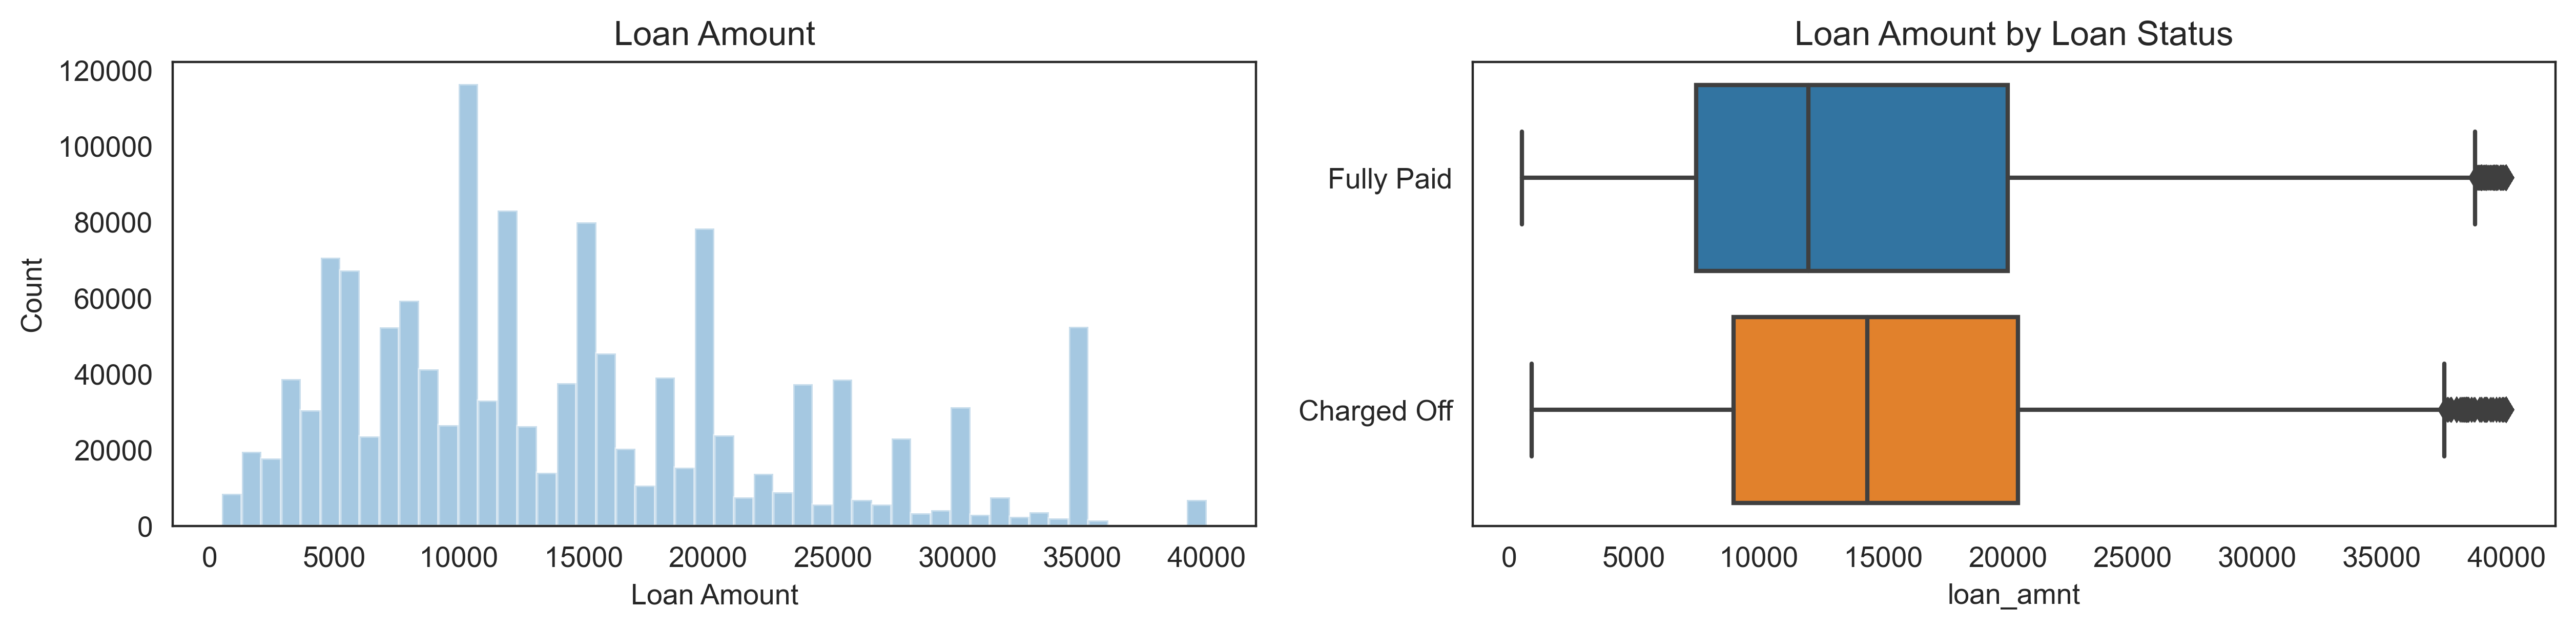

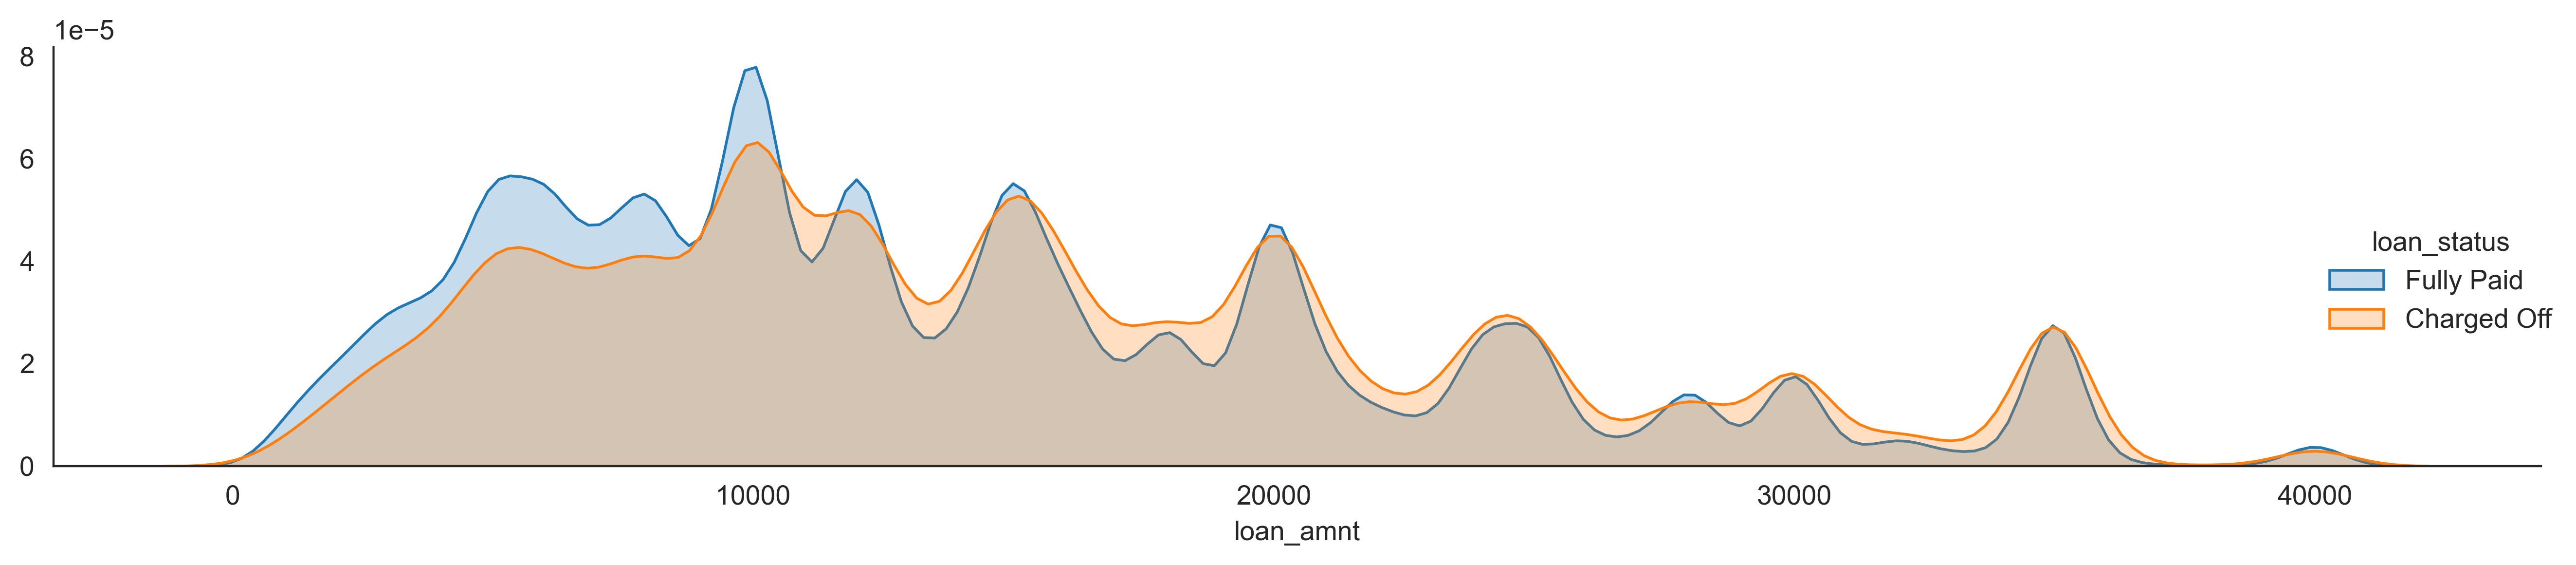

In [31]:
plot_func('loan_amnt', 'Loan Amount', continuous=True)

### 2. Loan Term

In [32]:
print(dict_df.loc['term'])
df['term'].value_counts(dropna=False)

Description    The number of payments on the loan. Values are in months and can be either 36 or 60.
Name: term, dtype: object


 36 months    1020743
 60 months     324567
Name: term, dtype: int64

In [33]:
df['term'] = df['term'].apply(lambda s: np.int8(s.split()[0]))

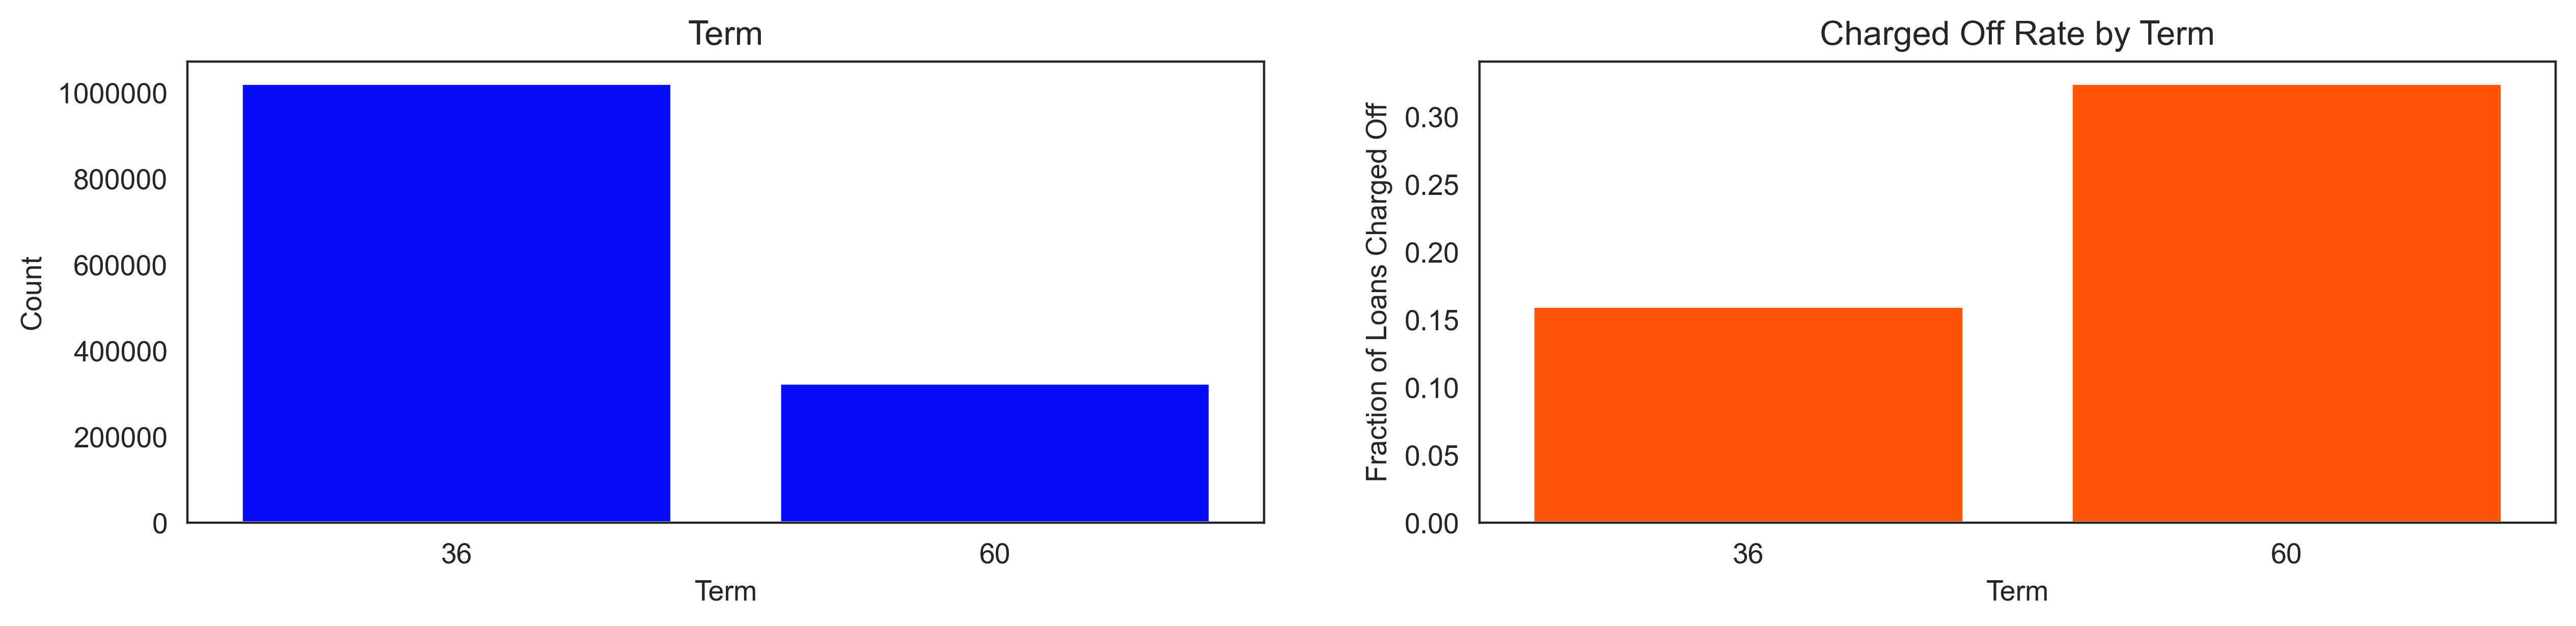

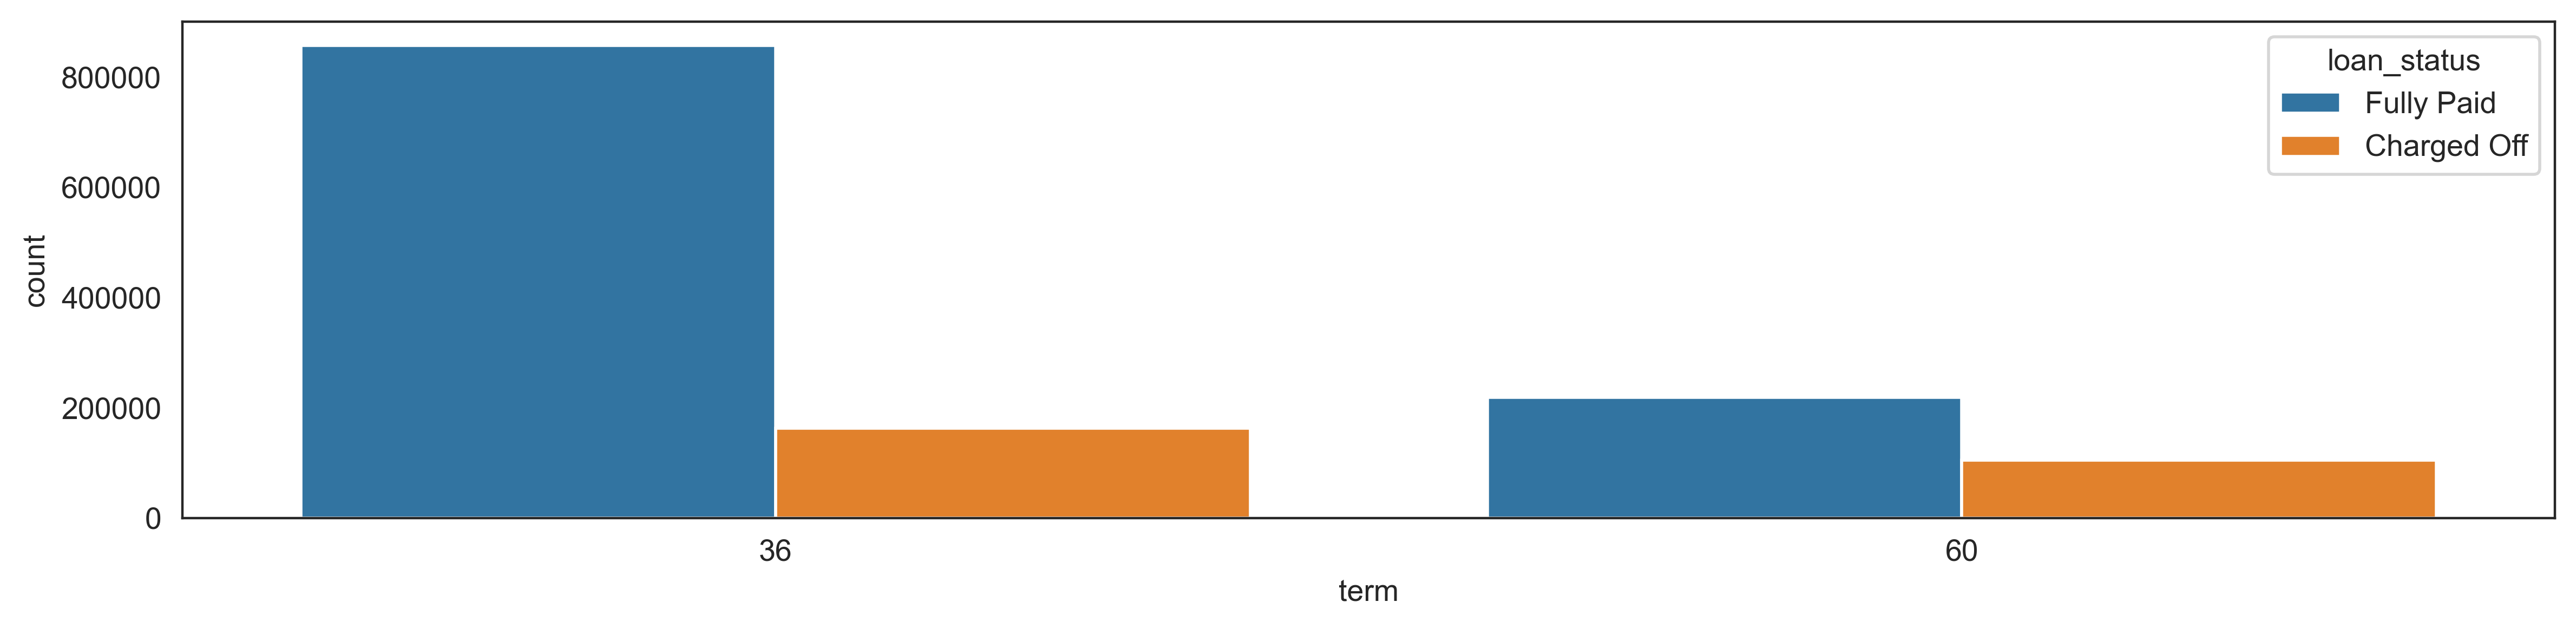

In [34]:
plot_func('term', 'Term', continuous=False)

In [35]:
df['term'].value_counts(normalize=True)

36   0.76
60   0.24
Name: term, dtype: float64

Almost 76% are short term(36 months) loans and the rest are long term(60 months).

Compare the charge-off rate by loan term.

In [36]:
df.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36   0.16
60   0.32
Name: loan_status, dtype: float64

It appears that long term loans are at higher risk than short term. As we can see there are about 16% short term loans charged off vs 32.4% long term loans charged off.

### 3. Interest Rate

In [37]:
df['int_rate'].describe()

count   1345310.00
mean         13.24
std           4.77
min           5.31
25%           9.75
50%          12.74
75%          15.99
max          30.99
Name: int_rate, dtype: float64

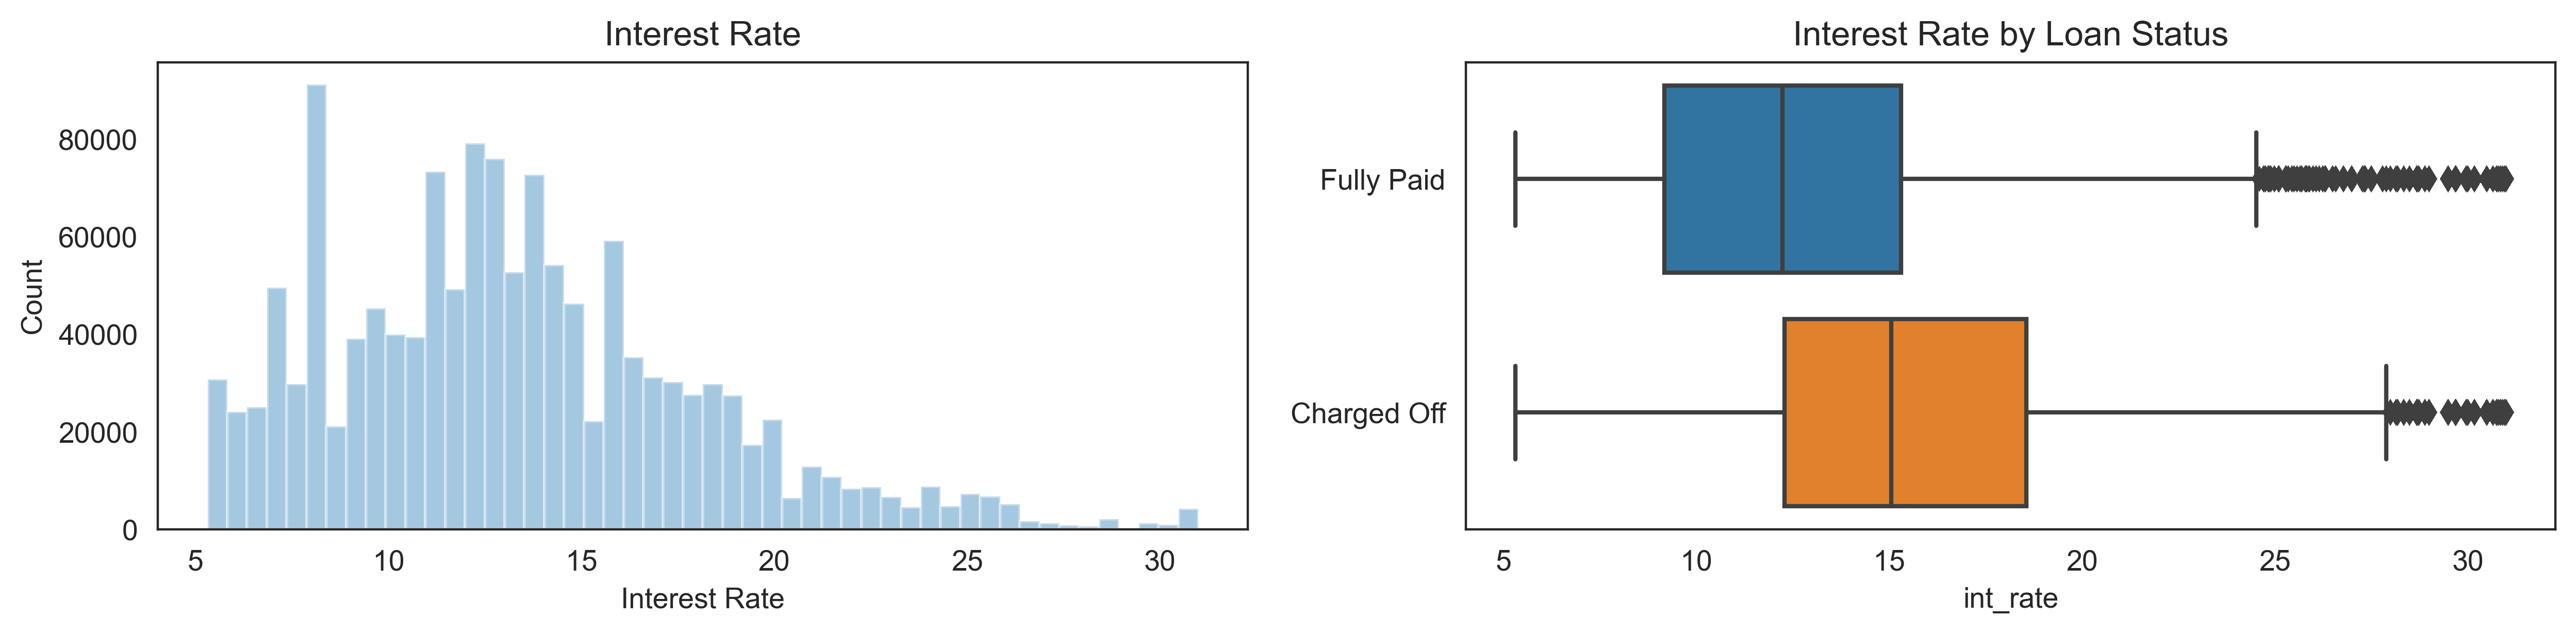

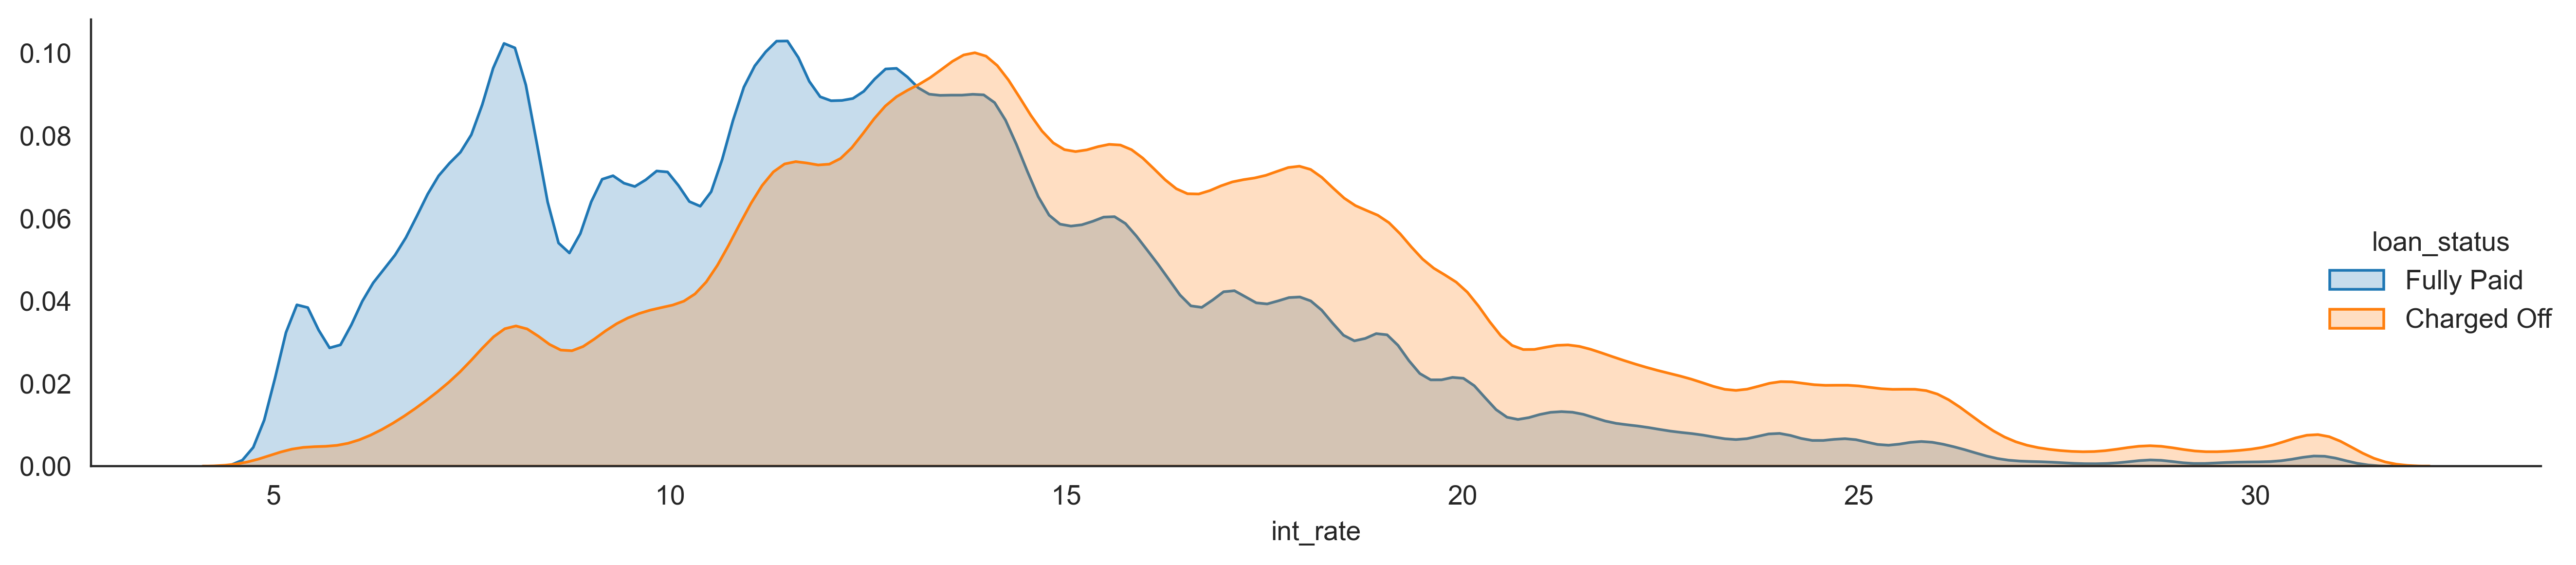

In [38]:
plot_func('int_rate', 'Interest Rate', continuous=True)

The higher the interest rate is, the more likely for being charged off. There are several outliers in the Fully Paid loans.
Let's find out the percentage of these outliers before evaluating a new feature.

In [39]:
df.groupby('loan_status')['int_rate'].describe()

count  mean  std  min   25%   50%   75%   max
loan_status                                                   
Charged Off  268559.00 15.71 4.91 5.31 12.29 15.05 18.55 30.99
Fully Paid  1076751.00 12.62 4.53 5.31  9.17 12.23 15.31 30.99

Values > 75% percentile (18.5 for "charged off", 15.3 for "Fully Paid") are defined as outliers.

Total number of loans that are fully paid with higher interest rate

In [40]:
df.loc[(df.int_rate > 15.31) & (df.loan_status == 'Fully Paid')].shape[0]

259266

Percentage of loans fully paid with higher interest rate

In [41]:
(round((df.loc[(df.int_rate > 15.31) & (df.loan_status == 'Fully Paid')].shape[0])/df['loan_status'] 
                                                                  .value_counts(normalize=False, dropna=False),2)[0])

0.24

Percentage of loans charged off with higher interest rate

In [42]:
(round(df.loc[(df.int_rate >18.55) & (df.loan_status == 'Charged Off')].shape[0]/df['loan_status']
                                                                 .value_counts(normalize=False, dropna=False),2)[1])

0.25

The percentage of outliers is roughly the same for the Fully Paid/Charged off data, ~24%.

### 4. Monthly Installment

In [43]:
df['installment'].describe()

count   1345310.00
mean        438.08
std         261.51
min           4.93
25%         248.48
50%         375.43
75%         580.73
max        1719.83
Name: installment, dtype: float64

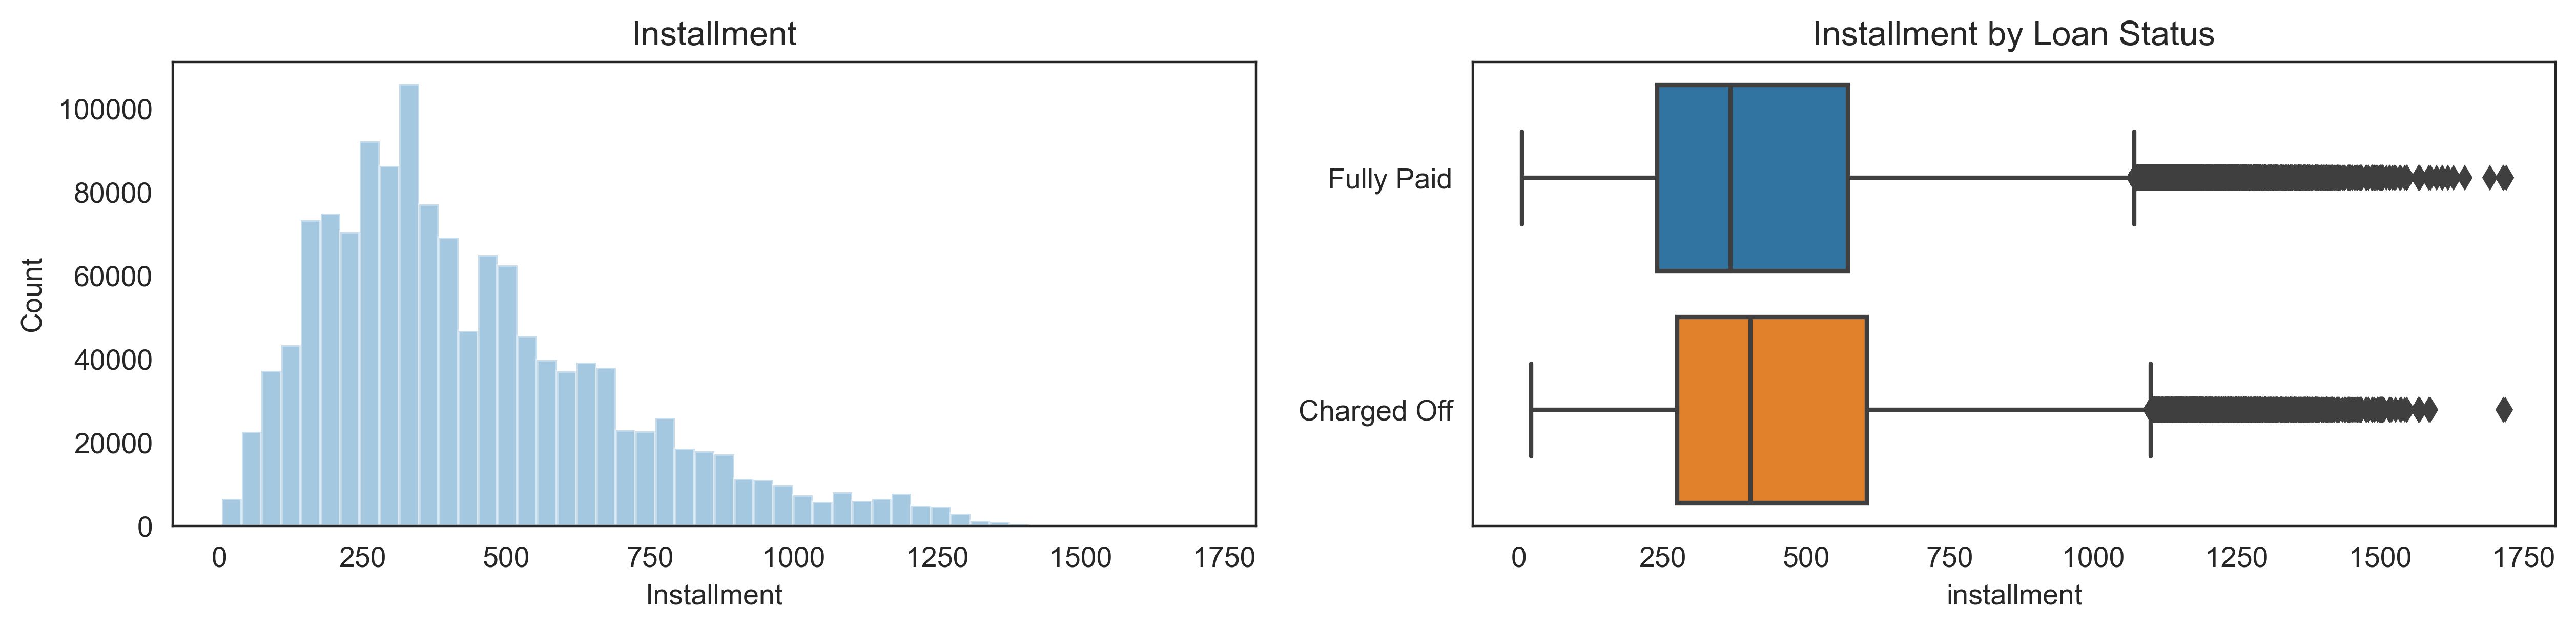

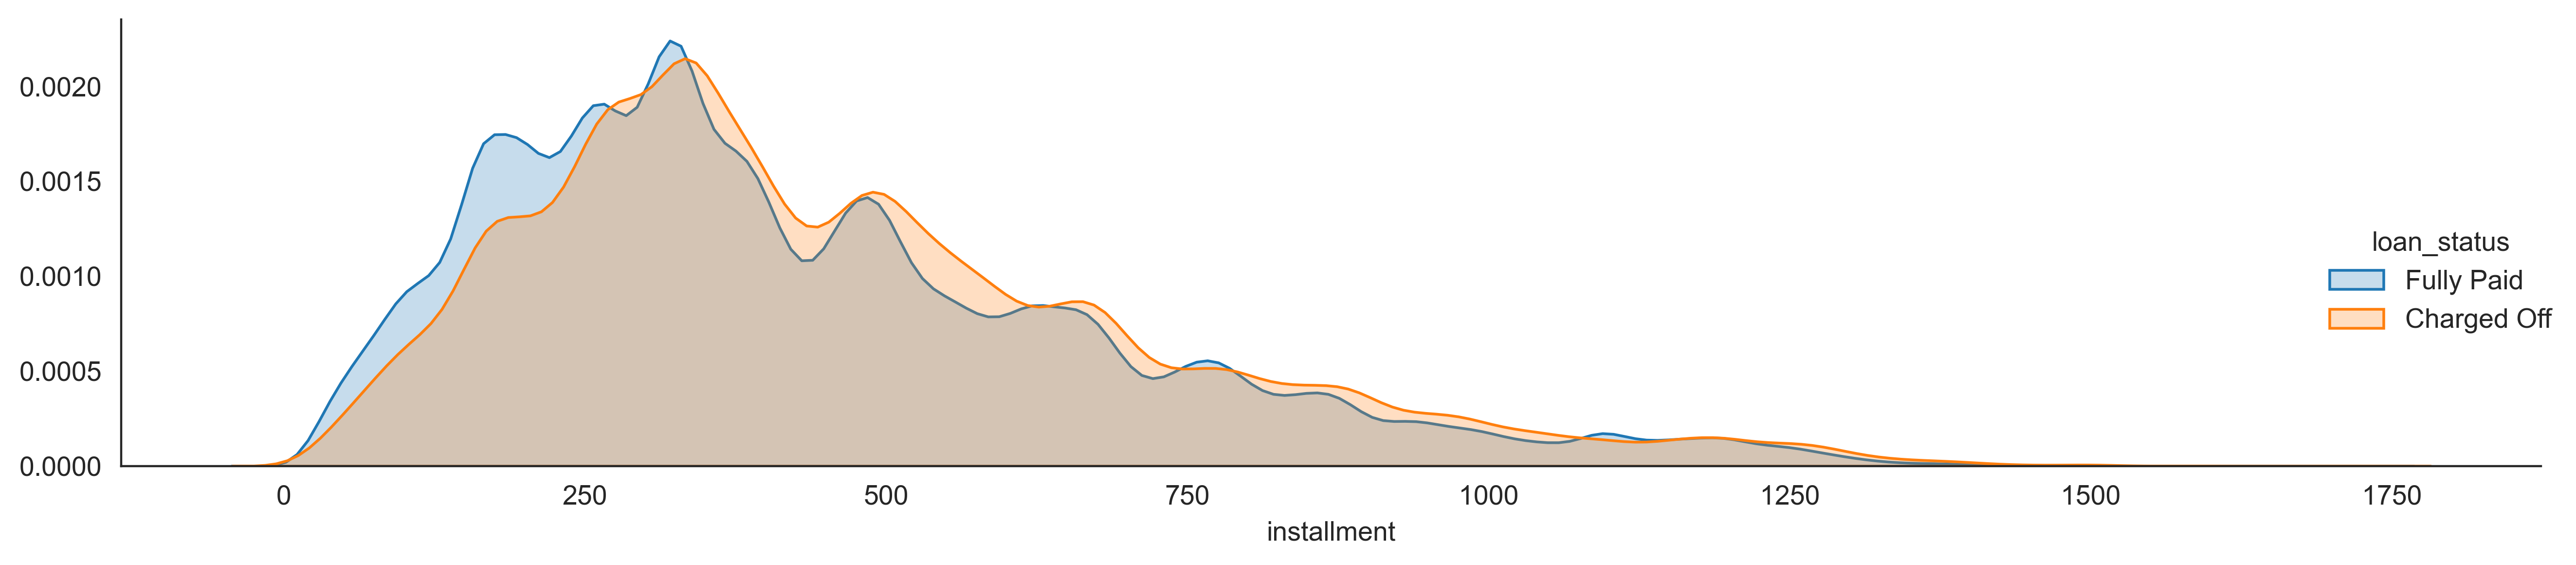

In [44]:
plot_func('installment', 'Installment', continuous=True)

In [45]:
df.groupby('loan_status')['installment'].describe()

count   mean    std   min    25%    50%    75%     max
loan_status                                                            
Charged Off  268559.00 465.15 262.77 21.62 275.29 402.83 605.31 1717.63
Fully Paid  1076751.00 431.32 260.76  4.93 240.92 368.26 573.06 1719.83

Charged-off loans tend to have higher installments but the difference of the mean values is very small (465 vs 431).

### 5. Grade Vs. Subgrade

In [46]:
sorted(df['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [47]:
print(sorted(df['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


<AxesSubplot:xlabel='grade', ylabel='count'>

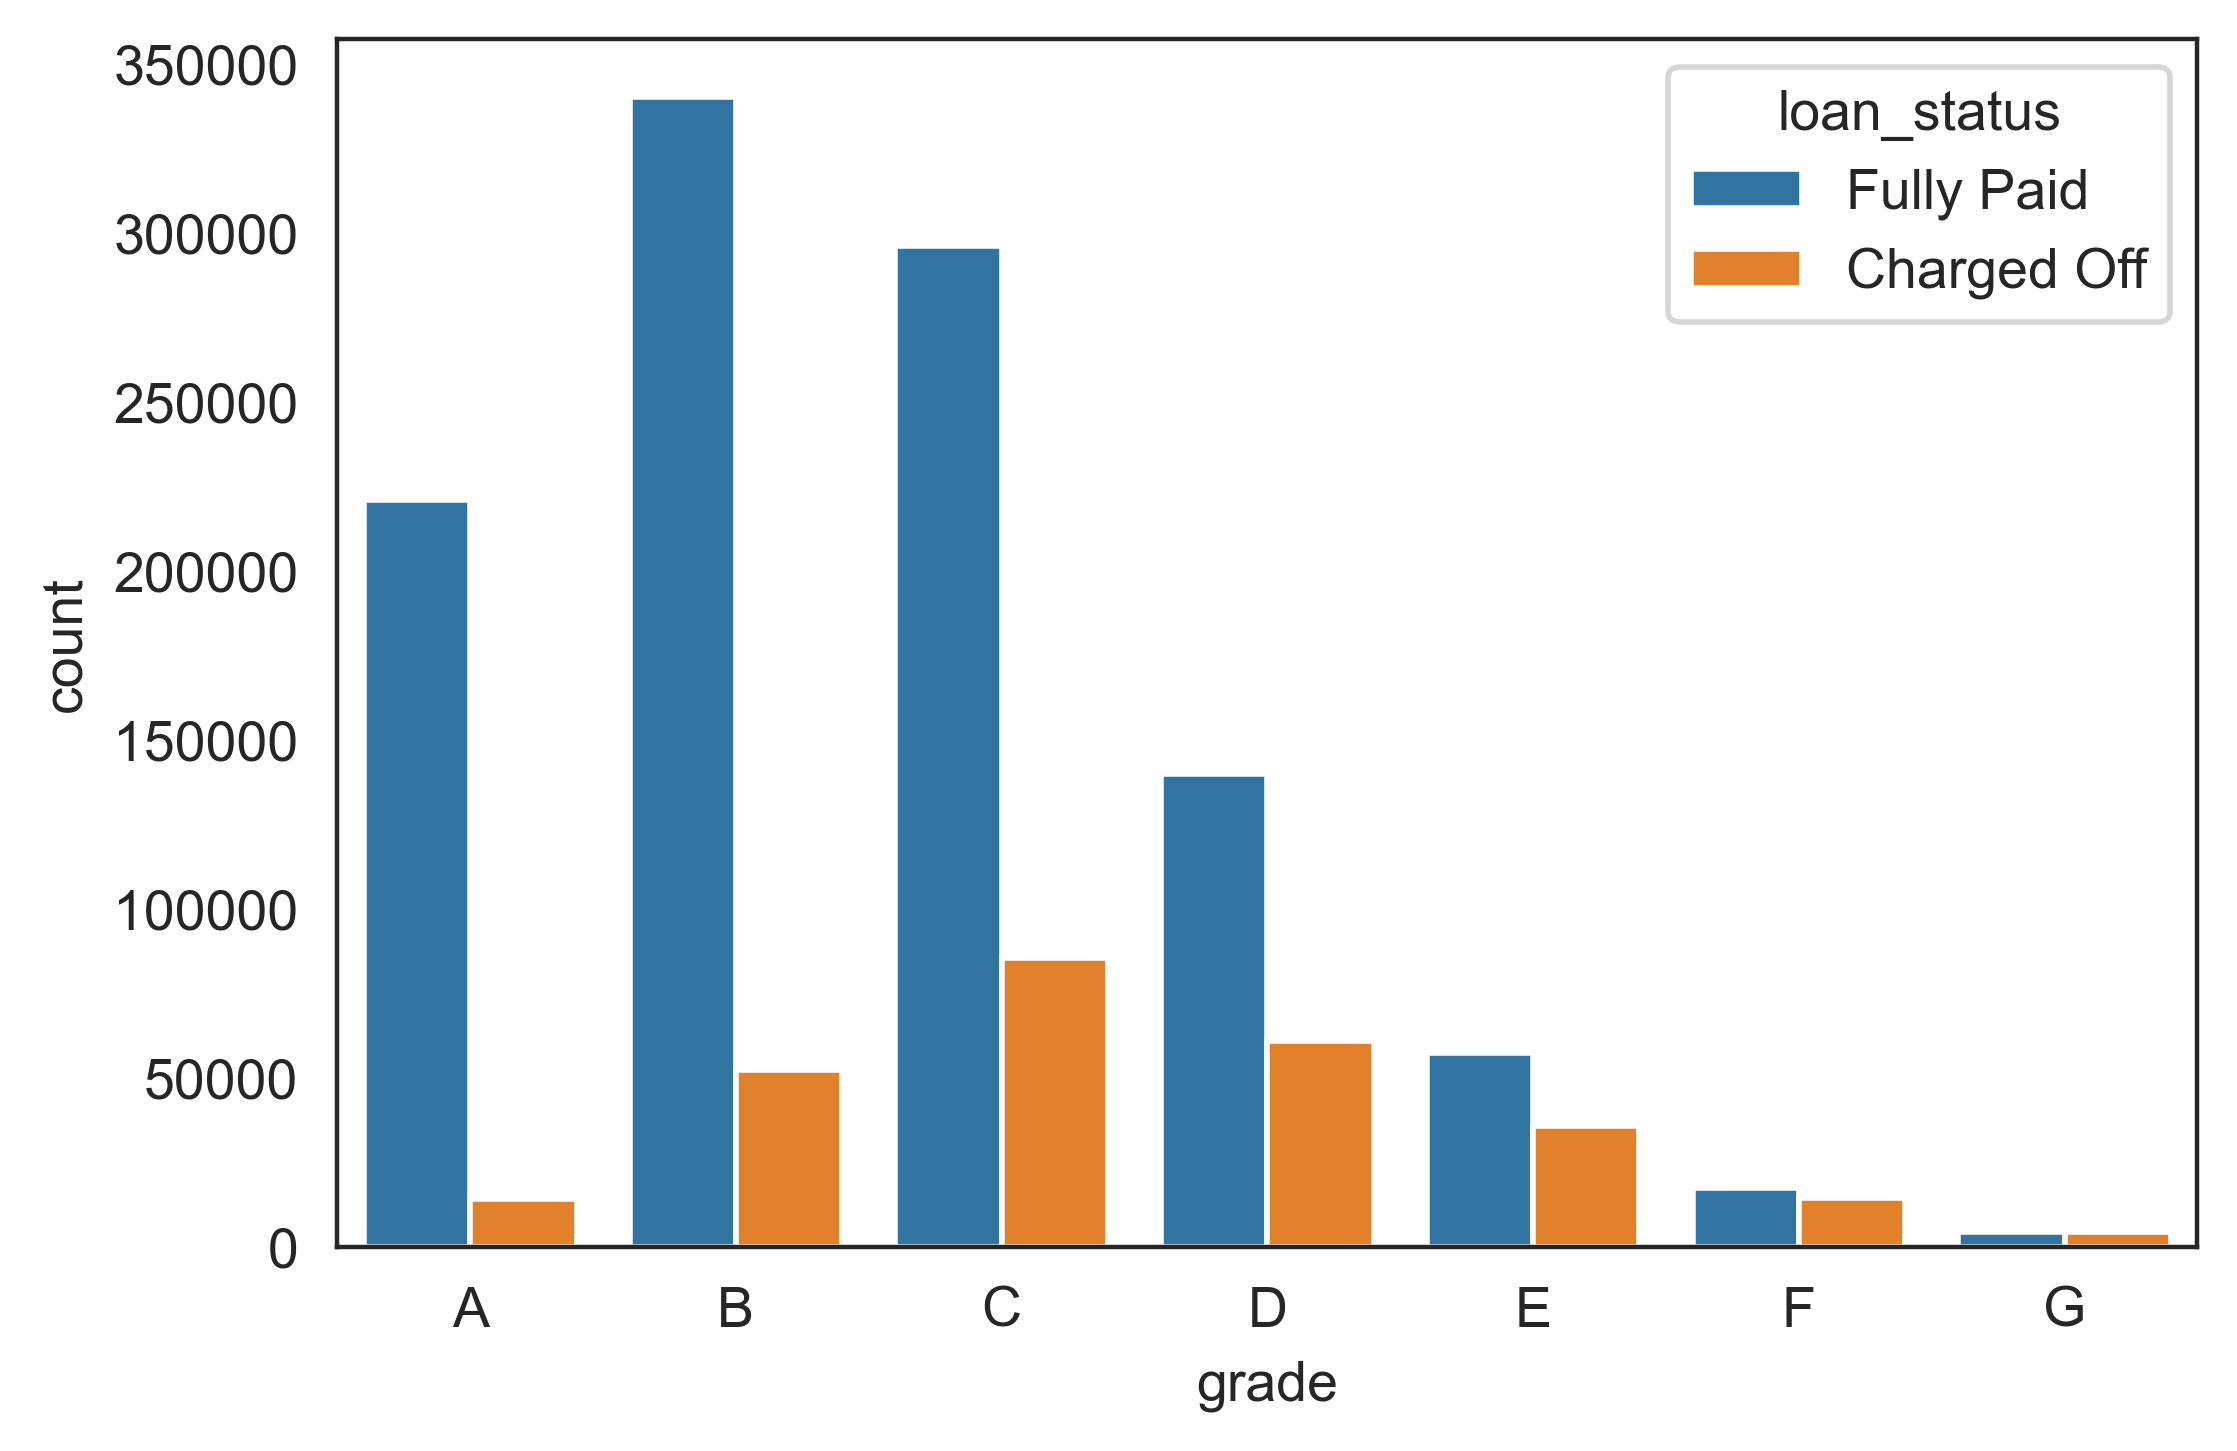

In [48]:
grade_order = sorted(df['grade'].unique())
sns.countplot(x='grade',data=df, order=grade_order, hue='loan_status')

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

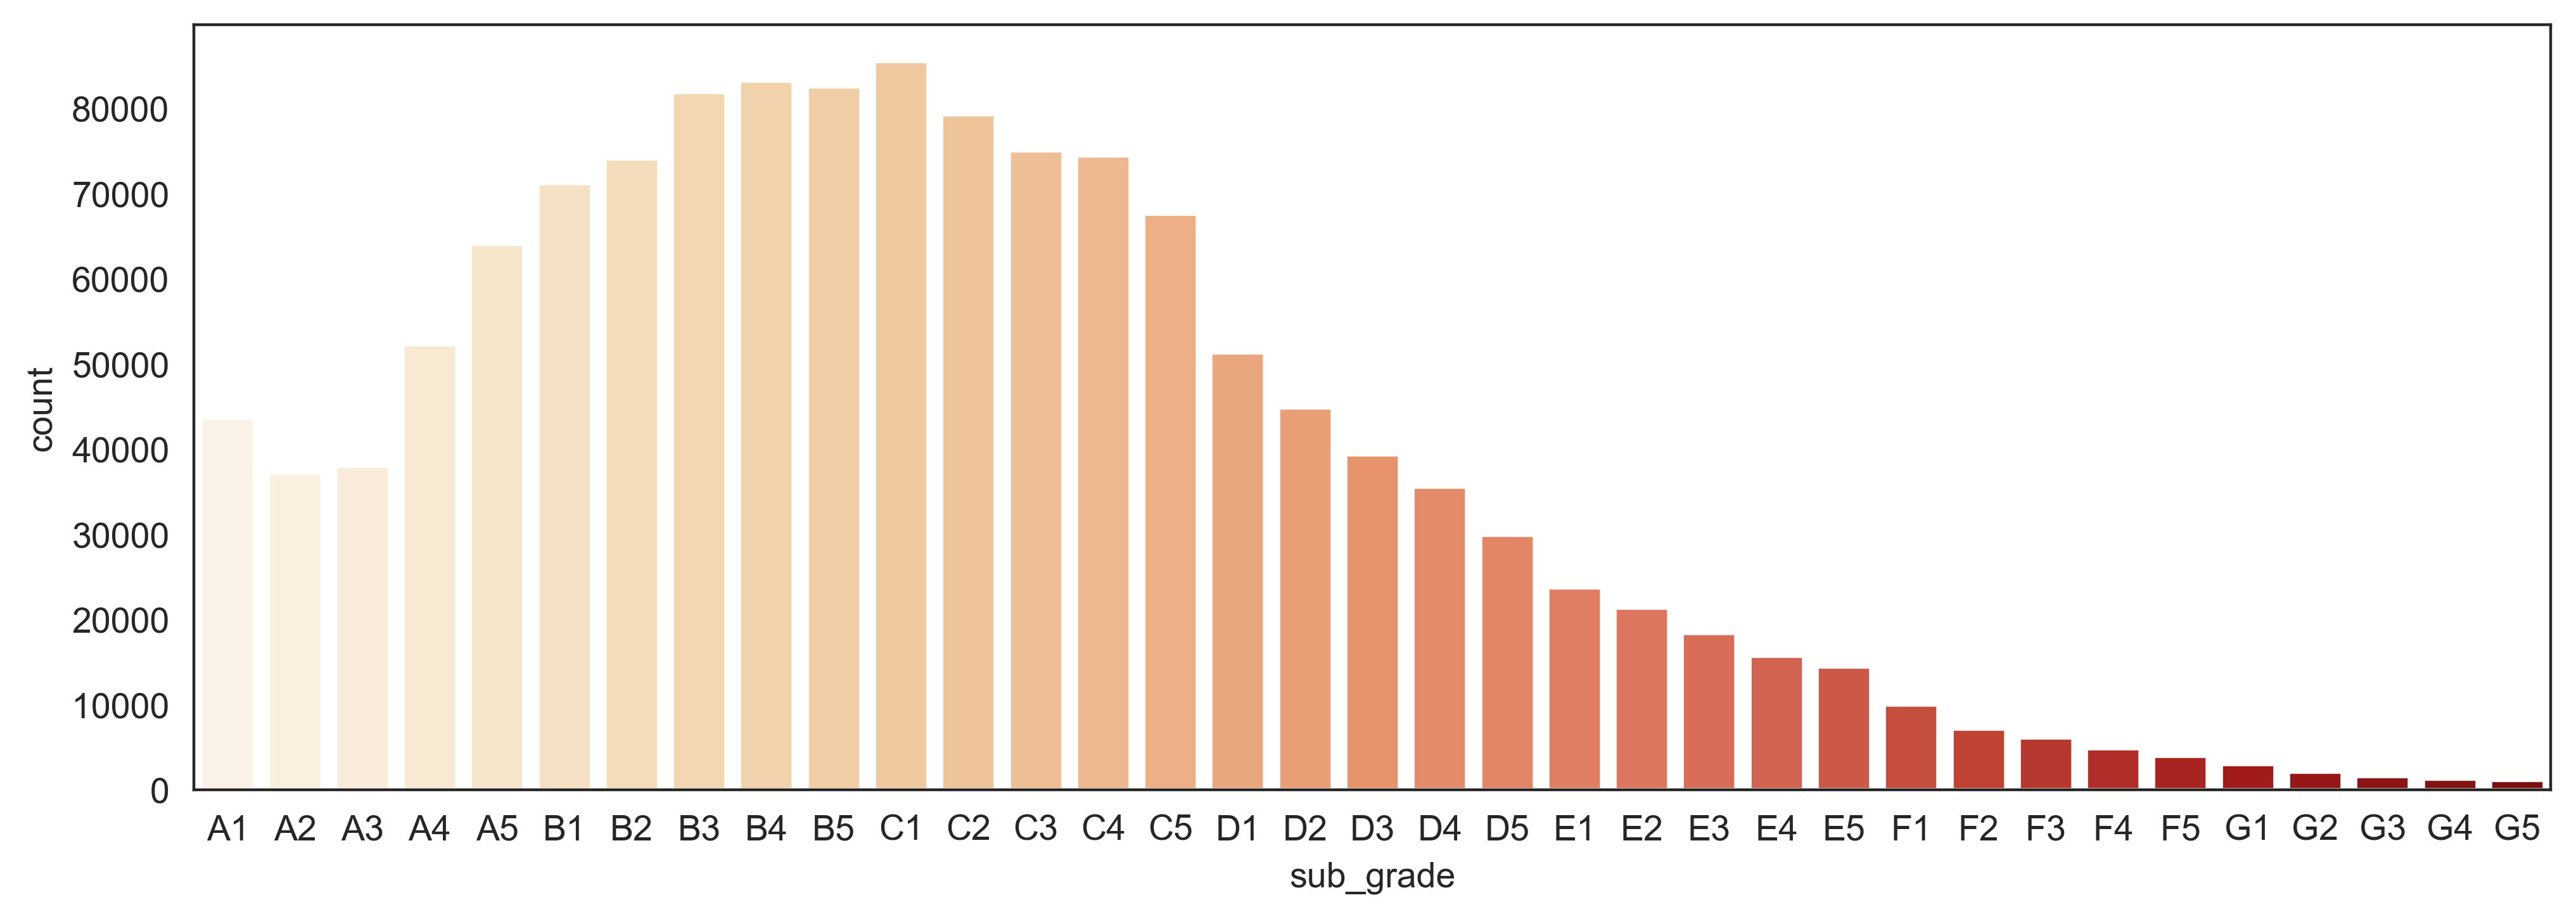

In [49]:
plt.figure(figsize=(12,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order = subgrade_order,palette='OrRd' )

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

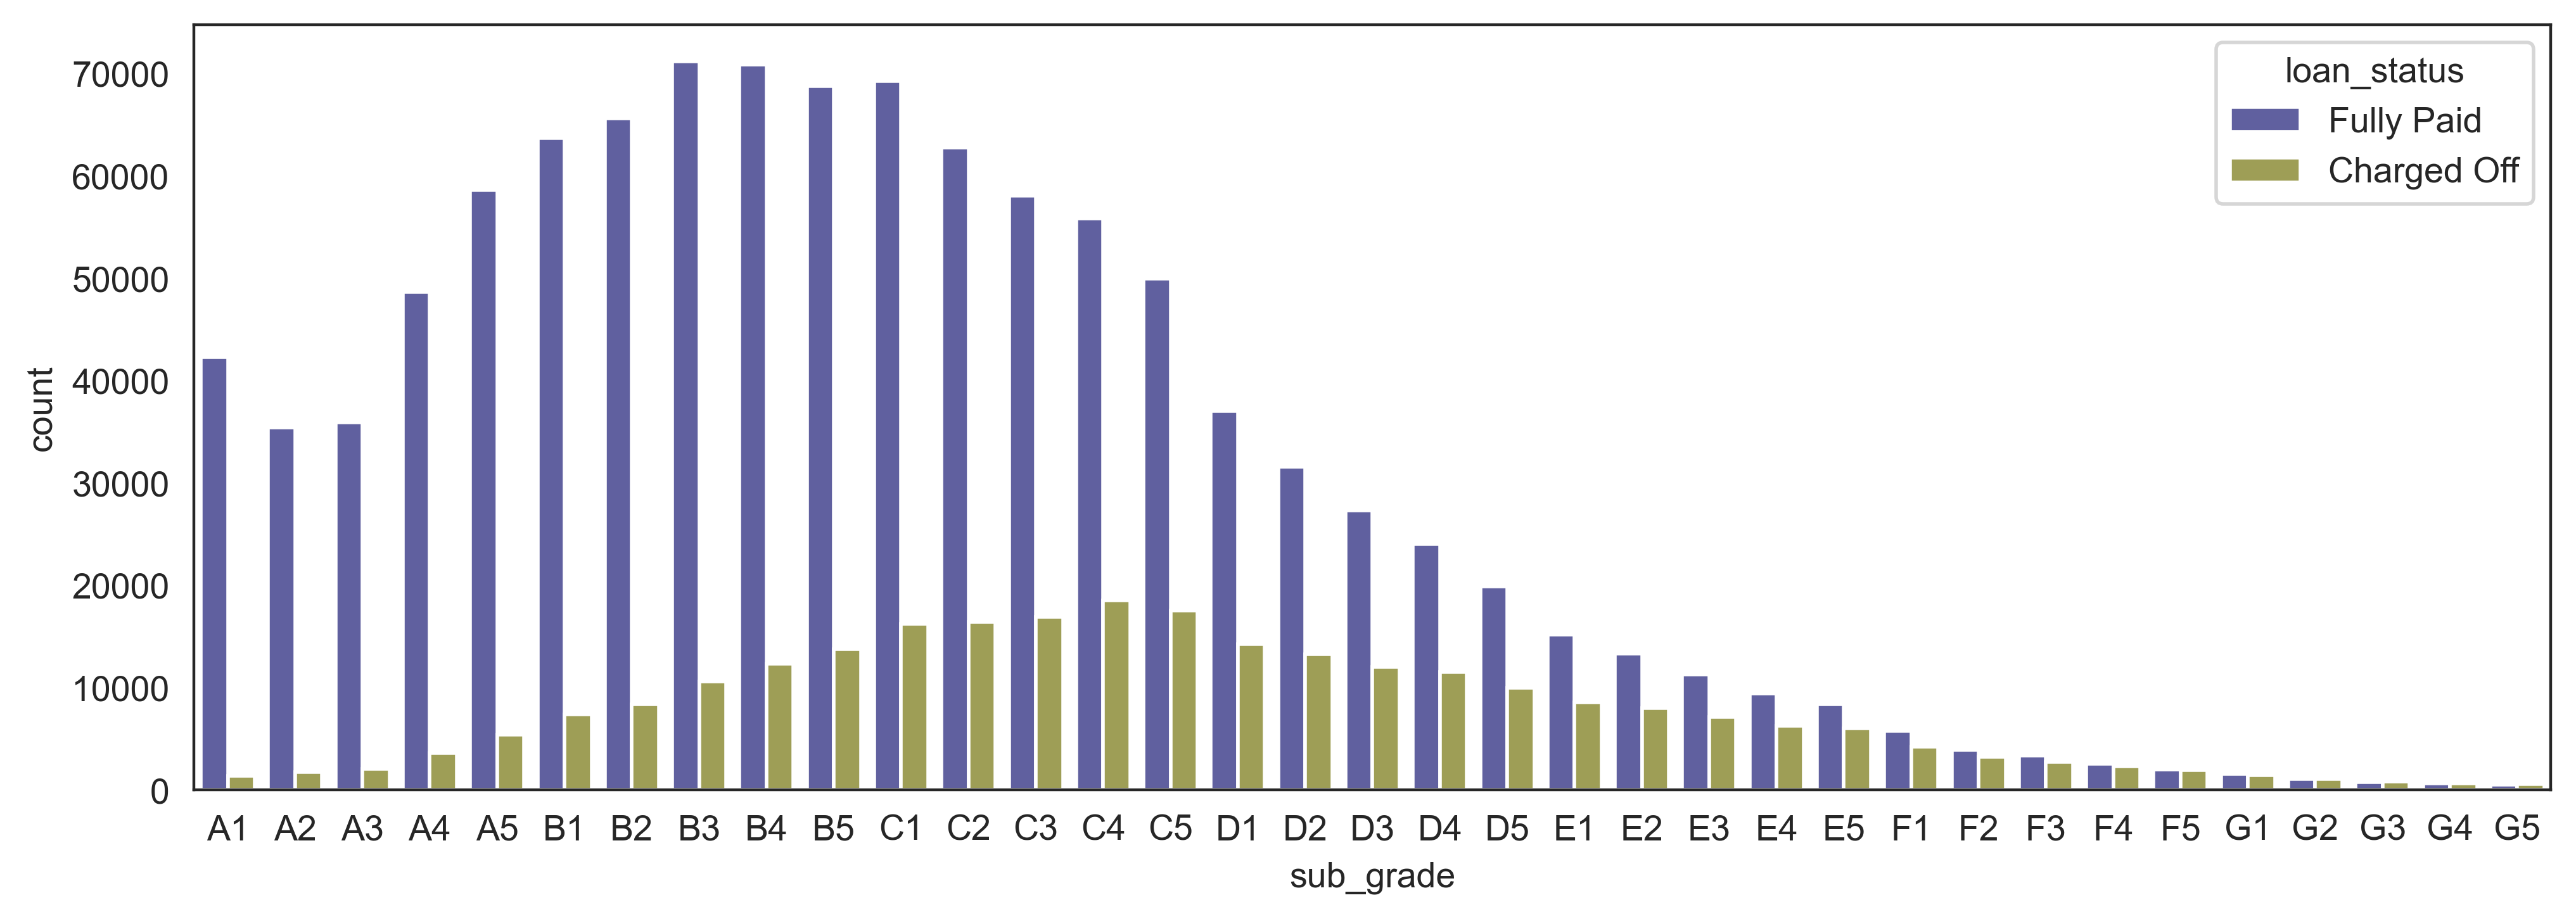

In [50]:
plt.figure(figsize=(12,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order = subgrade_order,palette='gist_stern' ,hue='loan_status')

It looks like F and G subgrades don't get paid back that often. Isloate those and recreate the countplot just for those subgrades.

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

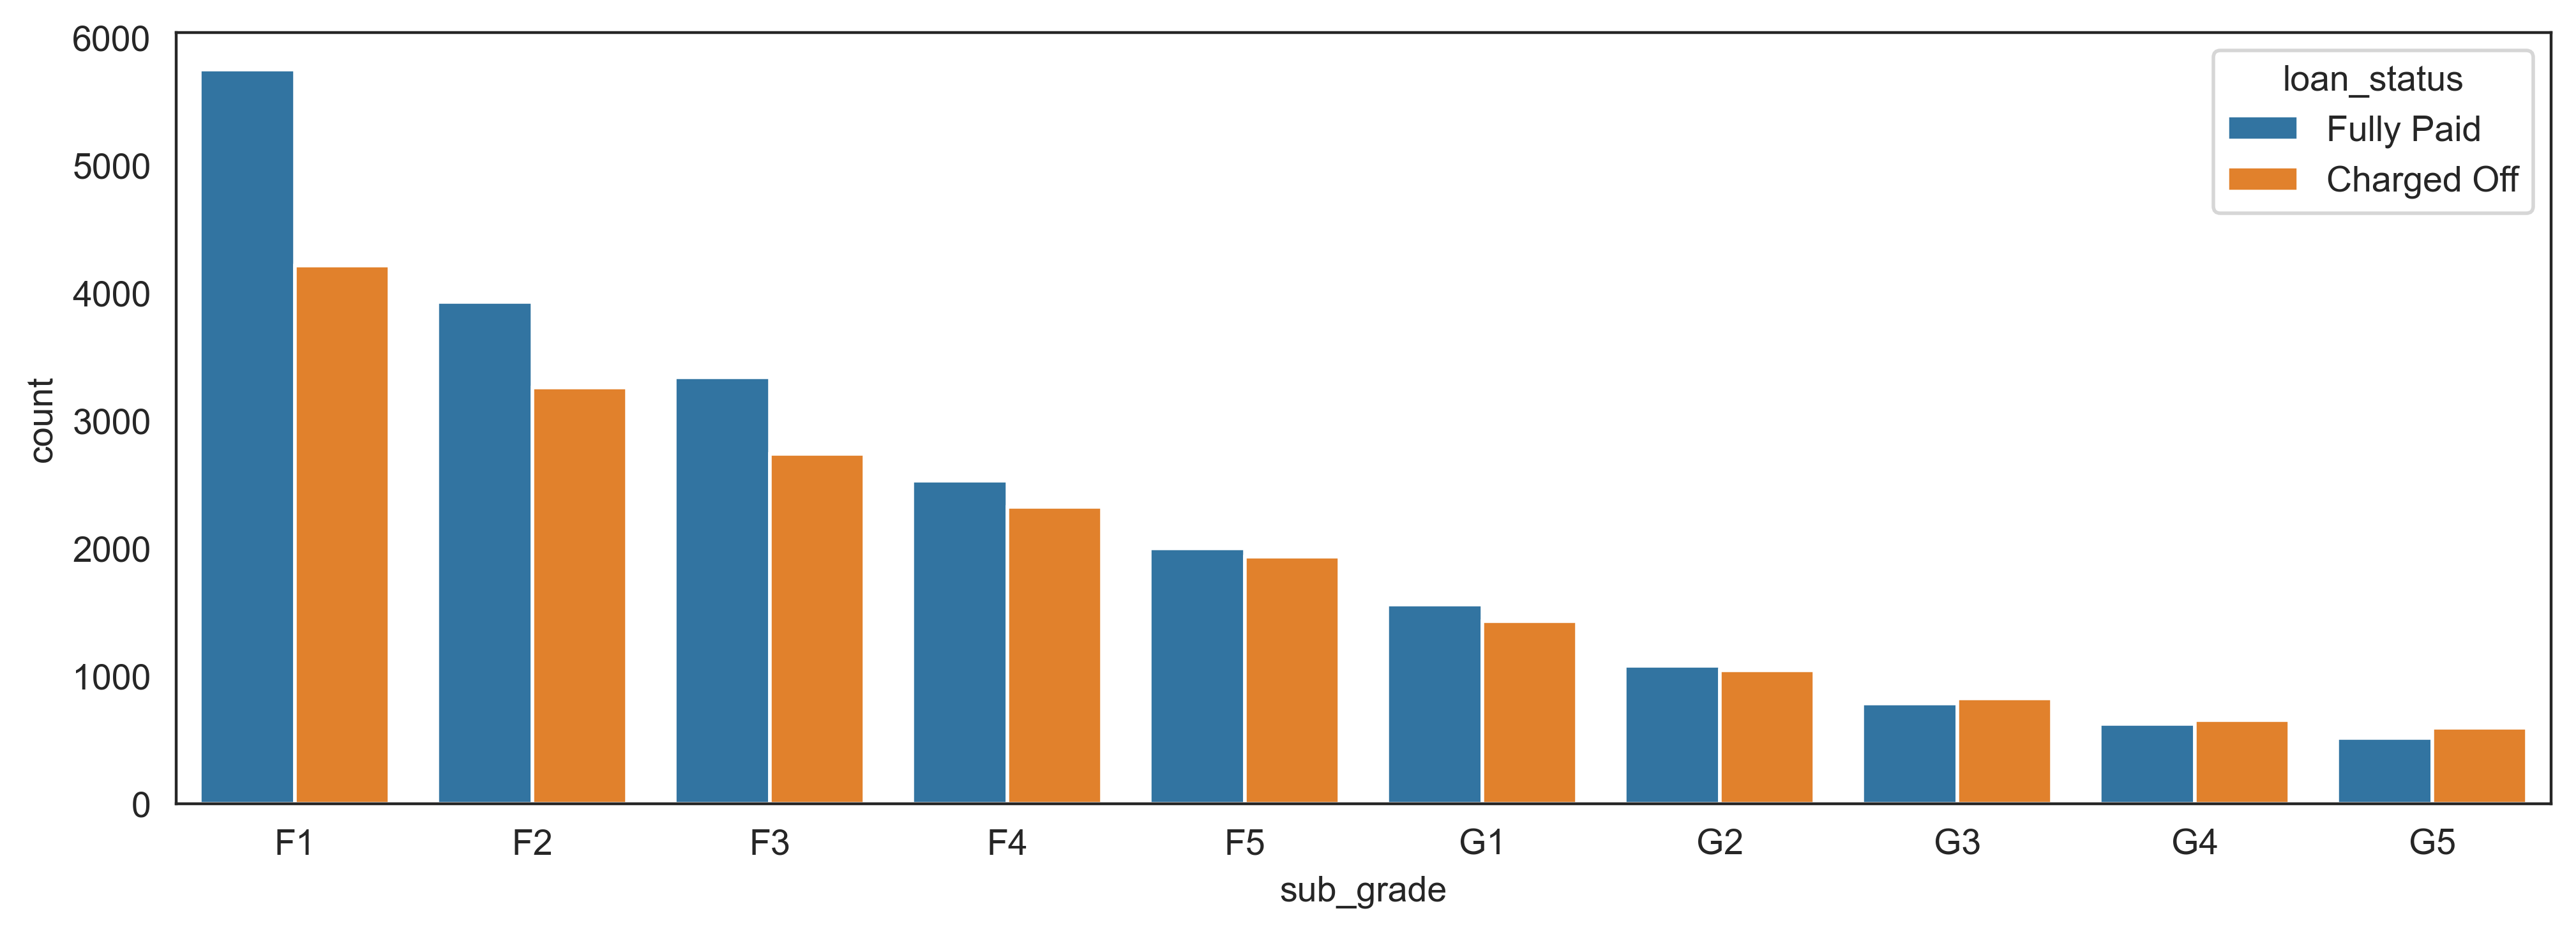

In [51]:
f_and_g = df[(df['grade']=='G') | (df['grade']=='F')]

plt.figure(figsize=(12,4))
subgrade_order = sorted(f_and_g['sub_grade'].unique())
sns.countplot(x='sub_grade',data=f_and_g,order = subgrade_order,hue='loan_status')

We can drop 'grade' as subgrade does similar job but in more detail

In [52]:
drop_cols('grade')

### 6. Length of Employment

In [53]:
print(dict_df.loc['emp_length'])
df['emp_length'].value_counts(dropna=False).sort_index()

Description    Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
Name: emp_length, dtype: object


1 year        88494
10+ years    442199
2 years      121743
3 years      107597
4 years       80556
5 years       84154
6 years       62733
7 years       59624
8 years       60701
9 years       50937
< 1 year     108061
NaN           78511
Name: emp_length, dtype: int64

In [54]:
df['emp_length'].replace('10+ years', '10 years', inplace=True)
df['emp_length'].replace('< 1 year', '0 years', inplace=True)
df['emp_length'].value_counts(dropna=False).sort_index()

0 years     108061
1 year       88494
10 years    442199
2 years     121743
3 years     107597
4 years      80556
5 years      84154
6 years      62733
7 years      59624
8 years      60701
9 years      50937
NaN          78511
Name: emp_length, dtype: int64

In [55]:
df.emp_length.map( lambda x: str(x).split()[0]).value_counts(dropna=True).sort_index()

0      108061
1       88494
10     442199
2      121743
3      107597
4       80556
5       84154
6       62733
7       59624
8       60701
9       50937
nan     78511
Name: emp_length, dtype: int64

Drop the years word from the emp_length and just keep the number of years

In [56]:
df['emp_length'] = df.emp_length.map( lambda x: float(str(x).split()[0]))
df['emp_length'].sample(5)

165334     7.00
132793     7.00
419201    10.00
2075682    1.00
1861587    8.00
Name: emp_length, dtype: float64

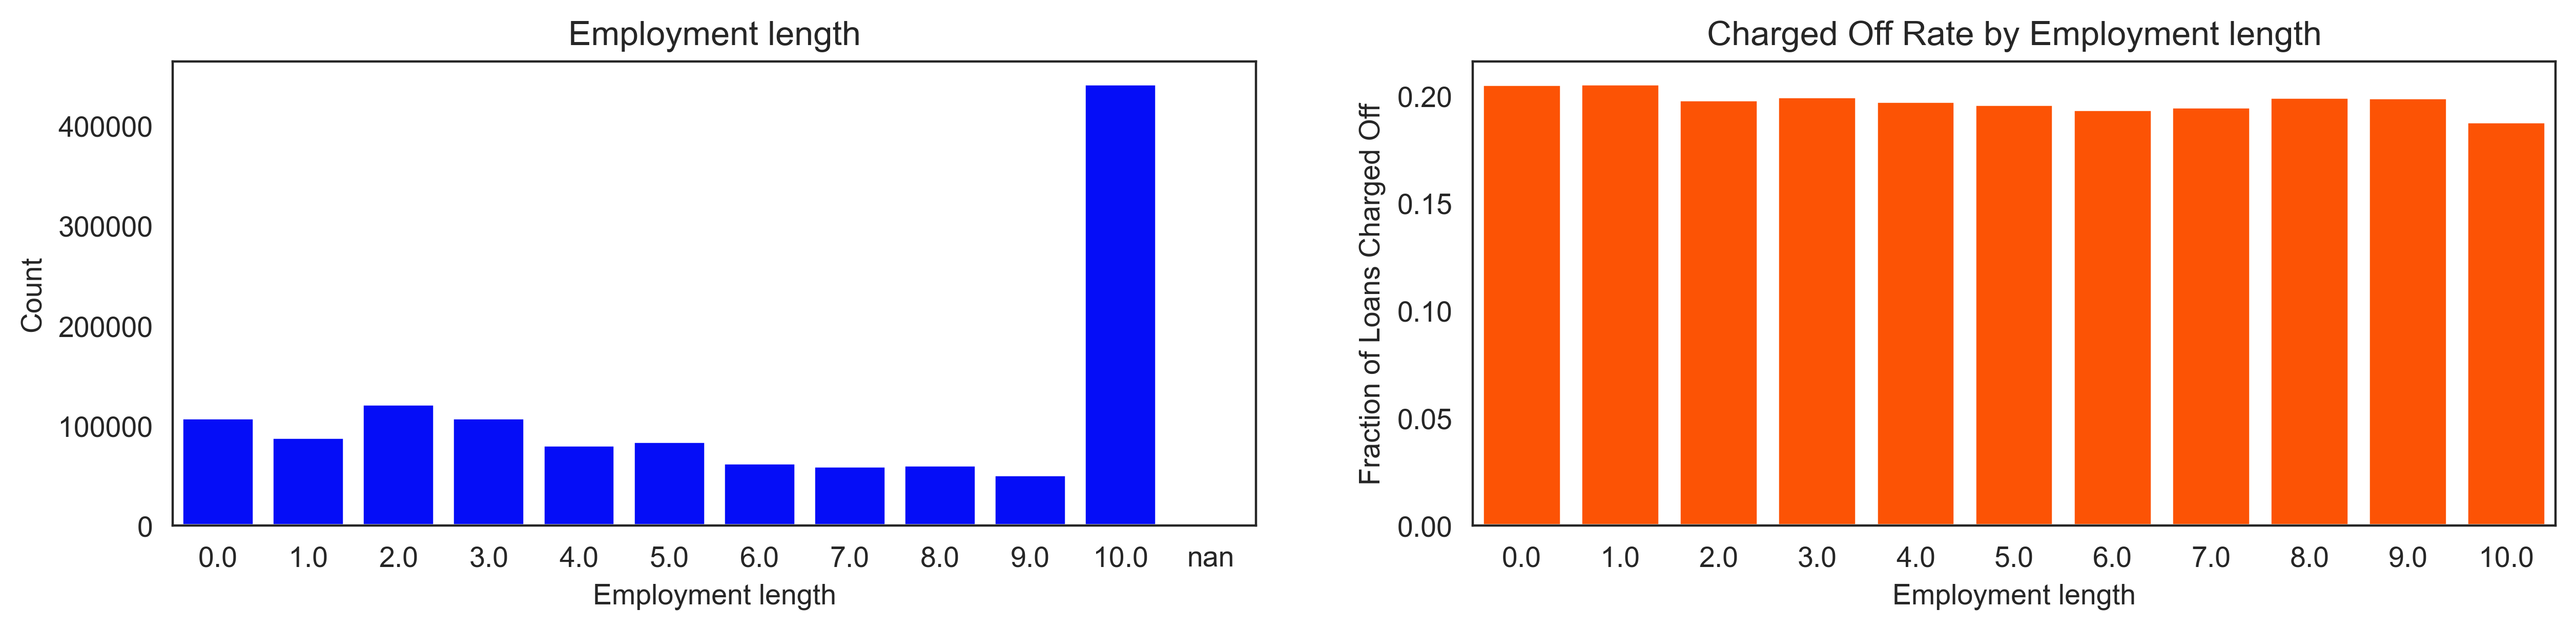

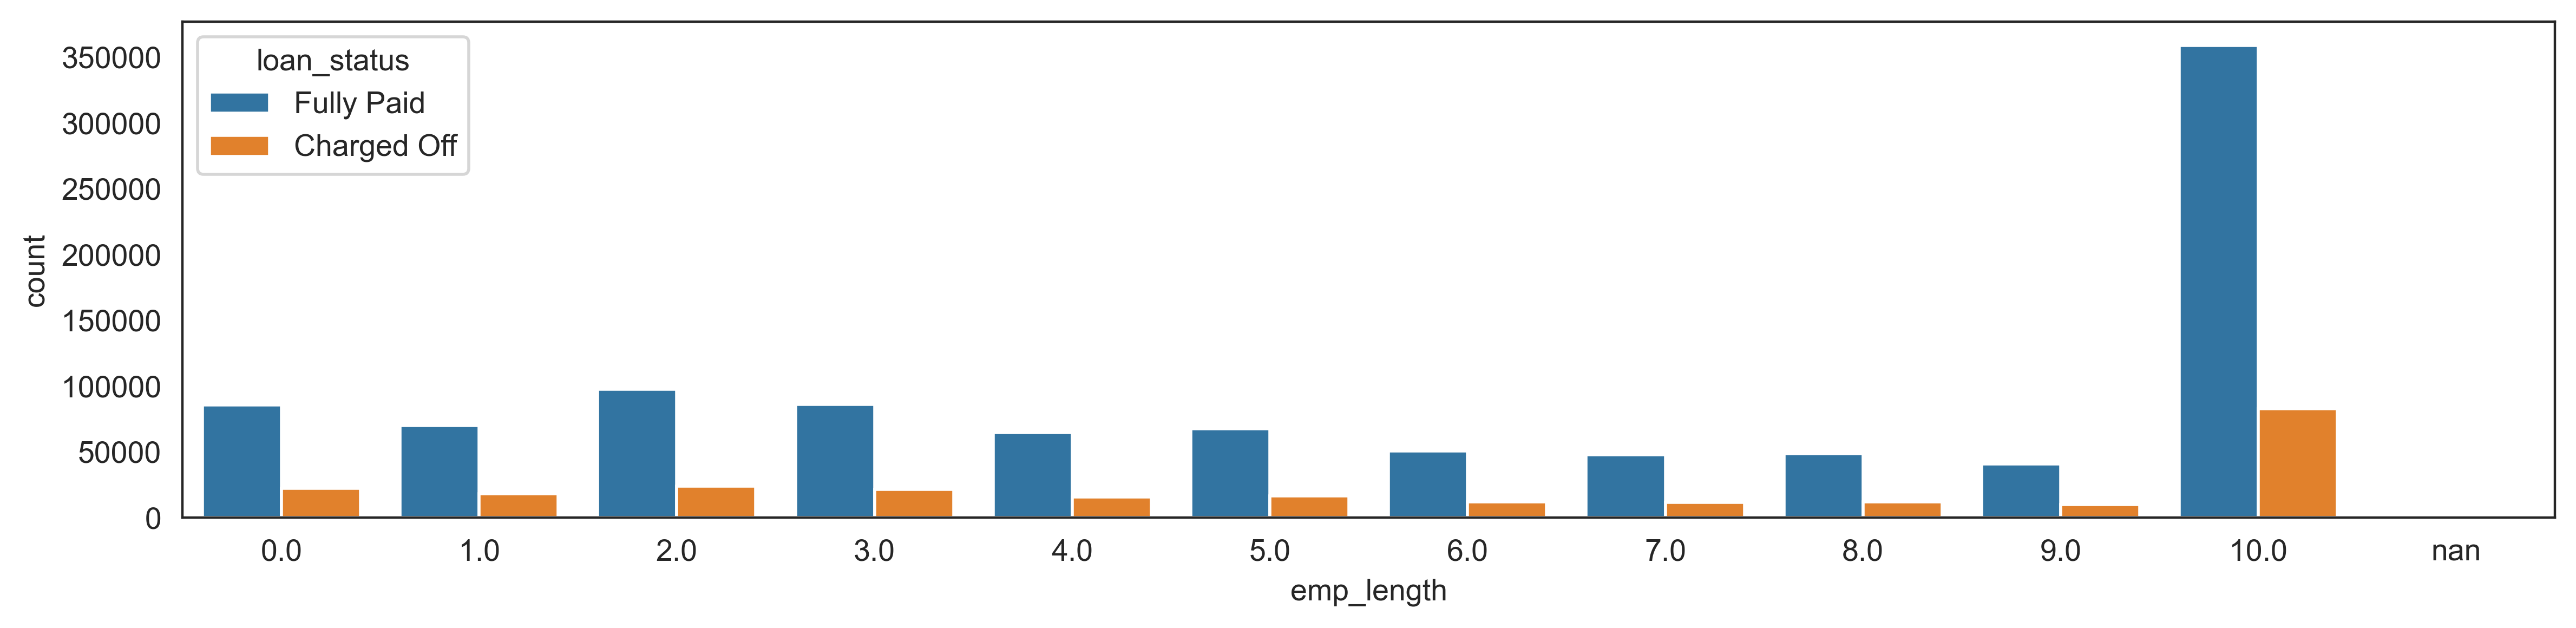

In [57]:
plot_func('emp_length', 'Employment length', continuous=False)

About 33% of the loans go to the people with longer than 10 of employment. But Charge off percent seems to be about 20% across all of them.

### 7. Home Ownership

In [58]:
df['home_ownership'].value_counts()

MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

We can combine ANY, OTHER, and NONE under OTHER as the numbers are too low

In [59]:
df['home_ownership'].replace(['NONE','ANY'],'OTHER', inplace=True)
df['home_ownership'].value_counts()

MORTGAGE    665579
RENT        534421
OWN         144832
OTHER          478
Name: home_ownership, dtype: int64

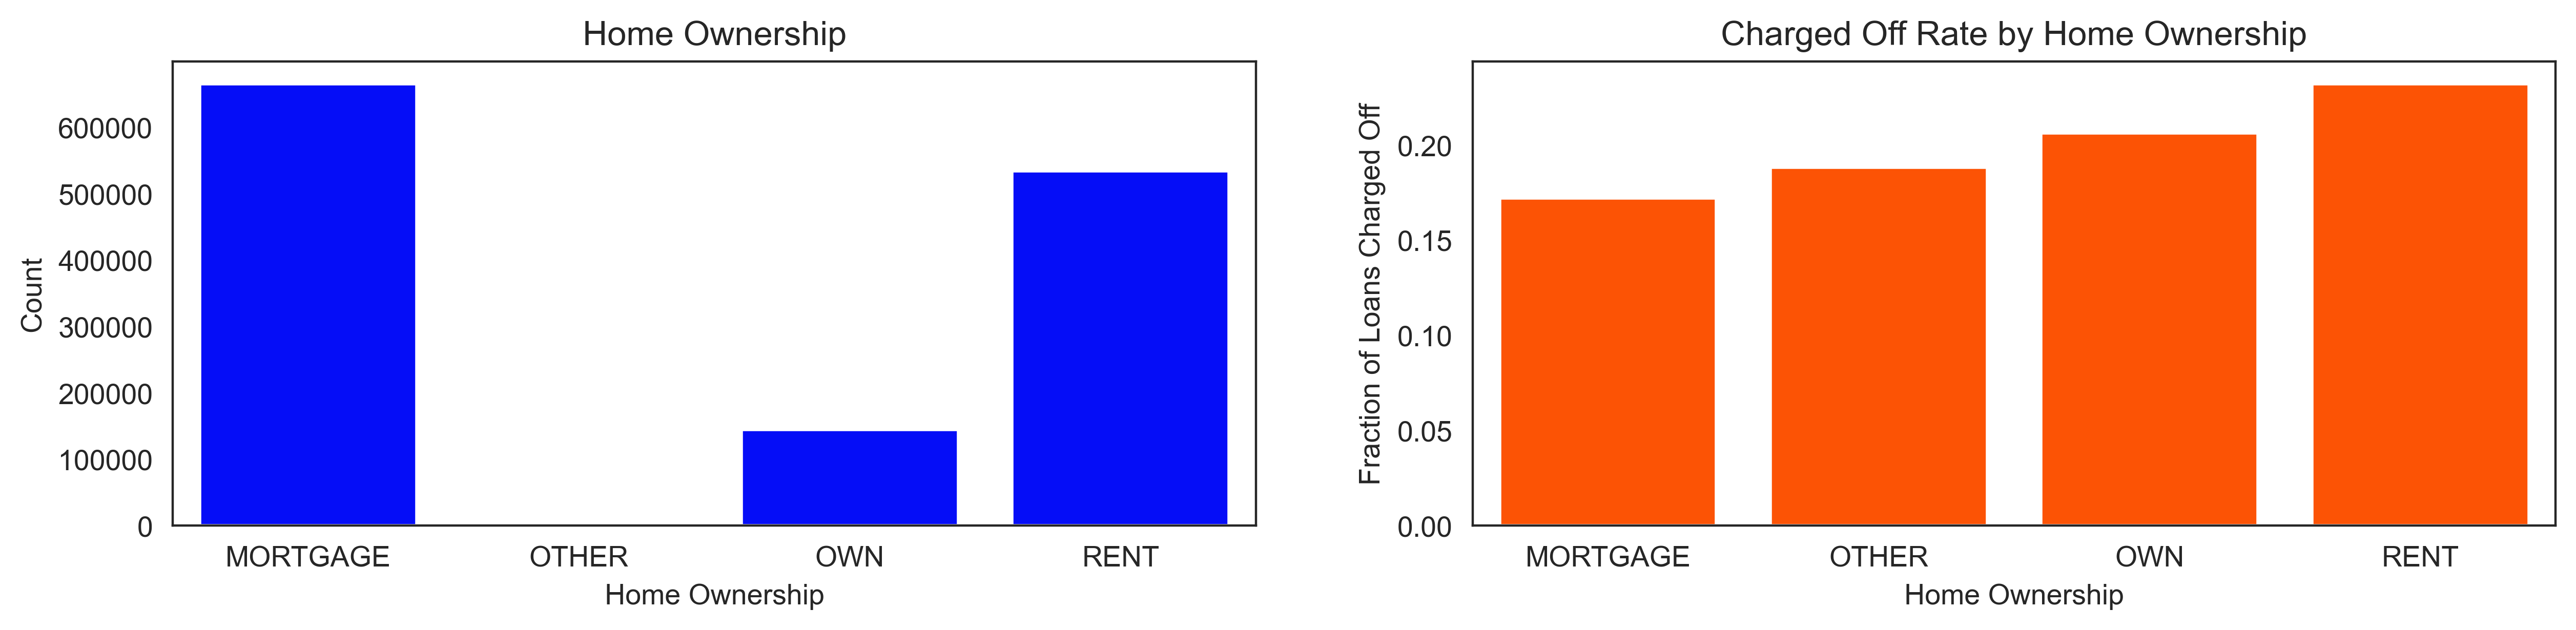

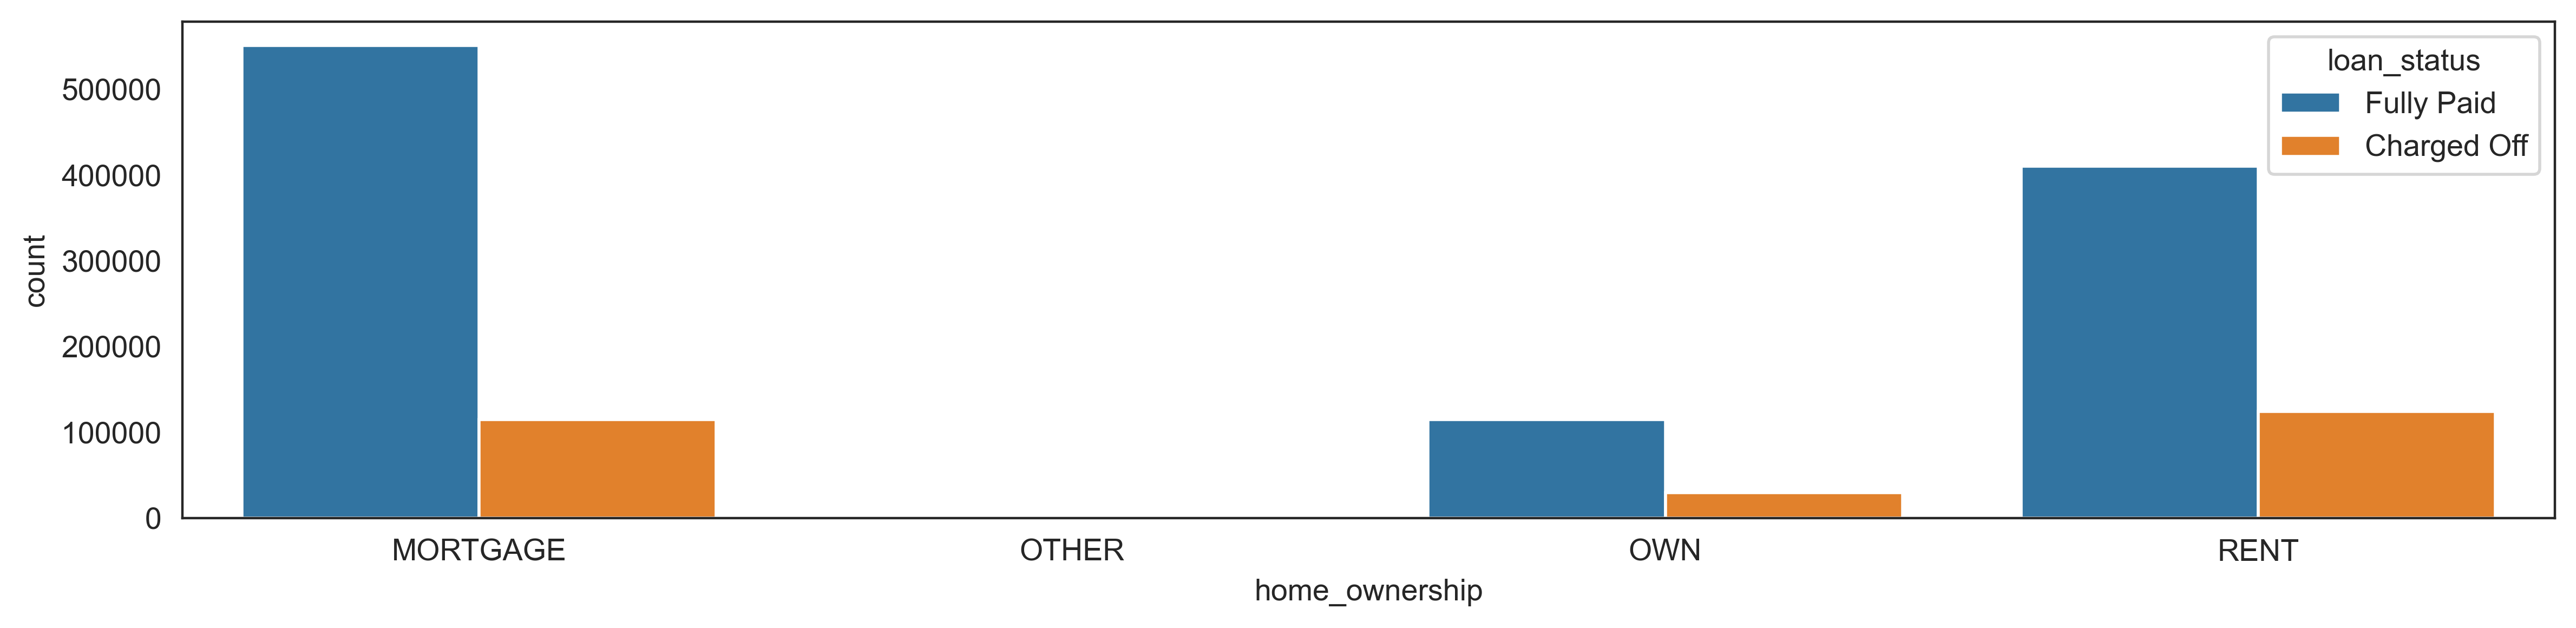

In [60]:
plot_func('home_ownership', 'Home Ownership', continuous=False)

In [61]:
df.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE   0.17
OTHER      0.19
OWN        0.21
RENT       0.23
Name: loan_status, dtype: float64

Mortgage & OTHER has slightly less probability of Charged-Off.

### 8. Annual Income

In [62]:
df['annual_inc'].describe()

count    1345310.00
mean       76247.64
std        69925.10
min            0.00
25%        45780.00
50%        65000.00
75%        90000.00
max     10999200.00
Name: annual_inc, dtype: float64

Annual income ranges from $0K to $11M, with a median at $65k. Due to the large range of variation, we log-transform the values.

In [63]:
df['annual_inc'] = df['annual_inc'].apply(lambda x:np.log10(x+1))
df['annual_inc'].describe()

count   1345310.00
mean          4.81
std           0.25
min           0.00
25%           4.66
50%           4.81
75%           4.95
max           7.04
Name: annual_inc, dtype: float64

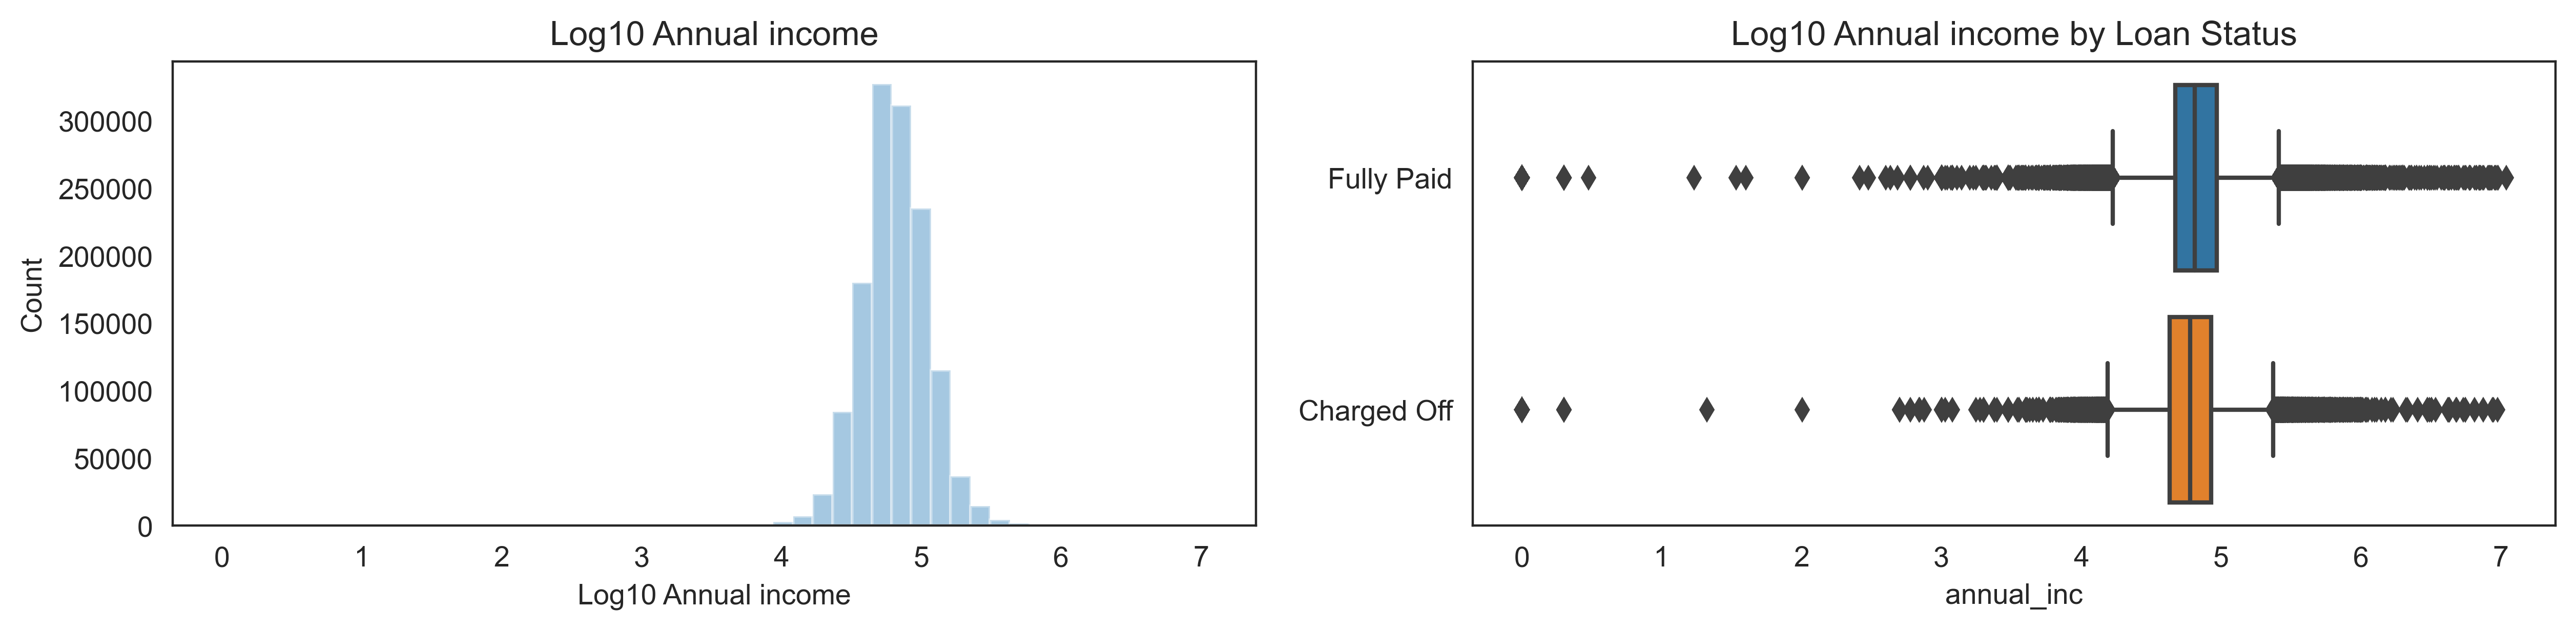

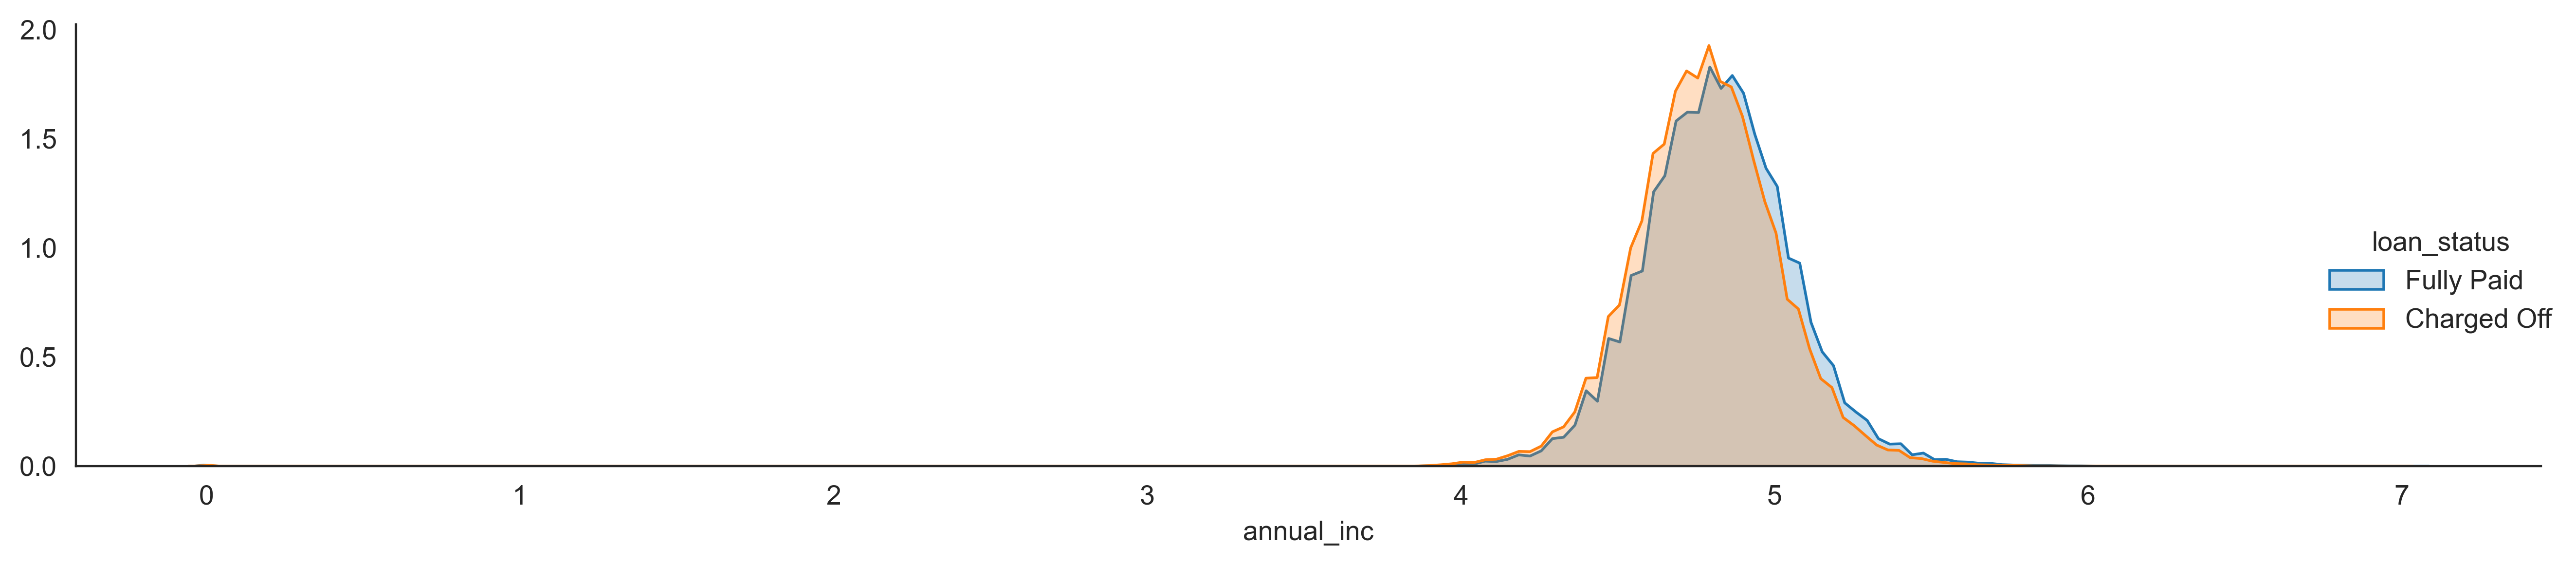

In [64]:
plot_func('annual_inc', 'Log10 Annual income', continuous=True)

In [65]:
df.groupby('loan_status')['annual_inc'].describe()

count  mean  std  min  25%  50%  75%  max
loan_status                                               
Charged Off  268559.00  4.78 0.24 0.00 4.63 4.78 4.93 6.98
Fully Paid  1076751.00  4.82 0.25 0.00 4.67 4.81 4.97 7.04

There are several outliers for both charged off and fully paid loans on the lower end.

### 9. Verification Status

In [66]:
print(dict_df.loc['verification_status'])
df['verification_status'].value_counts()

Description    Indicates if income was verified by LC, not verified, or if the income source was verified
Name: verification_status, dtype: object


Source Verified    521273
Verified           418336
Not Verified       405701
Name: verification_status, dtype: int64

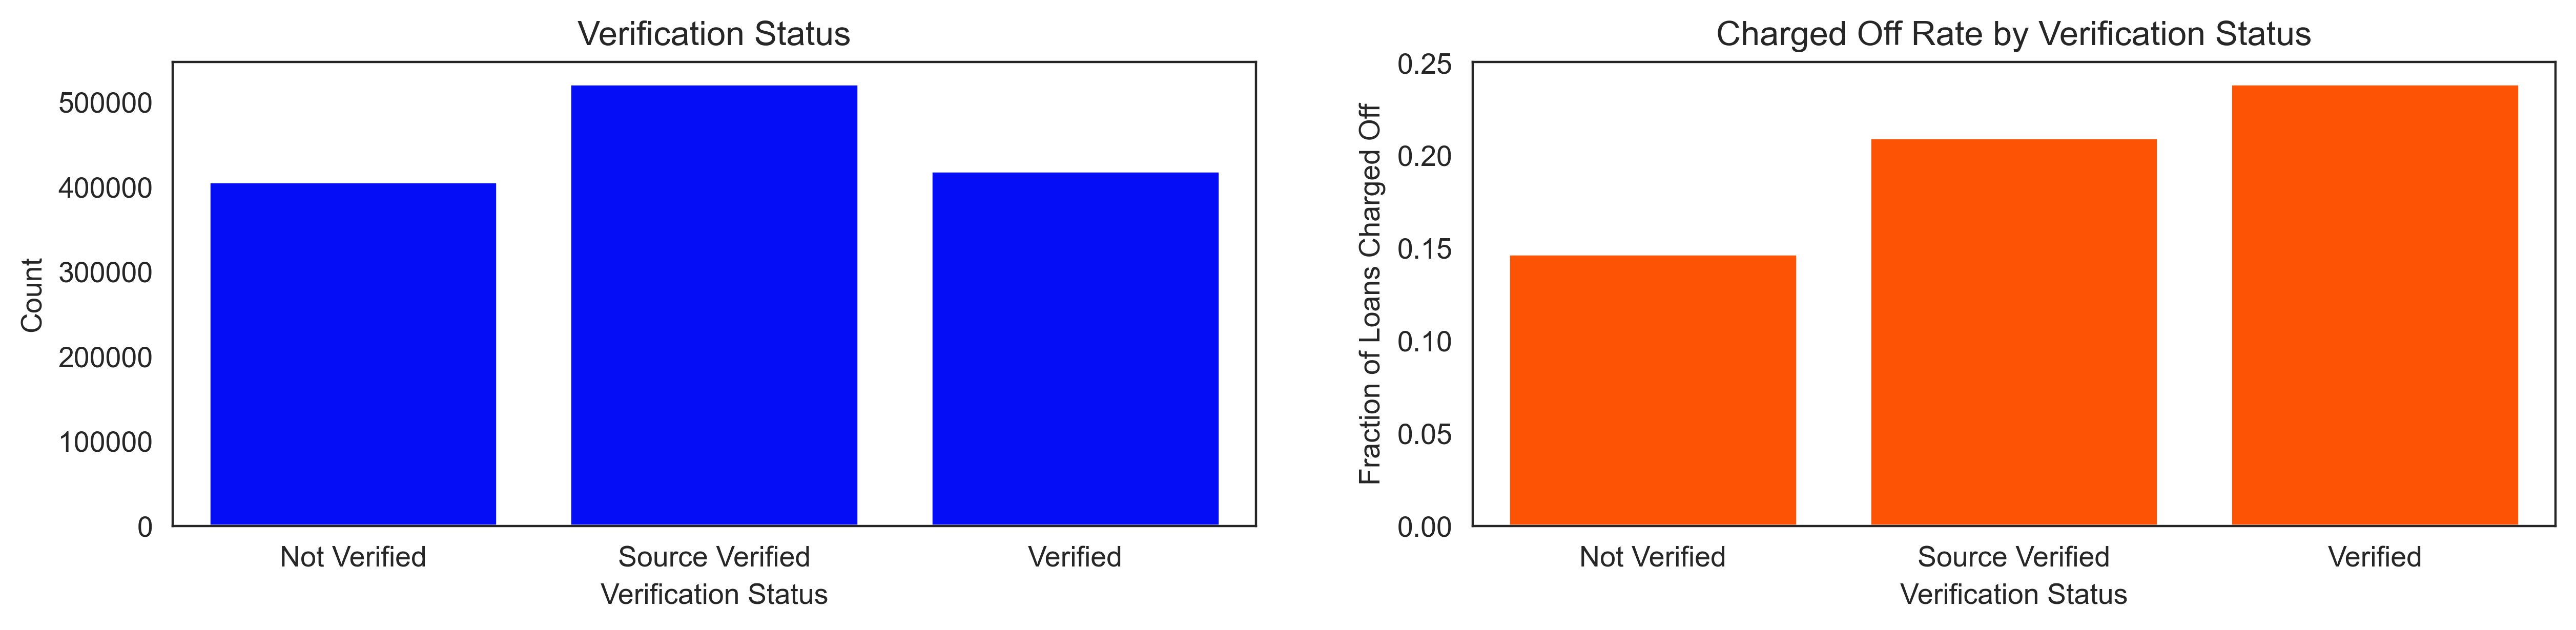

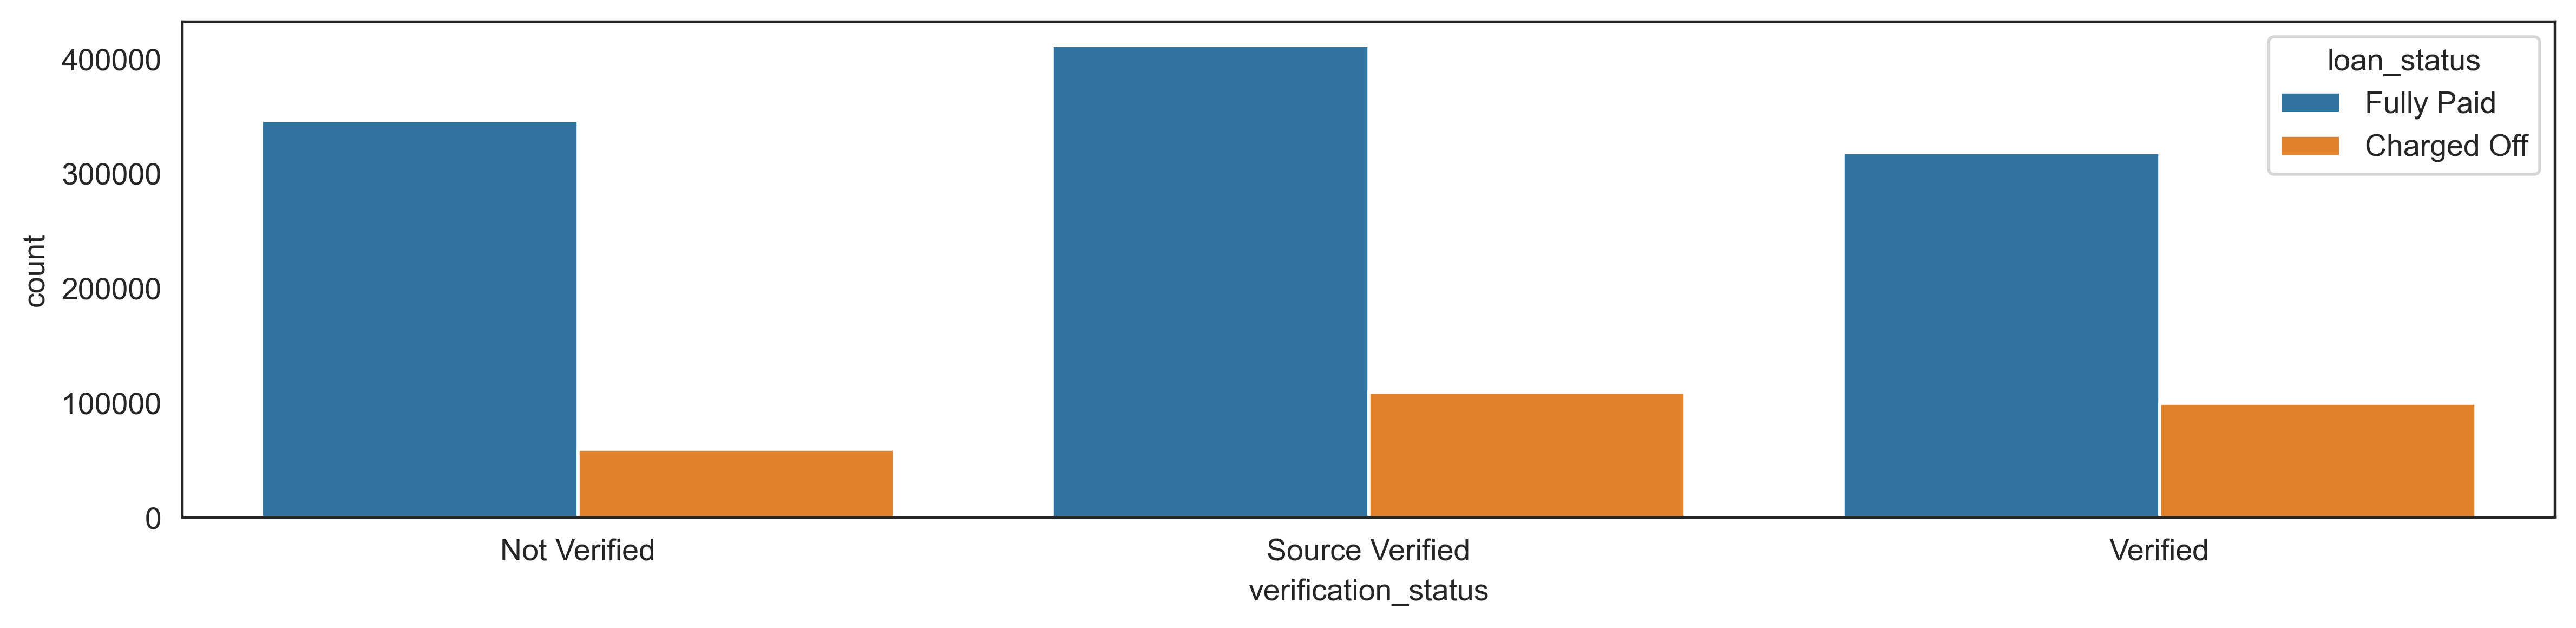

In [67]:
plot_func('verification_status', 'Verification Status', continuous=False)

Verified loans have higher chance of being charged off. In fact it is supposed be the other way.

### 10. Address State

In [68]:
print(dict_df.loc['addr_state'])
df['addr_state'].describe()

Description    The state provided by the borrower in the loan application
Name: addr_state, dtype: object


count     1345310
unique         51
top            CA
freq       196528
Name: addr_state, dtype: object

In [69]:
df.groupby('addr_state')['loan_status'].value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

addr_state
MS   0.26
NE   0.25
AR   0.24
AL   0.24
OK   0.23
LA   0.23
NY   0.22
NV   0.22
FL   0.21
IN   0.21
TN   0.21
NM   0.21
SD   0.21
MD   0.21
MO   0.21
NJ   0.21
KY   0.21
PA   0.21
NC   0.21
OH   0.21
ND   0.20
MI   0.20
HI   0.20
VA   0.20
TX   0.20
DE   0.20
MN   0.20
AK   0.20
AZ   0.20
CA   0.20
MA   0.19
ID   0.19
GA   0.18
WI   0.18
IL   0.18
RI   0.18
CT   0.17
UT   0.17
MT   0.17
WY   0.17
KS   0.17
SC   0.16
WA   0.16
CO   0.16
WV   0.16
NH   0.15
OR   0.14
IA   0.14
VT   0.14
ME   0.14
DC   0.13
Name: loan_status, dtype: float64

Mississippi state has highest percent(26%) of charge off and the DC(13%) has the lowest.

### 11. Debt to Income Ratio

In [70]:
print(dict_df.loc['dti'])
df['dti'].describe()

Description    A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
Name: dti, dtype: object


count   1344936.00
mean         18.28
std          11.16
min          -1.00
25%          11.79
50%          17.61
75%          24.06
max         999.00
Name: dti, dtype: float64

Text(0.5, 1.0, 'DTI by loan status')

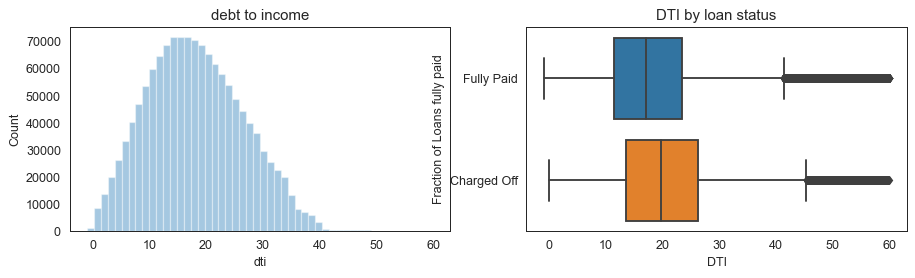

In [71]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], kde=False, ax=ax1)
ax1.set_xlabel('dti')
ax1.set_ylabel('Count')
ax1.set_title('debt to income')
sns.boxplot(x=df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], y='loan_status', data=df, ax=ax2)
ax2.set_xlabel('DTI')
ax2.set_ylabel('Fraction of Loans fully paid')
ax2.set_title('Fully paid rate by debt to income')
ax2.set_title('DTI by loan status')

In [72]:
(df['dti'] > 40).sum() / (df['dti']).sum()

0.0002751635018498183

In [73]:
(df['dti'] > 40).sum()

6766

In [74]:
df.groupby('loan_status')['dti'].median()

loan_status
Charged Off   19.76
Fully Paid    17.11
Name: dti, dtype: float64

DTI ratio is higher for charged off loans compared to fully paid loans.

### 12. Number of Open Accounts

In [75]:
print(dict_df.loc['open_acc'])
df['open_acc'].describe()

Description    The number of open credit lines in the borrower's credit file.
Name: open_acc, dtype: object


count   1345310.00
mean         11.59
std           5.47
min           0.00
25%           8.00
50%          11.00
75%          14.00
max          90.00
Name: open_acc, dtype: float64

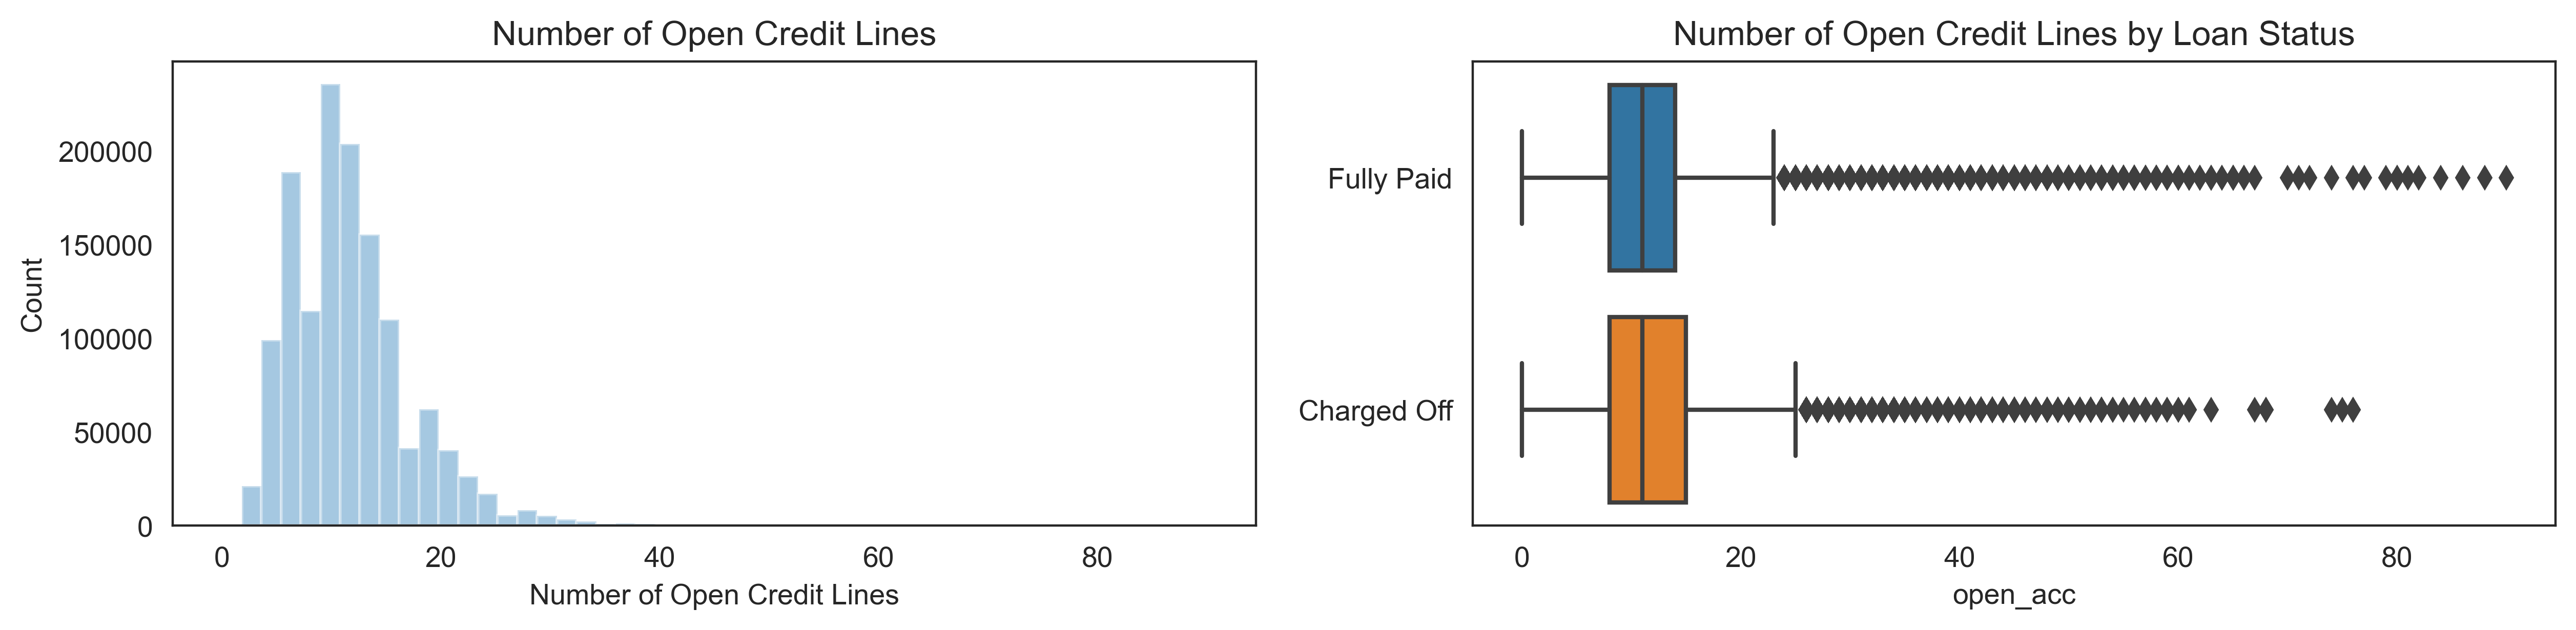

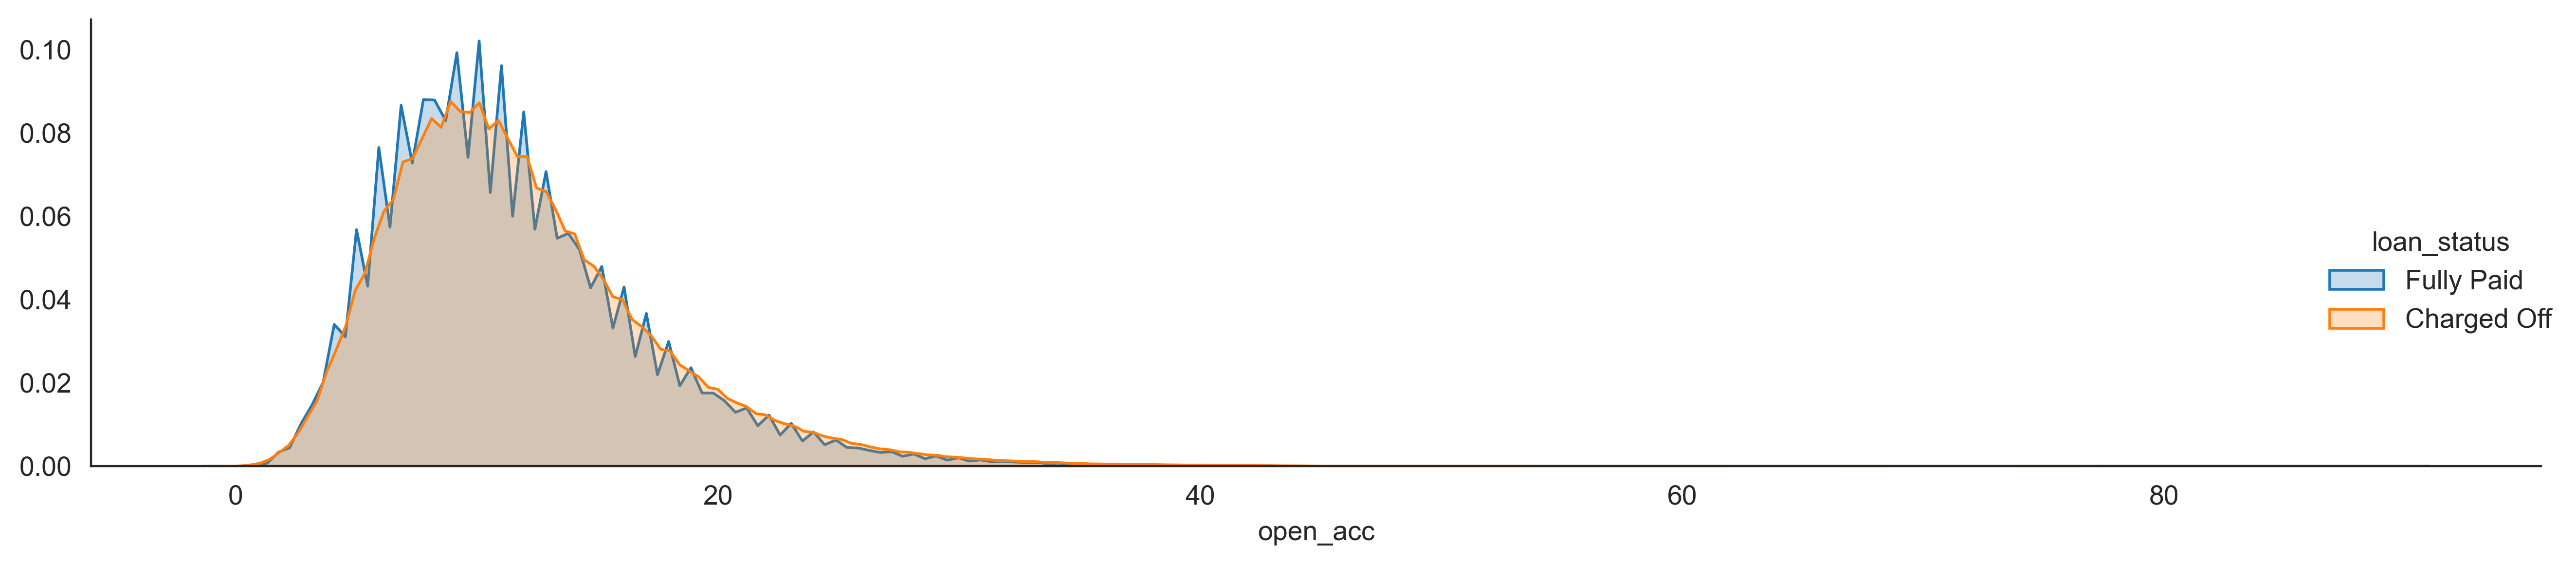

In [76]:
plot_func('open_acc', 'Number of Open Credit Lines', continuous=True)

In [77]:
df.groupby('loan_status')['open_acc'].describe()

count  mean  std  min  25%   50%   75%   max
loan_status                                                  
Charged Off  268559.00 11.90 5.64 0.00 8.00 11.00 15.00 76.00
Fully Paid  1076751.00 11.52 5.43 0.00 8.00 11.00 14.00 90.00

There is not much difference in average open accounts between charged off and fully paid loans. 

### 13. Earliest Credit Line

In [78]:
print(dict_df.loc['earliest_cr_line'])
print('\n')
print(df['earliest_cr_line'].sample(5))
print('\n')
print(df['earliest_cr_line'].describe())

Description    The month the borrower's earliest reported credit line was opened
Name: earliest_cr_line, dtype: object


1849231    Aug-1992
2053441    Oct-2004
1545347    Mar-2001
3277       Mar-2003
1740713    Feb-2003
Name: earliest_cr_line, dtype: object


count      1345310
unique         739
top       Aug-2001
freq          9391
Name: earliest_cr_line, dtype: object


In [79]:
df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda date:int(date[-4:]))
#df = df.drop('earliest_cr_line',axis=1)
df['earliest_cr_year'].shape

(1345310,)

In [80]:
df.earliest_cr_year.sample(5)

322928     2006
585034     2010
1304040    1986
227862     1980
1756486    1992
Name: earliest_cr_year, dtype: int64

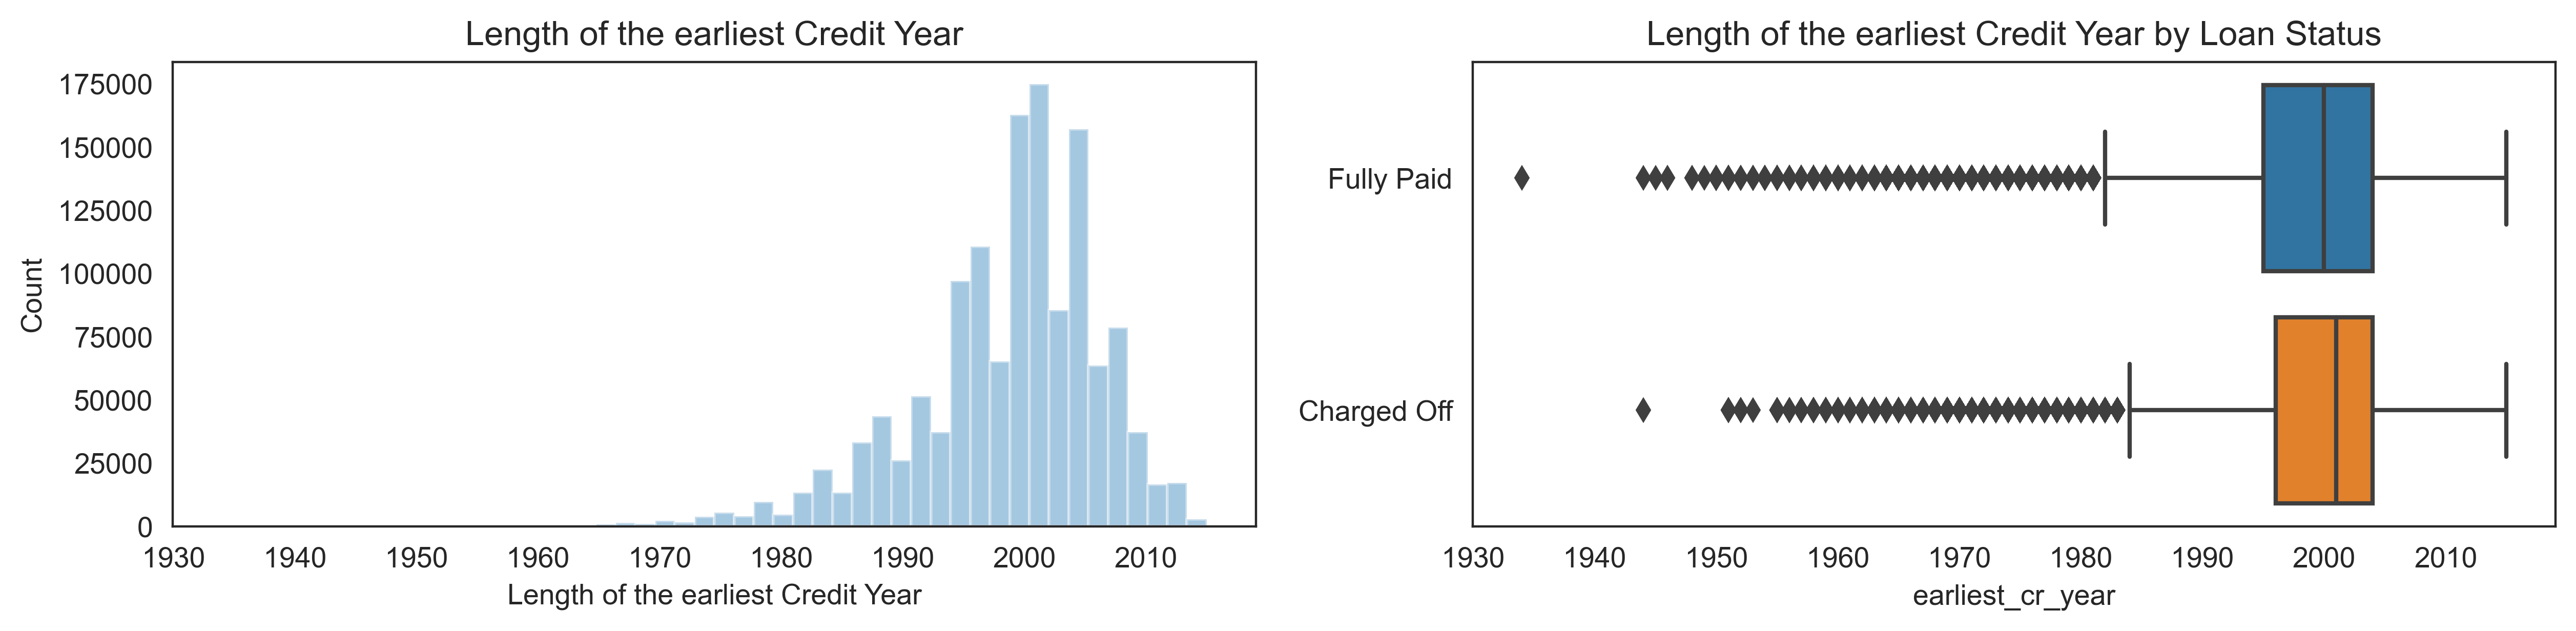

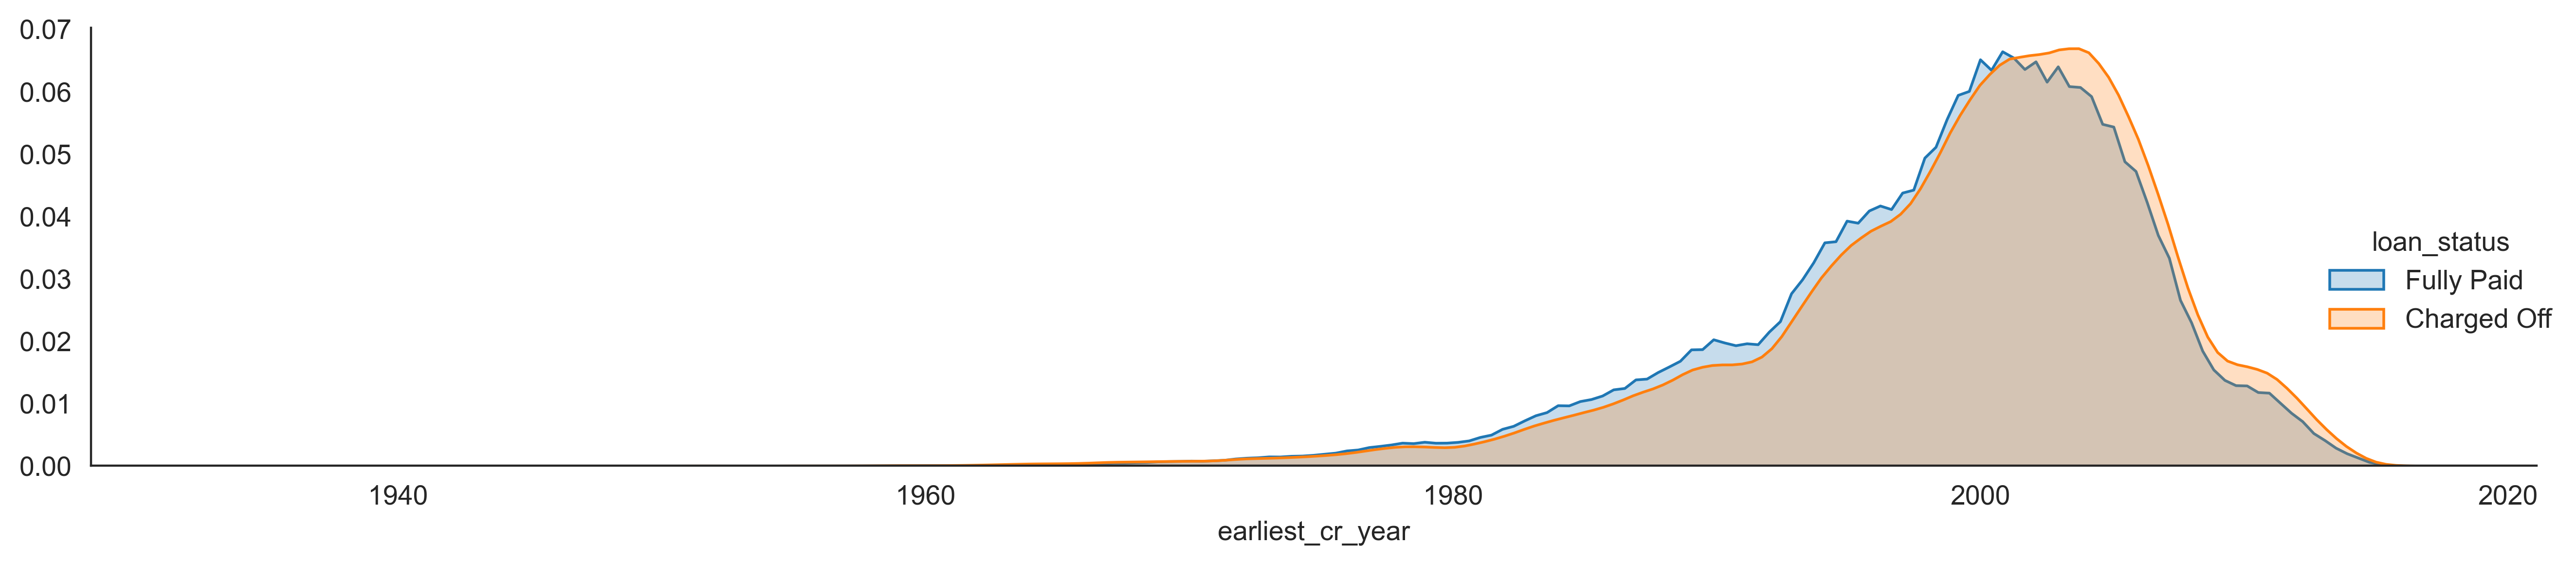

In [81]:
plot_func('earliest_cr_year', 'Length of the earliest Credit Year', continuous=True)

In [82]:
df.groupby('loan_status')['earliest_cr_year'].describe()

count    mean  std     min     25%     50%     75%     max
loan_status                                                                
Charged Off  268559.00 1999.36 7.58 1944.00 1996.00 2001.00 2004.00 2015.00
Fully Paid  1076751.00 1998.53 7.61 1934.00 1995.00 2000.00 2004.00 2015.00

In [83]:
drop_cols('earliest_cr_line')

### 14. FICO range LOW and HIGH

In [84]:
print(dict_df.loc['fico_range_low'])
print(dict_df.loc['fico_range_high'])
df[['fico_range_low','fico_range_high']].describe()

Description    The lower boundary range the borrower’s FICO at loan origination belongs to.
Name: fico_range_low, dtype: object
Description    The upper boundary range the borrower’s FICO at loan origination belongs to.
Name: fico_range_high, dtype: object


fico_range_low  fico_range_high
count      1345310.00       1345310.00
mean           696.19           700.19
std             31.85            31.85
min            625.00           629.00
25%            670.00           674.00
50%            690.00           694.00
75%            710.00           714.00
max            845.00           850.00

In [85]:
df[['fico_range_low','fico_range_high']].corr()

fico_range_low  fico_range_high
fico_range_low             1.00             1.00
fico_range_high            1.00             1.00

These two features are highly correlated. So we need to drop one. Instead of dropping one of them we can combine them into one feature. Create fico_score feature using these 2.

In [86]:
df['fico_score'] = (df['fico_range_low'] + df['fico_range_high'])/2

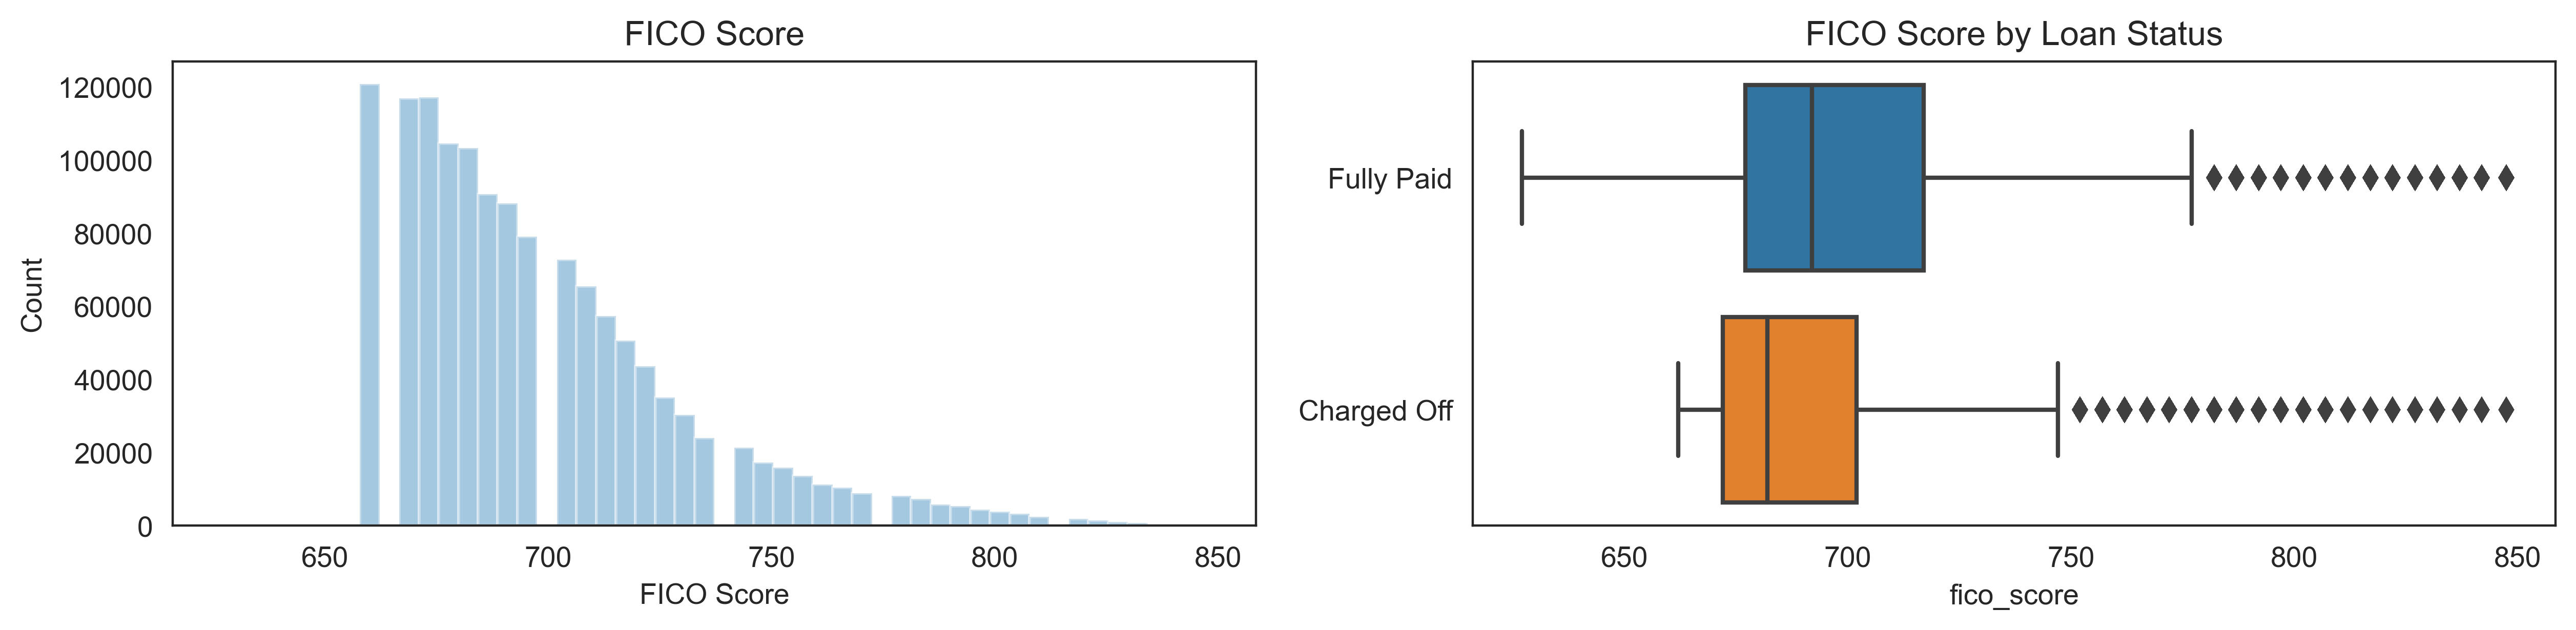

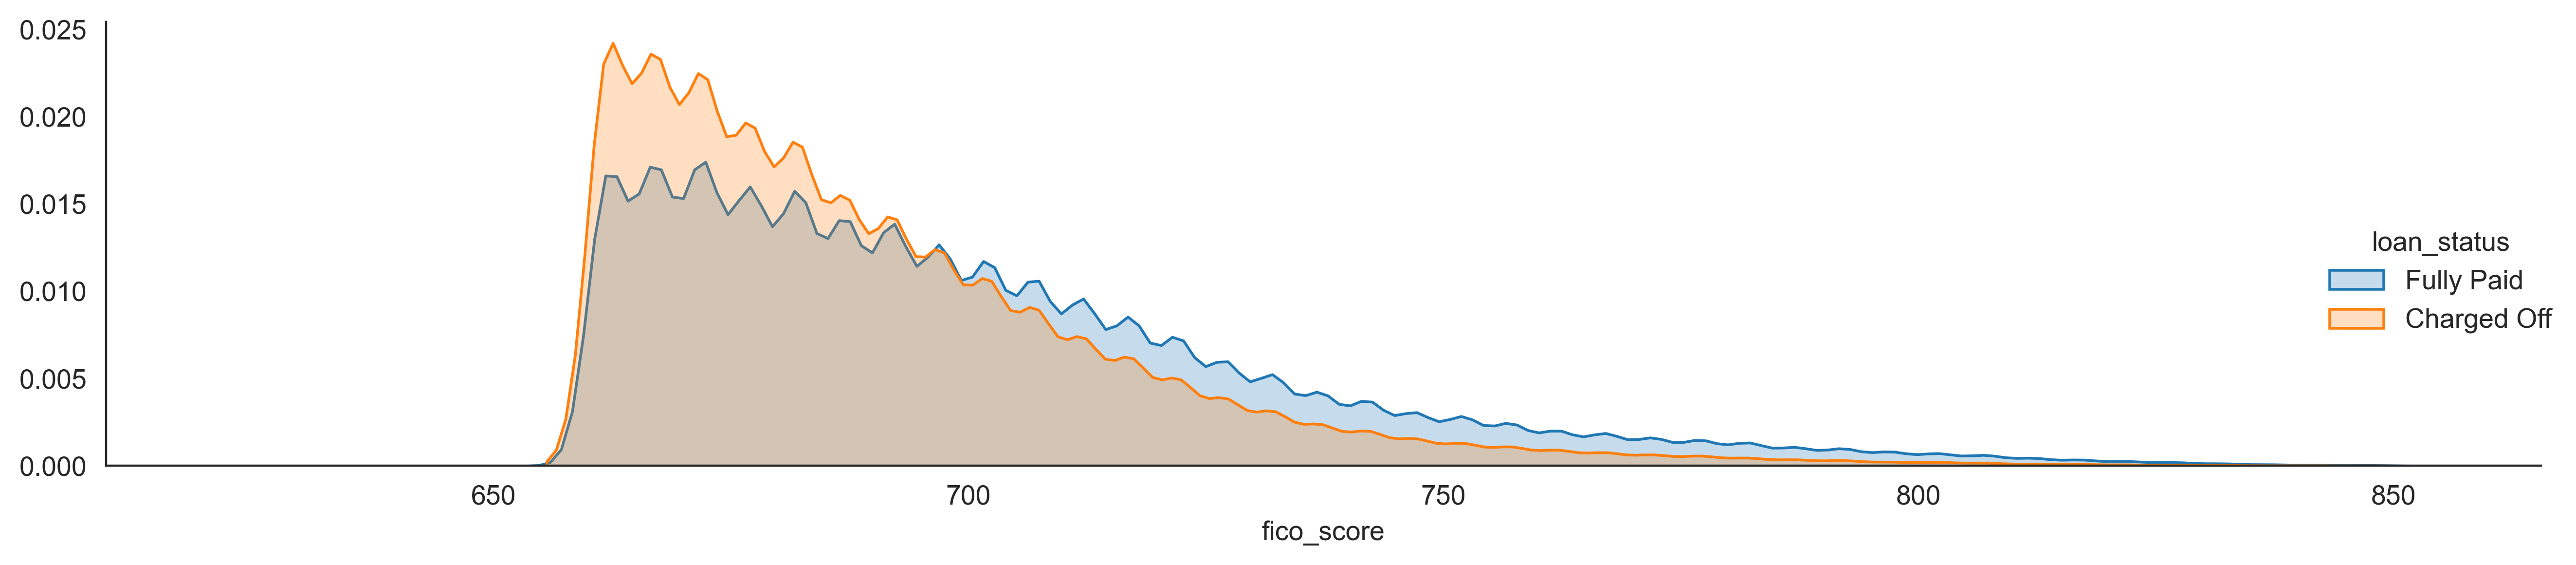

In [87]:
plot_func('fico_score', 'FICO Score', continuous=True)

Fully paid loans have significatly higher FICO scores compated the ones that are charged off.

As we have combined fico_low and fico_high into fico_score, we can drop them.

In [88]:
drop_cols(['fico_range_high','fico_range_low'])

### 15. Public Records

In [89]:
print(dict_df.loc['pub_rec'])
df['pub_rec'].describe()

Description    Number of derogatory public records
Name: pub_rec, dtype: object


count   1345310.00
mean          0.22
std           0.60
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          86.00
Name: pub_rec, dtype: float64

In [90]:
df.groupby('loan_status')['pub_rec'].describe()

count  mean  std  min  25%  50%  75%   max
loan_status                                                
Charged Off  268559.00  0.25 0.66 0.00 0.00 0.00 0.00 86.00
Fully Paid  1076751.00  0.21 0.59 0.00 0.00 0.00 0.00 63.00

In [91]:
df['pub_rec'].value_counts().sort_values(ascending=False)

0.00     1117425
1.00      190789
2.00       24435
3.00        7399
4.00        2630
5.00        1266
6.00         636
7.00         283
8.00         160
9.00          83
10.00         57
11.00         40
12.00         27
13.00         18
15.00          9
21.00          6
18.00          6
14.00          5
16.00          5
19.00          5
17.00          3
28.00          3
20.00          3
49.00          2
24.00          2
22.00          2
37.00          1
23.00          1
40.00          1
46.00          1
47.00          1
25.00          1
54.00          1
61.00          1
63.00          1
86.00          1
34.00          1
Name: pub_rec, dtype: int64

Let's group the lower values into one bin as there are too many public records with only one occurrence.

In [92]:
df.pub_rec = df.pub_rec.map(lambda x: 3 if x >2.0 else x)

In [93]:
df['pub_rec'].value_counts().sort_values(ascending=False)

0.00    1117425
1.00     190789
2.00      24435
3.00      12661
Name: pub_rec, dtype: int64

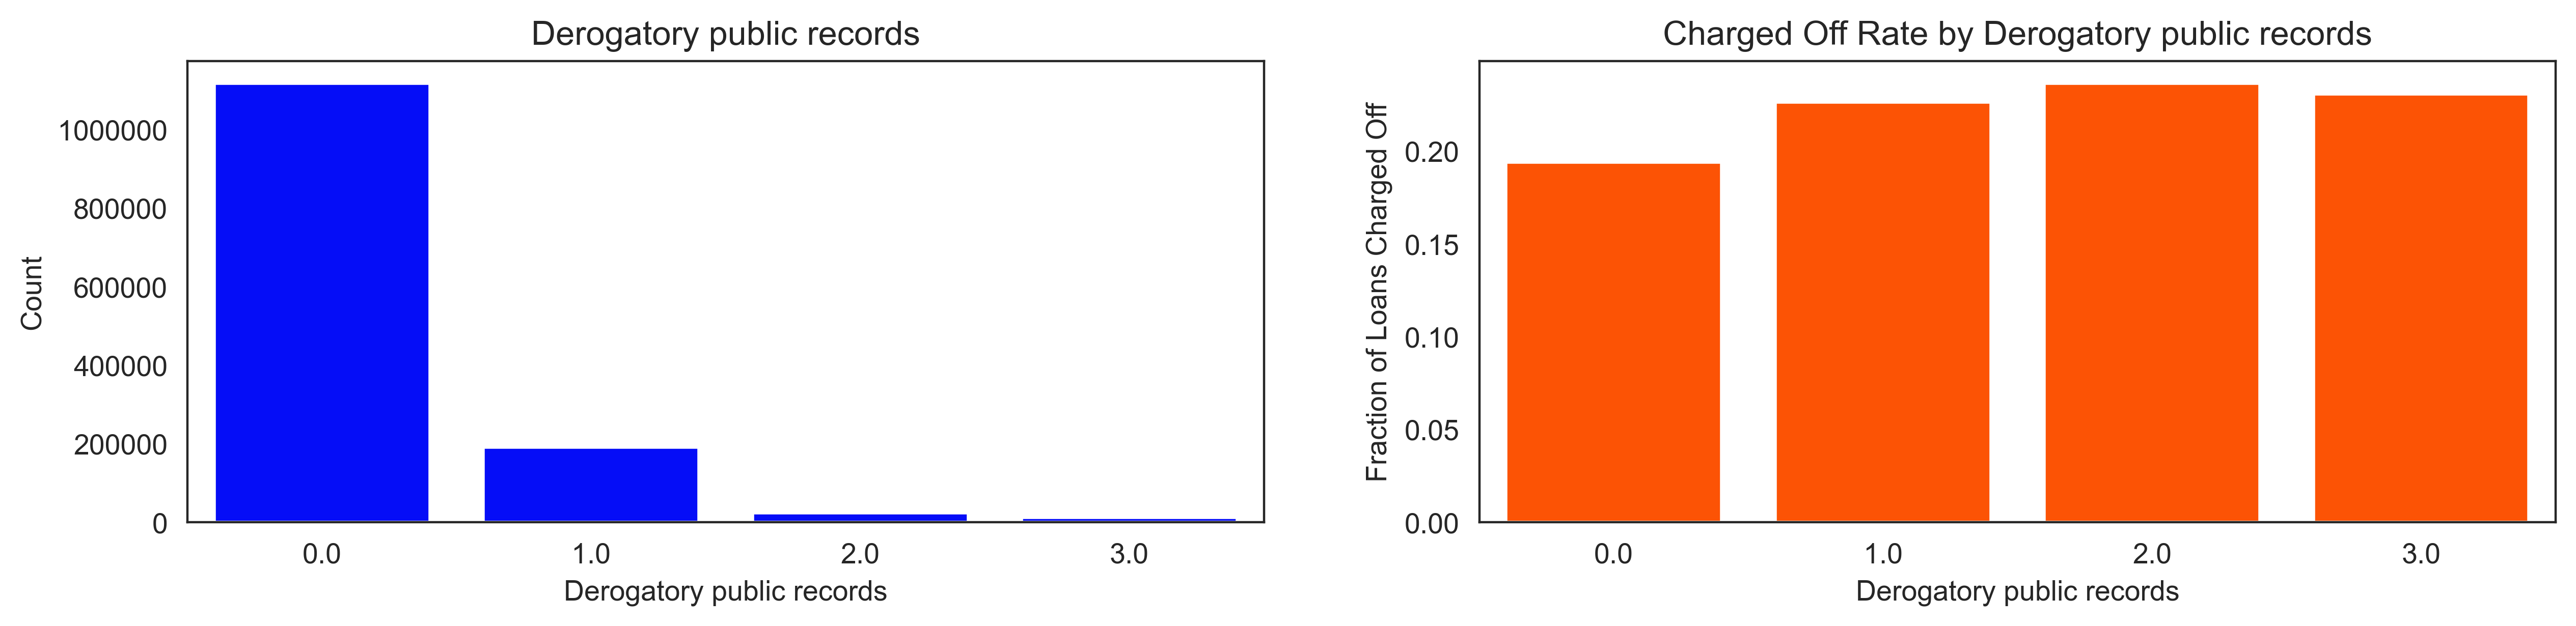

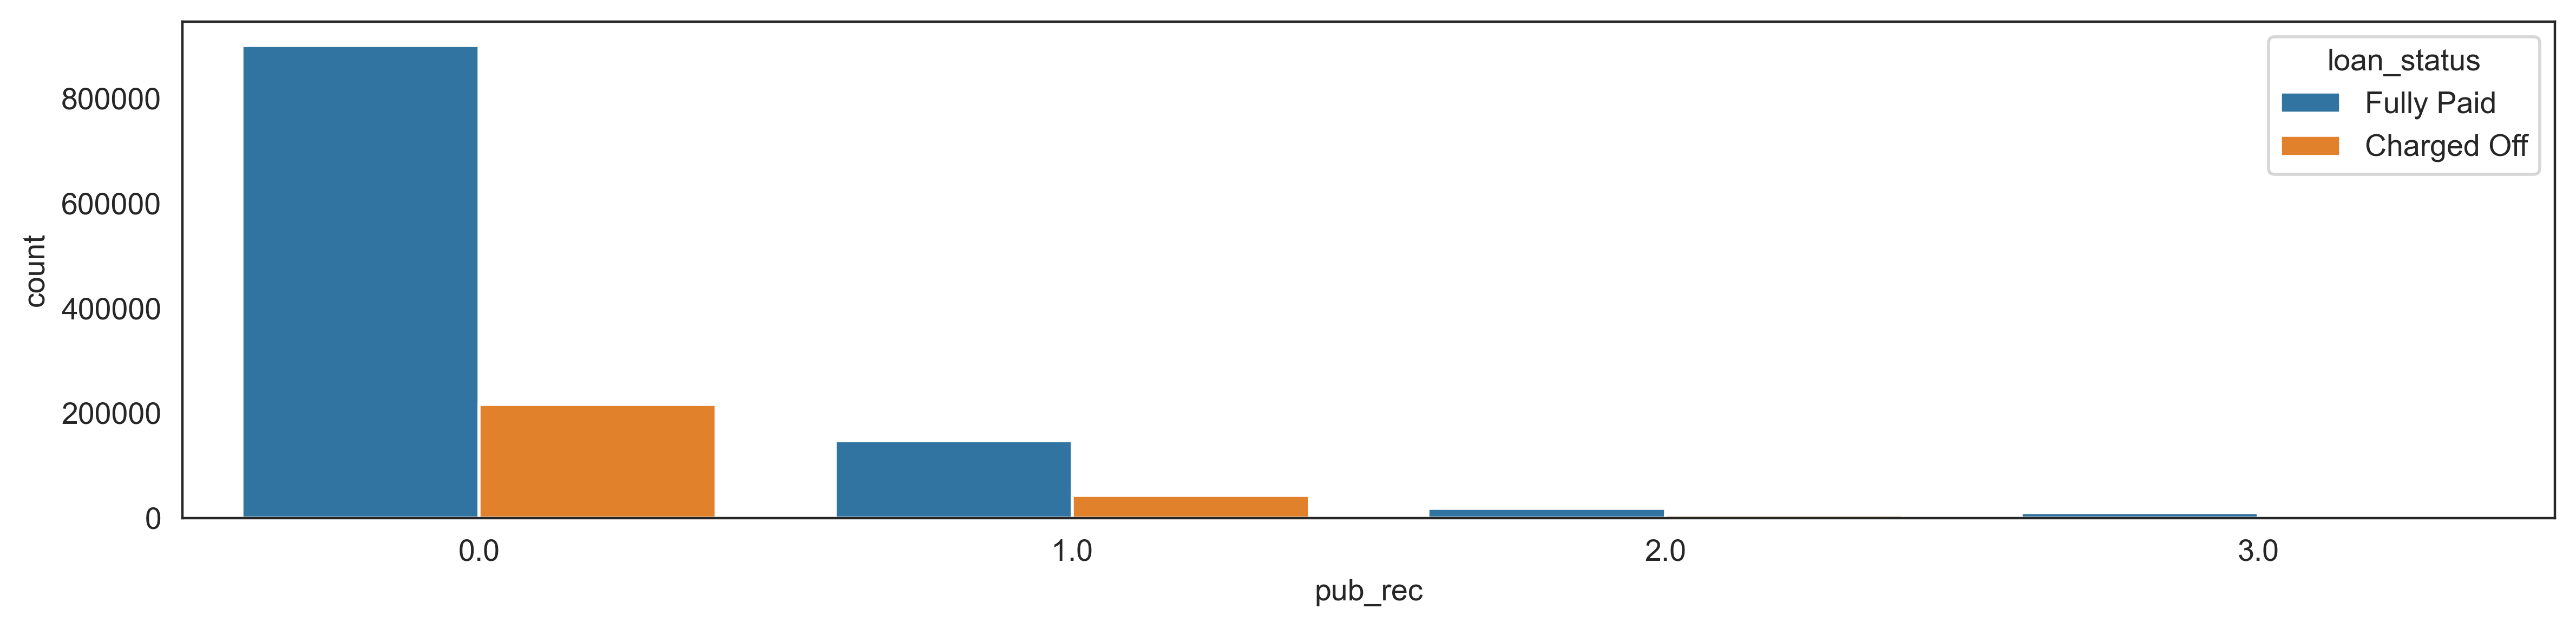

In [94]:
plot_func('pub_rec','Derogatory public records', continuous=False)

Most of the loans have zero public records. Looks like the loans with public records higher than 0 have higher percentage of charge off loans.

### 16. Number of Bankruptcies

In [95]:
print(dict_df.loc['pub_rec_bankruptcies'])

Description    Number of public record bankruptcies
Name: pub_rec_bankruptcies, dtype: object


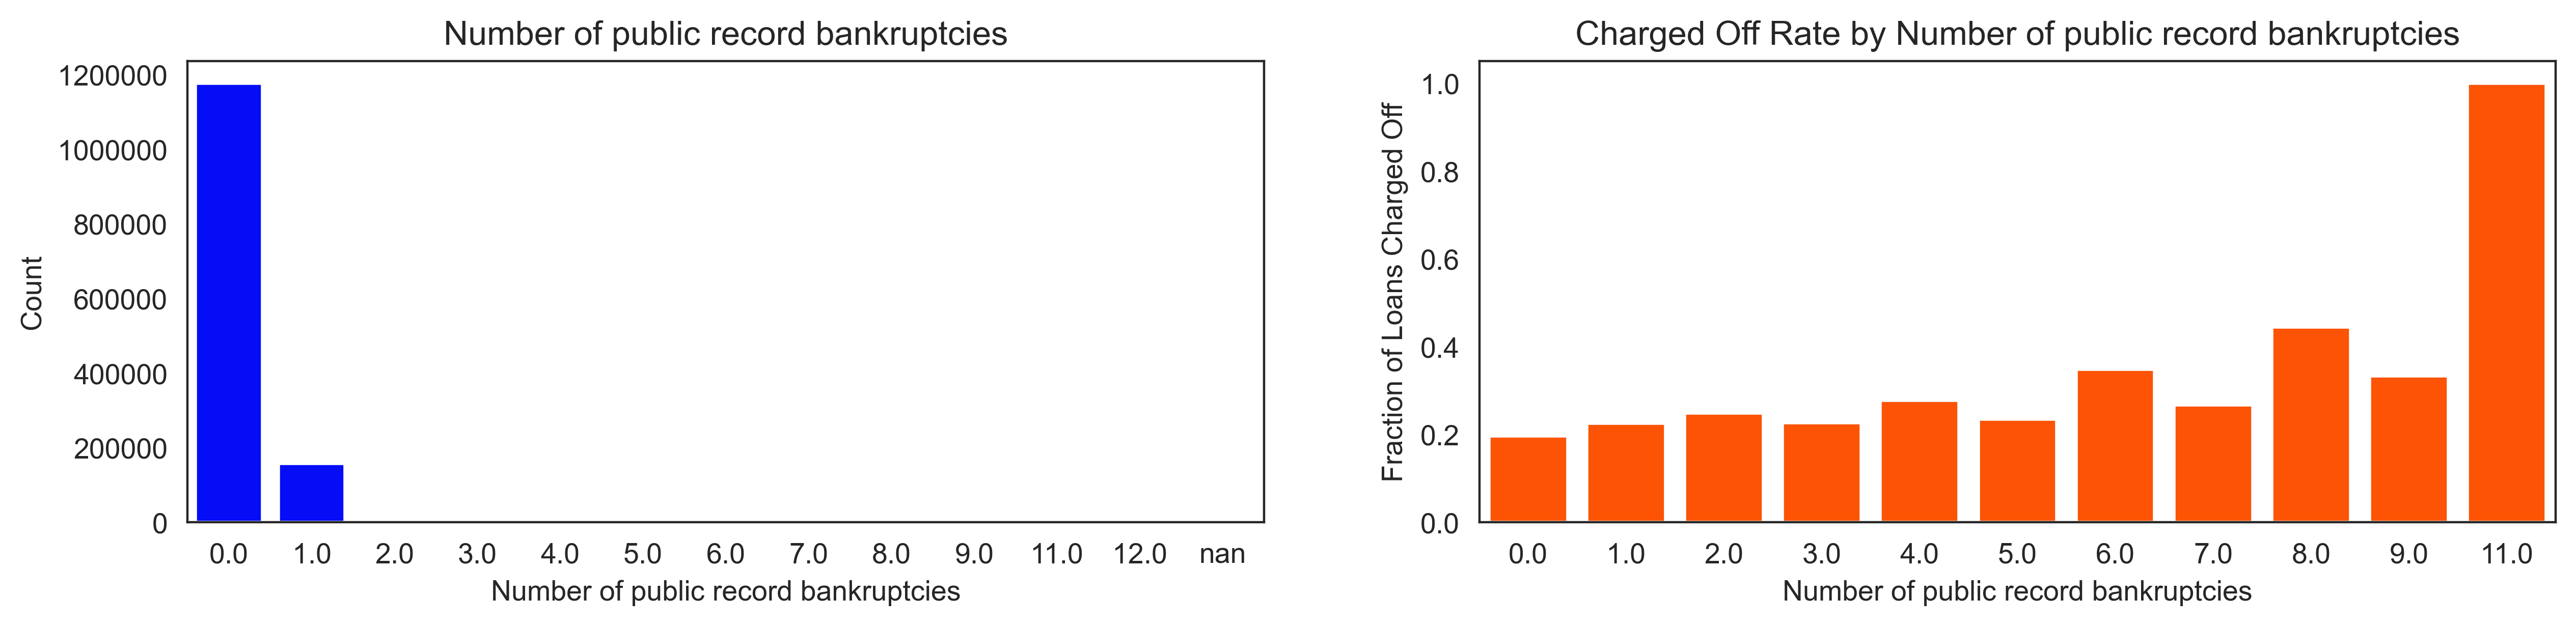

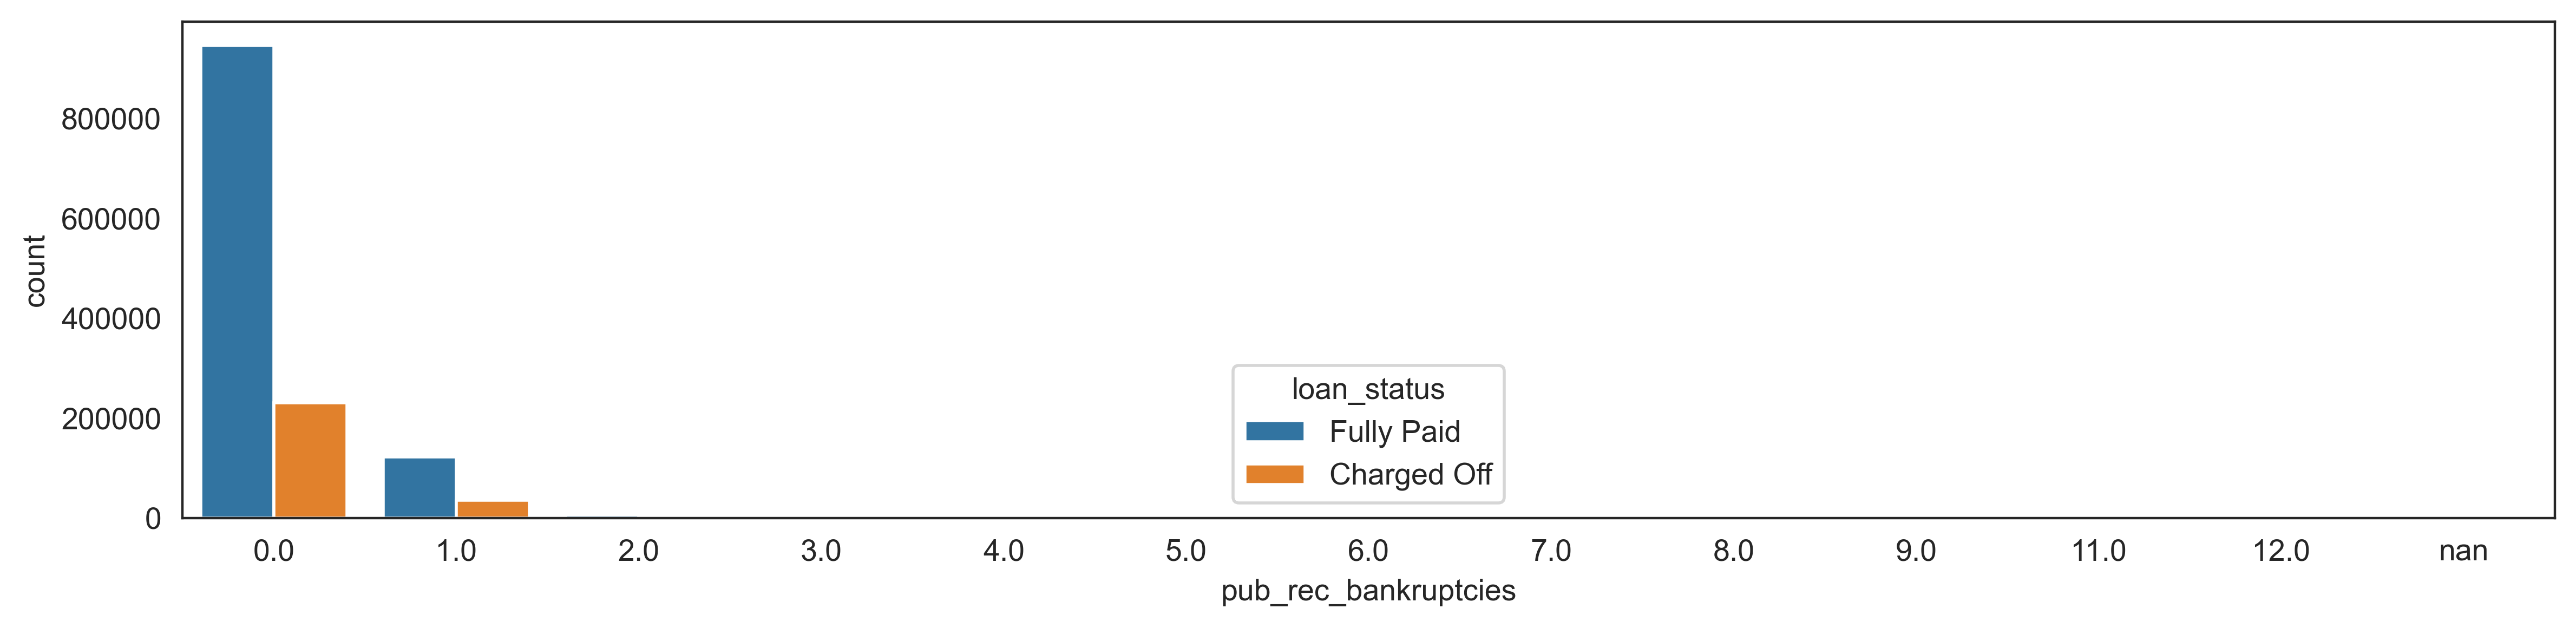

In [96]:
plot_func('pub_rec_bankruptcies', 'Number of public record bankruptcies', continuous=False)

It is clearly visible that higher the public bankruptcies, higher the charge-off rate.

### 17. Revolving Balance

In [97]:
print(dict_df.loc['revol_bal'])
df['revol_bal'].describe()

Description    Total credit revolving balance
Name: revol_bal, dtype: object


count   1345310.00
mean      16248.11
std       22328.17
min           0.00
25%        5943.00
50%       11134.00
75%       19755.75
max     2904836.00
Name: revol_bal, dtype: float64

The range is high for revolving balance. So let's use log values instead.

In [98]:
df['revol_bal'] = df['revol_bal'].apply(lambda x:np.log10(x+1))

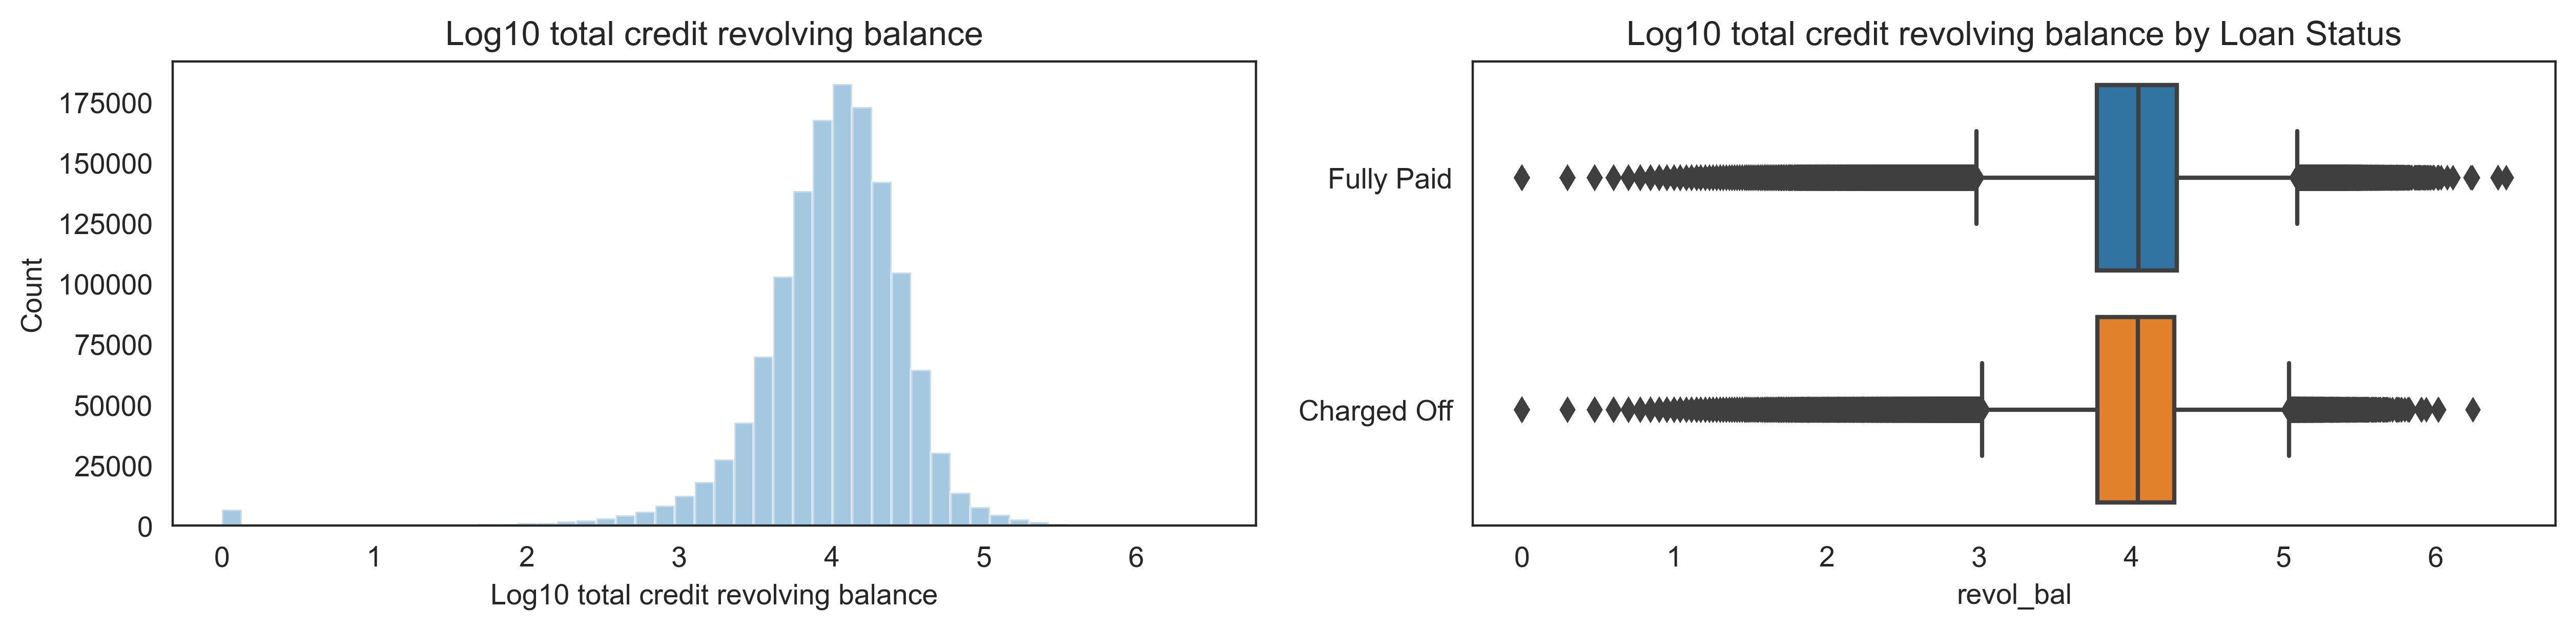

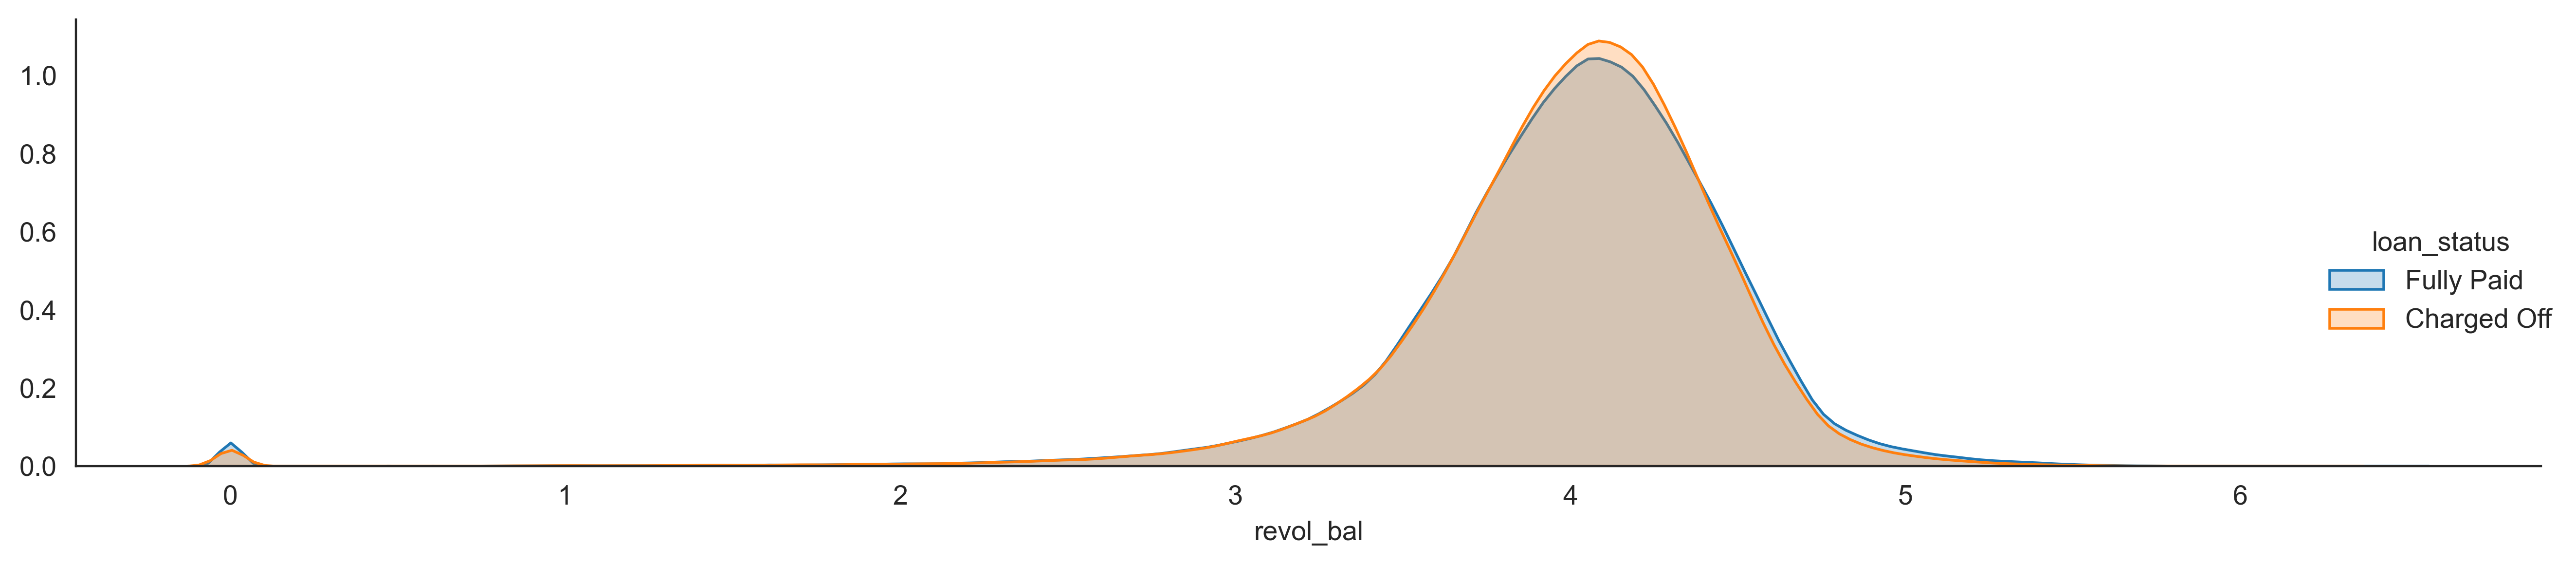

In [99]:
plot_func('revol_bal', 'Log10 total credit revolving balance', continuous=True)

### 18. Revolving utilization rate

In [100]:
print(dict_df.loc['revol_util'])
df['revol_util'].describe()

Description    Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
Name: revol_util, dtype: object


count   1344453.00
mean         51.81
std          24.52
min           0.00
25%          33.40
50%          52.20
75%          70.70
max         892.30
Name: revol_util, dtype: float64

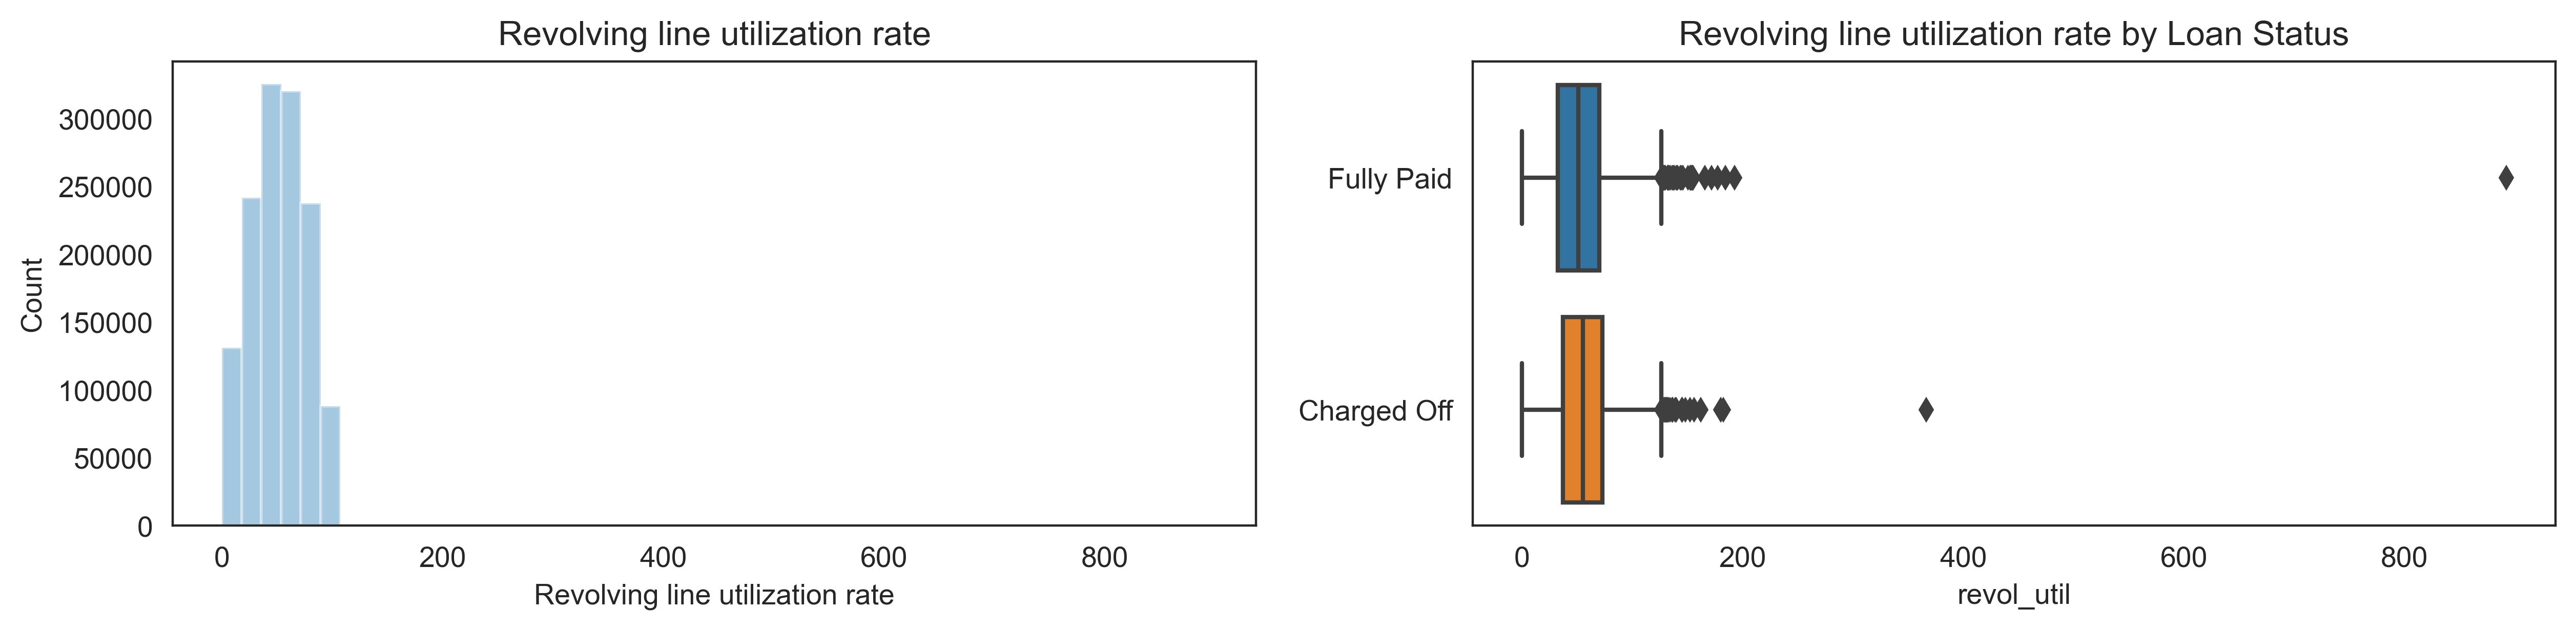

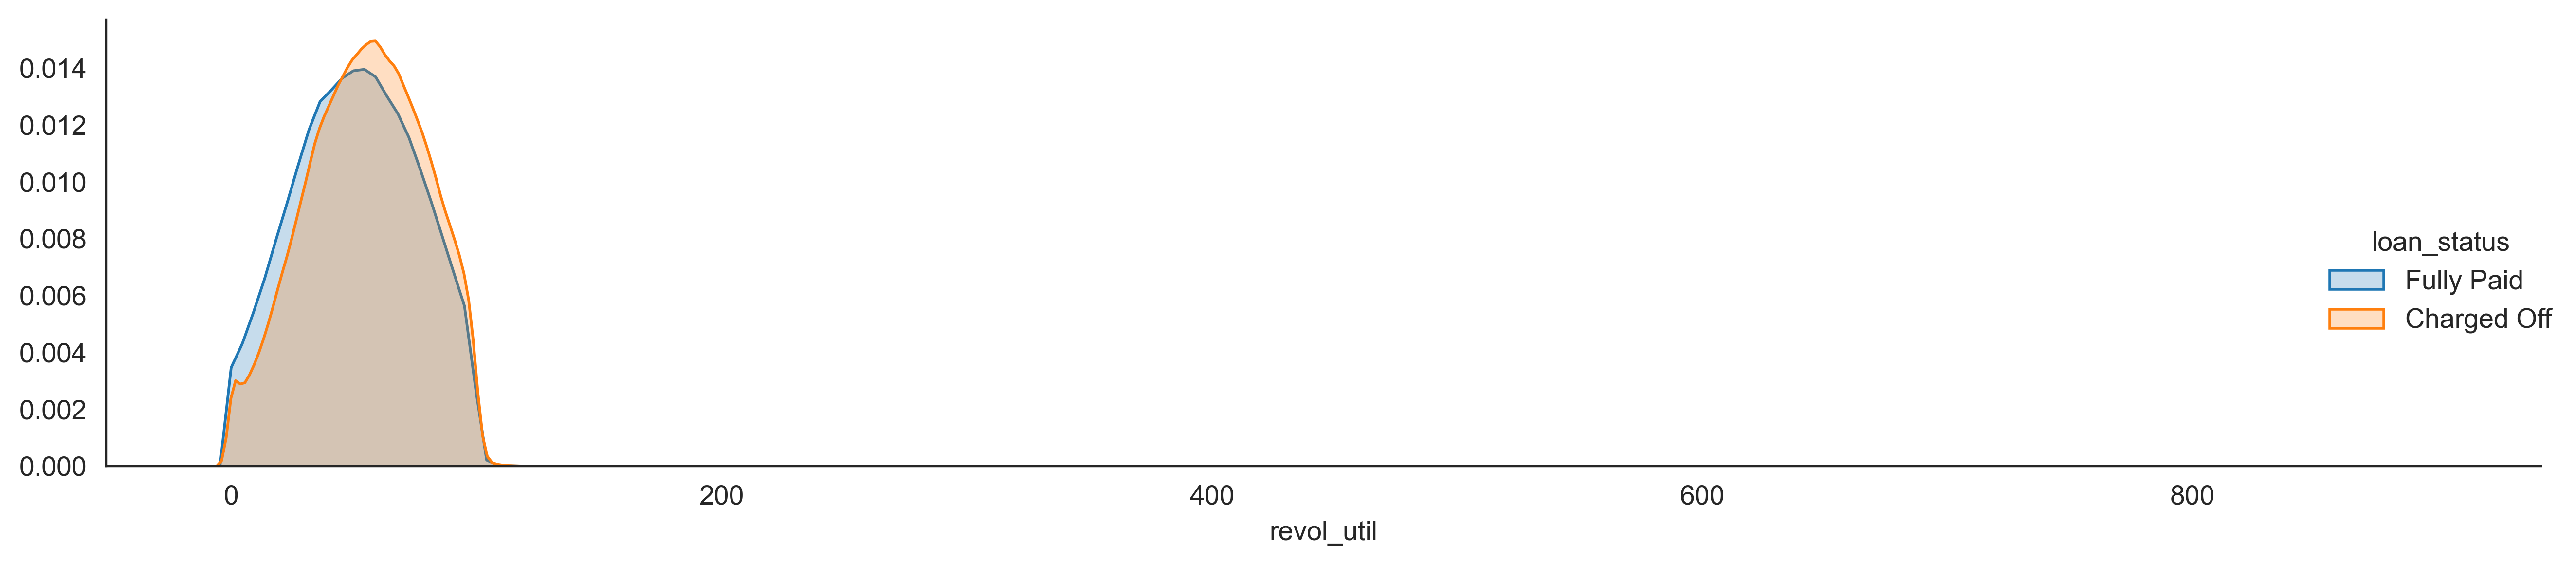

In [101]:
plot_func('revol_util', 'Revolving line utilization rate', continuous=True)

In [102]:
df.groupby('loan_status')['revol_util'].describe()

count  mean   std  min   25%   50%   75%    max
loan_status                                                     
Charged Off  268379.00 54.76 23.87 0.00 37.40 55.50 73.10 366.60
Fully Paid  1076074.00 51.07 24.63 0.00 32.50 51.30 70.10 892.30

Charged off loans have higher revolving utilization rate compared to fully paid loans. 

### 19. Total number of accounts

In [103]:
print(dict_df.loc['total_acc'])
df['total_acc'].describe()

Description    The total number of credit lines currently in the borrower's credit file
Name: total_acc, dtype: object


count   1345310.00
mean         24.98
std          12.00
min           2.00
25%          16.00
50%          23.00
75%          32.00
max         176.00
Name: total_acc, dtype: float64

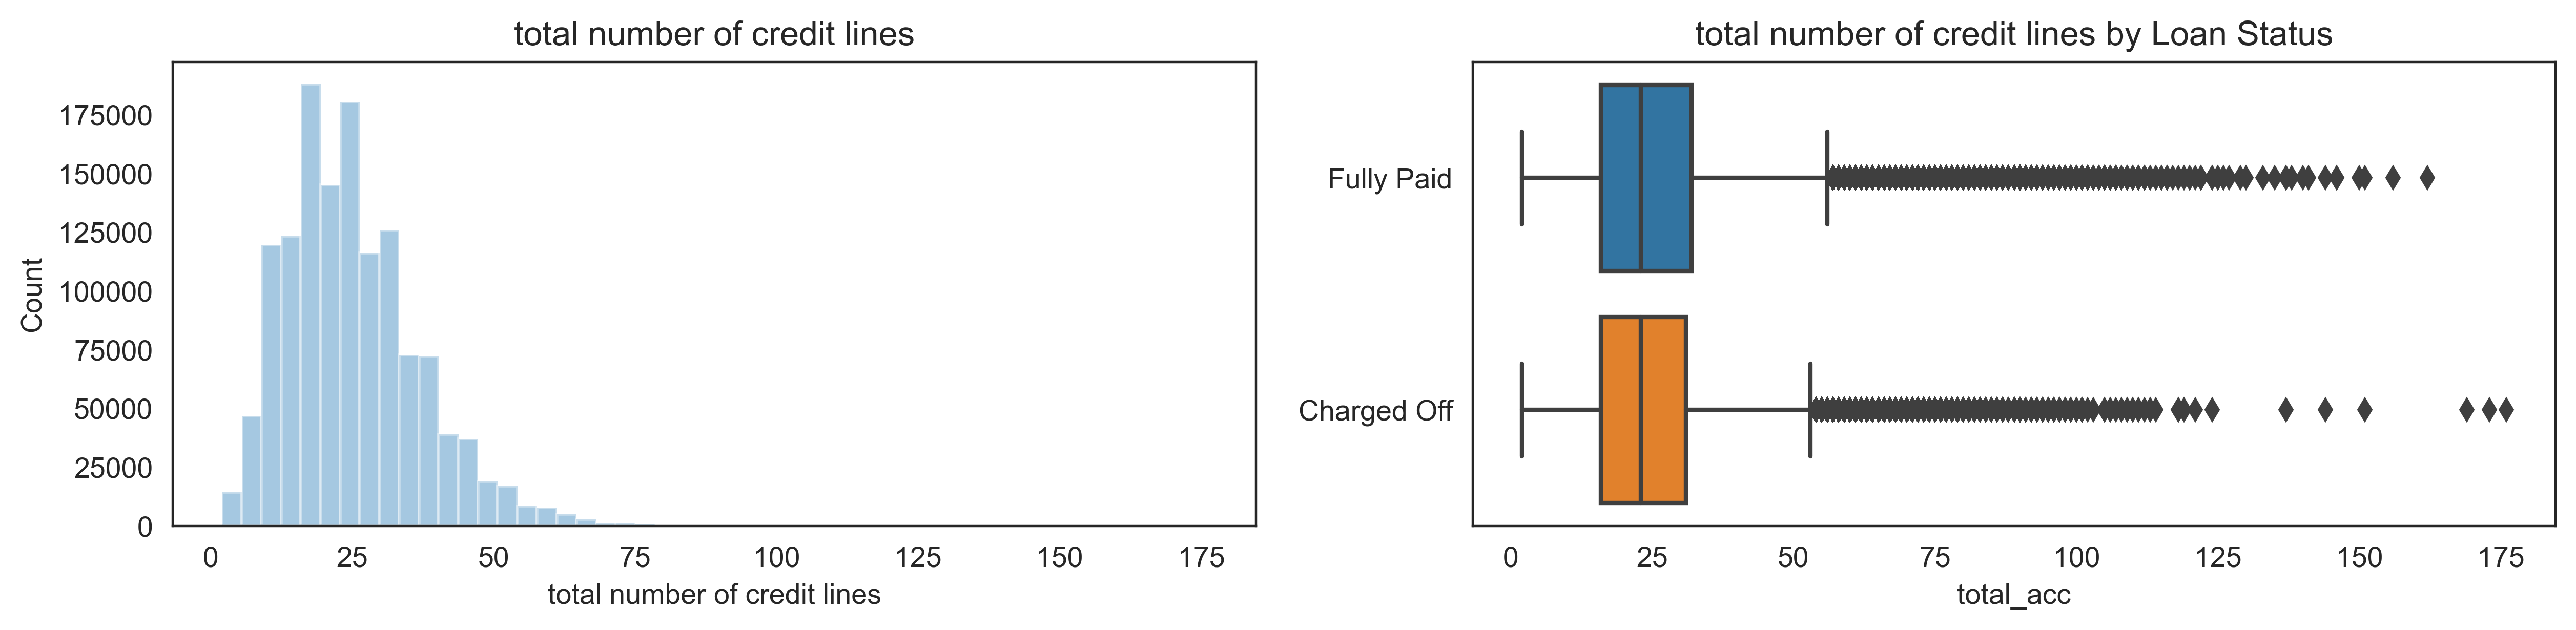

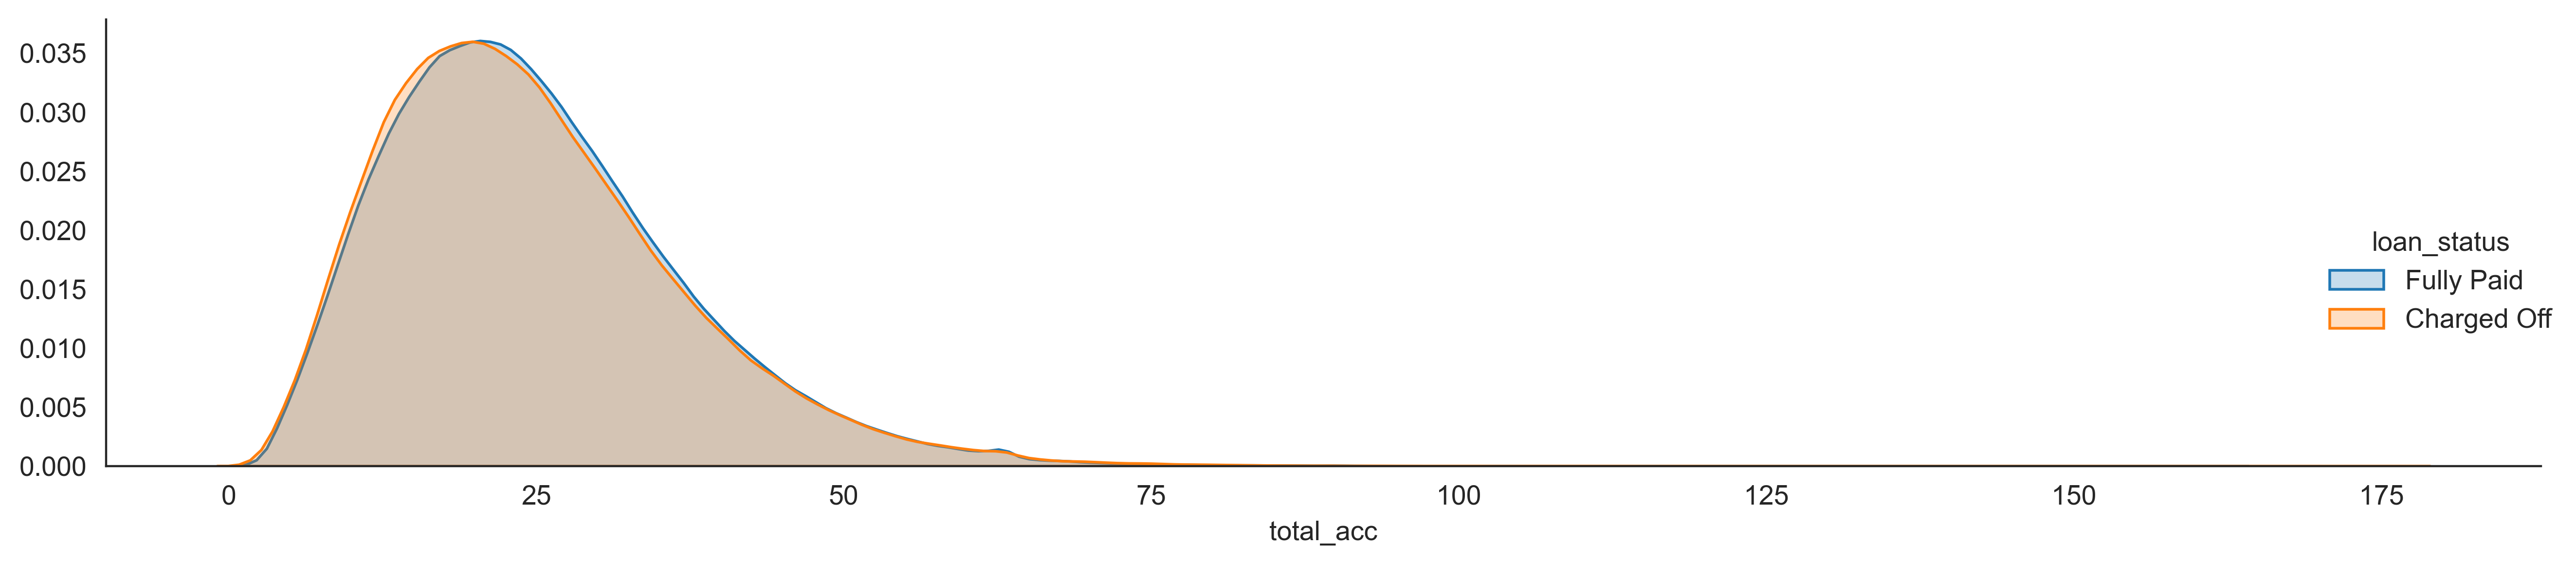

In [104]:
plot_func('total_acc', 'total number of credit lines', continuous=True)

### 20. Initial List Status

In [105]:
print(dict_df.loc['initial_list_status'])
df['initial_list_status'].value_counts()

Description    The initial listing status of the loan. Possible values are – W, F
Name: initial_list_status, dtype: object


w    784010
f    561300
Name: initial_list_status, dtype: int64

Whole amount loans count is higher than fractional amount

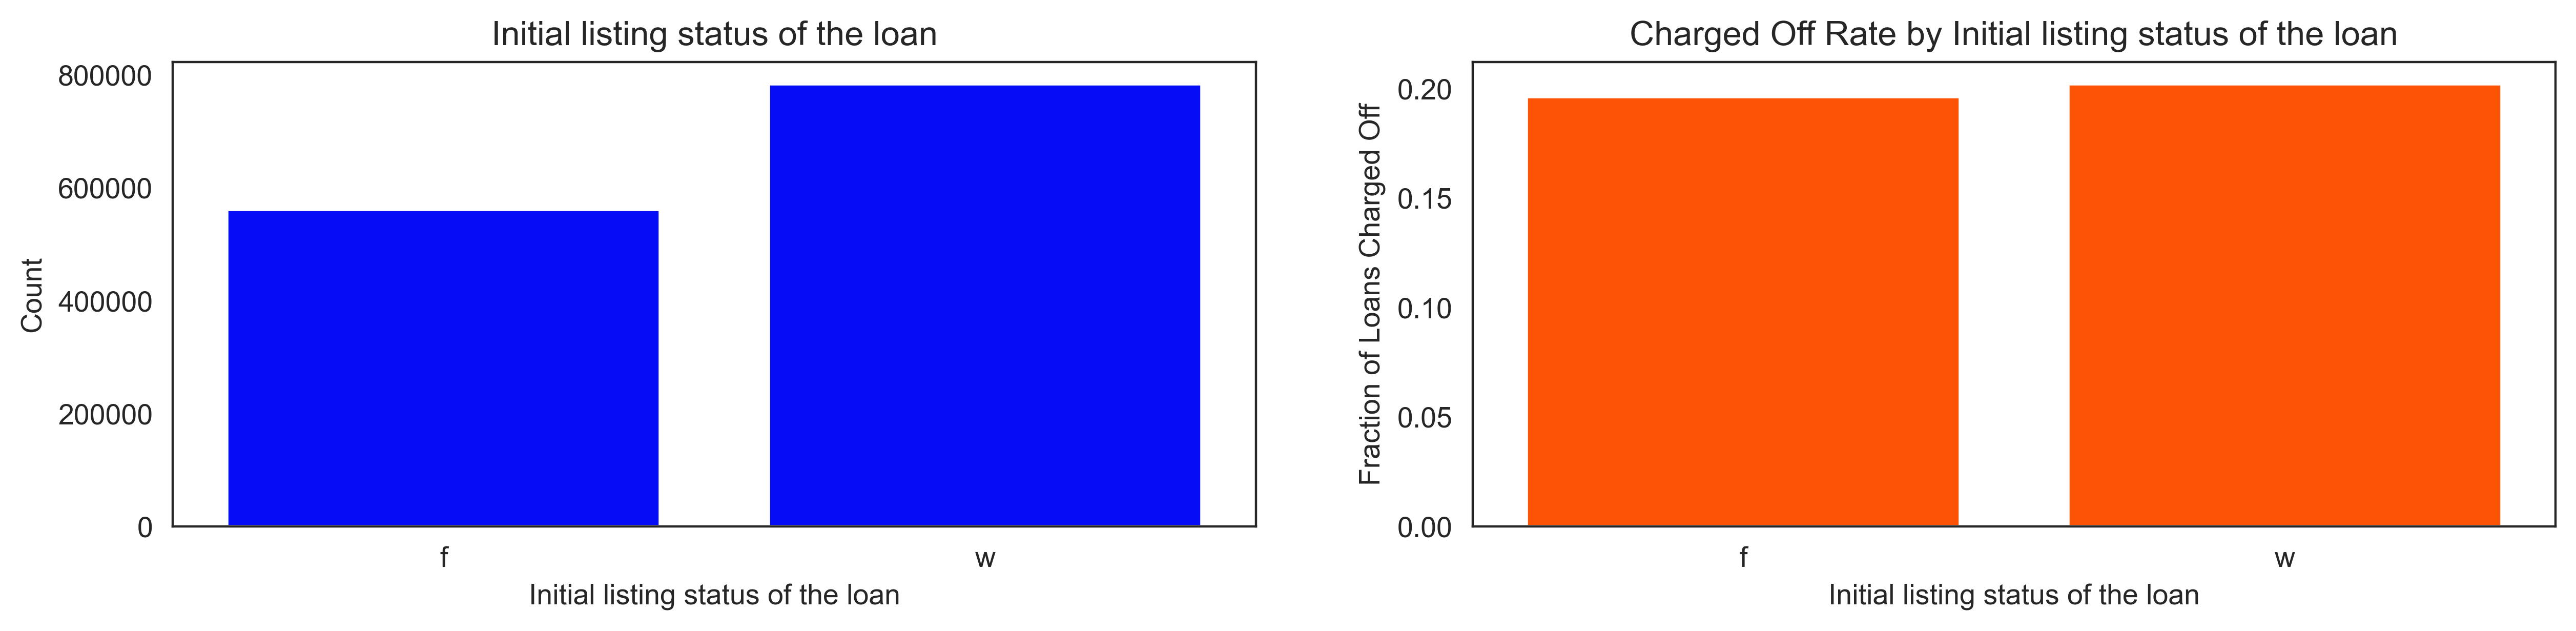

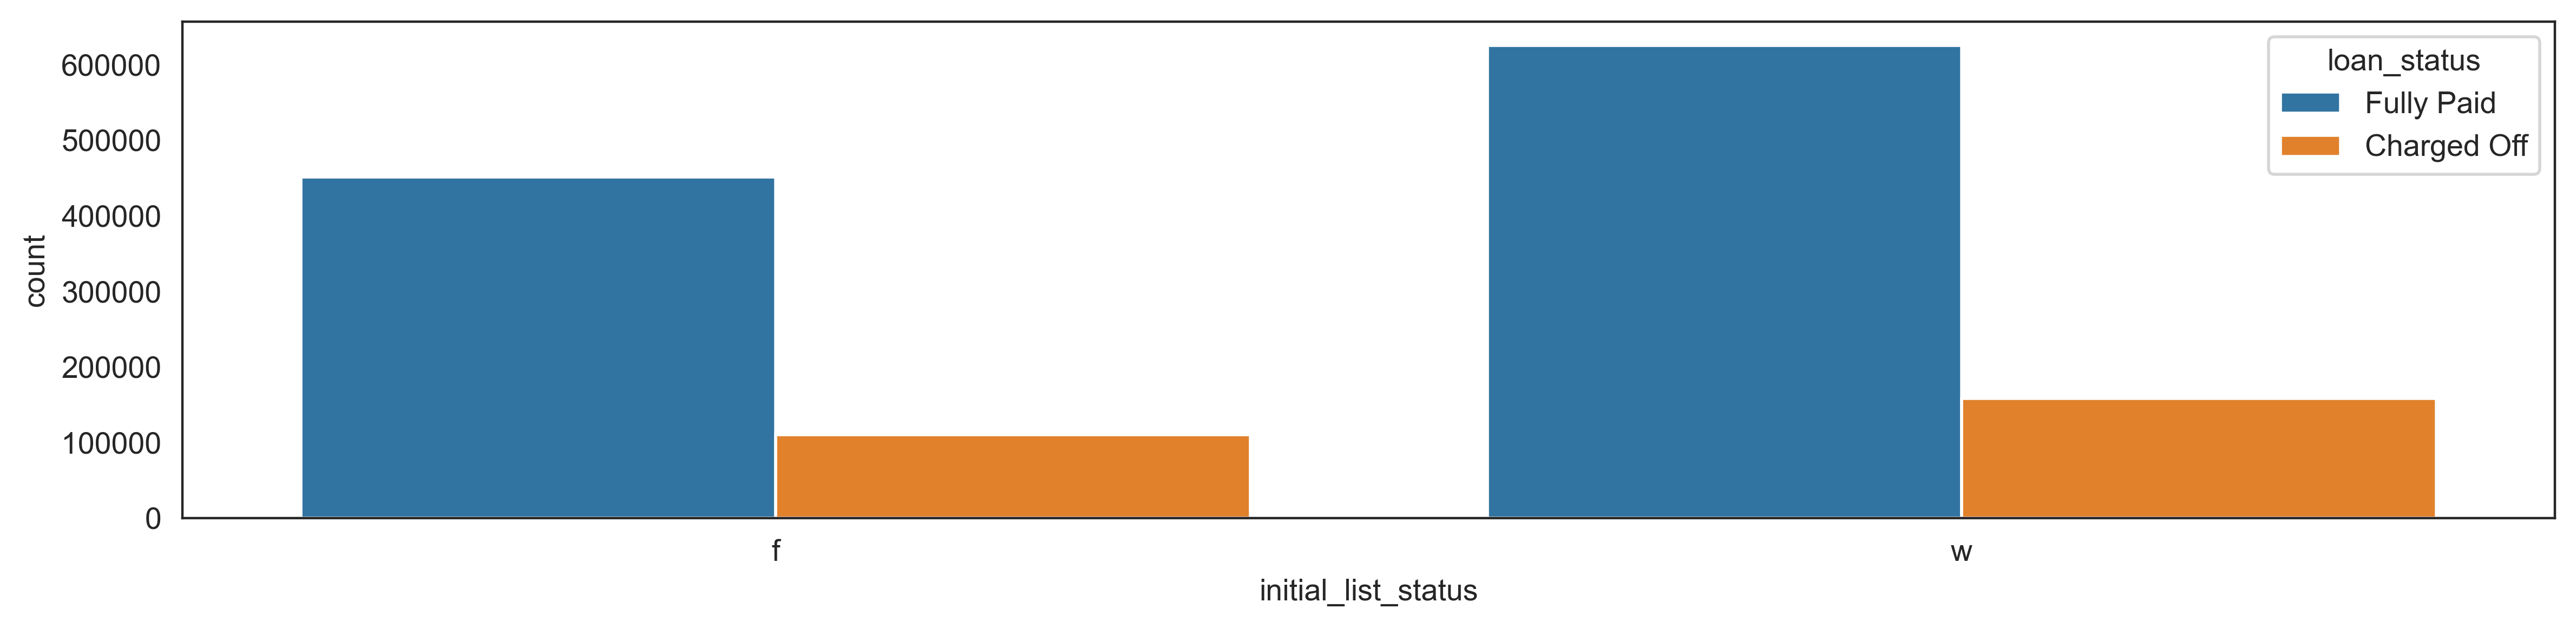

In [106]:
plot_func('initial_list_status','Initial listing status of the loan', continuous=False)

whole has slightly higher rate of charge off 

### 21. Policy Code

In [107]:
print(dict_df.loc['policy_code'])
df['policy_code'].value_counts()

Description    publicly available policy_code=1\nnew products not publicly available policy_code=2
Name: policy_code, dtype: object


1.00    1345310
Name: policy_code, dtype: int64

There is only one categoy. We can drop this column

In [108]:
drop_cols('policy_code')

### 22. Application Type : Single or Joint

In [109]:
print(dict_df.loc['application_type'])
df['application_type'].value_counts()

Description    Indicates whether the loan is an individual application or a joint application with two co-borrowers
Name: application_type, dtype: object


Individual    1319510
Joint App       25800
Name: application_type, dtype: int64

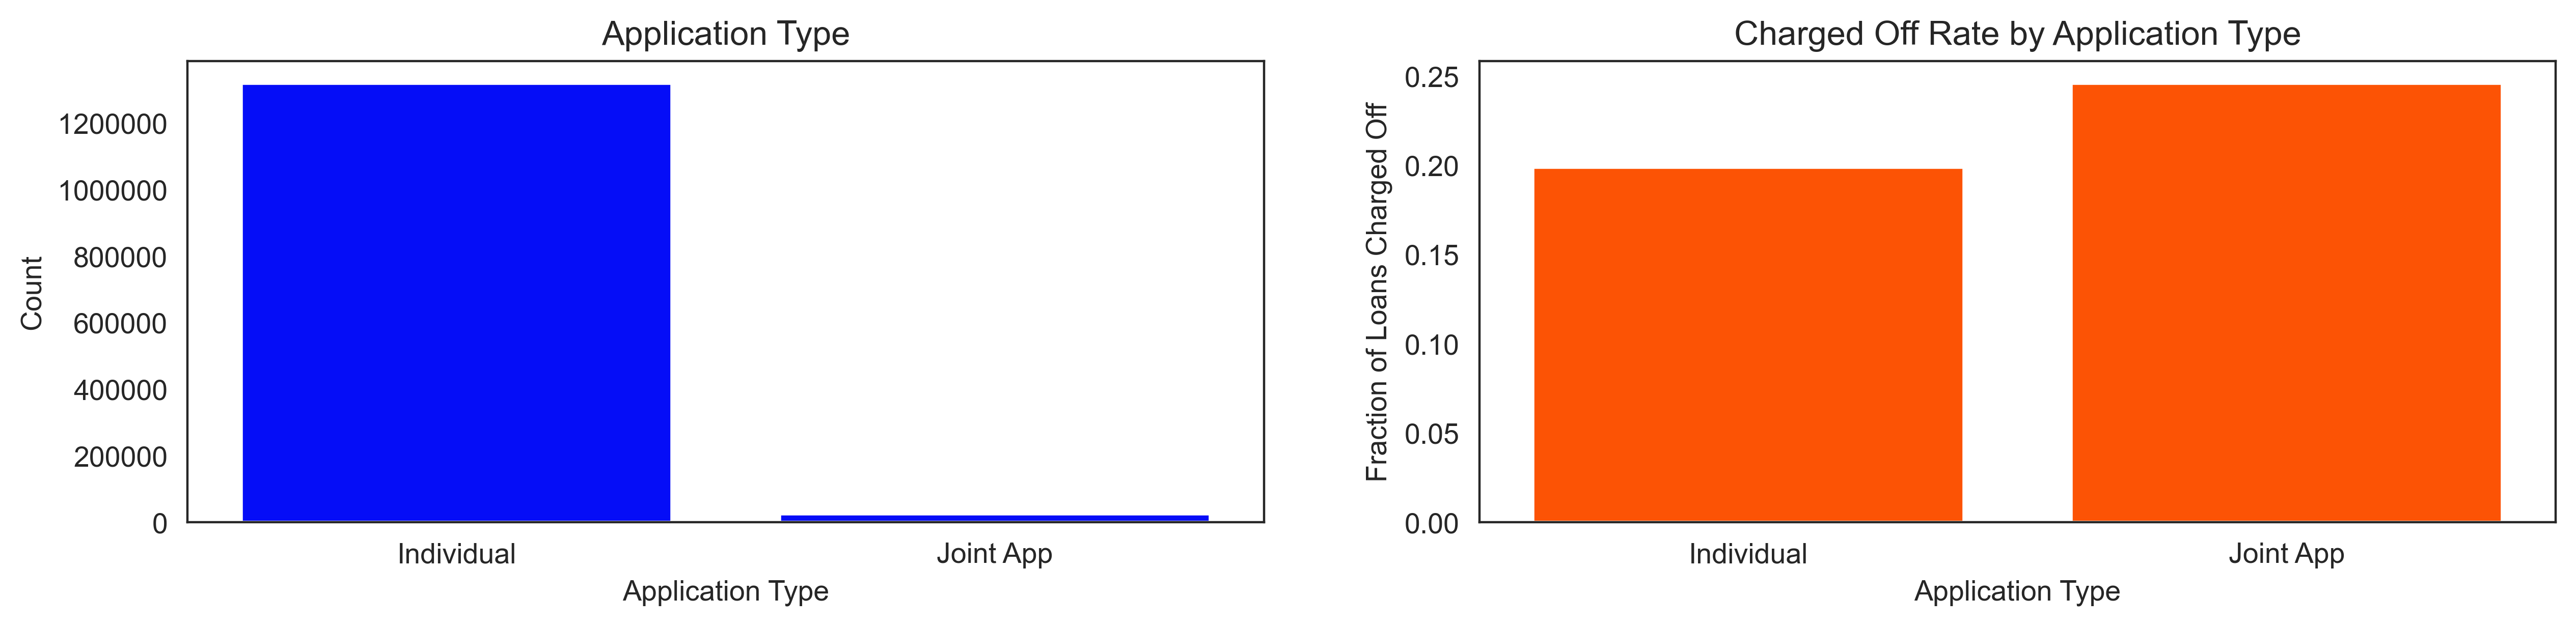

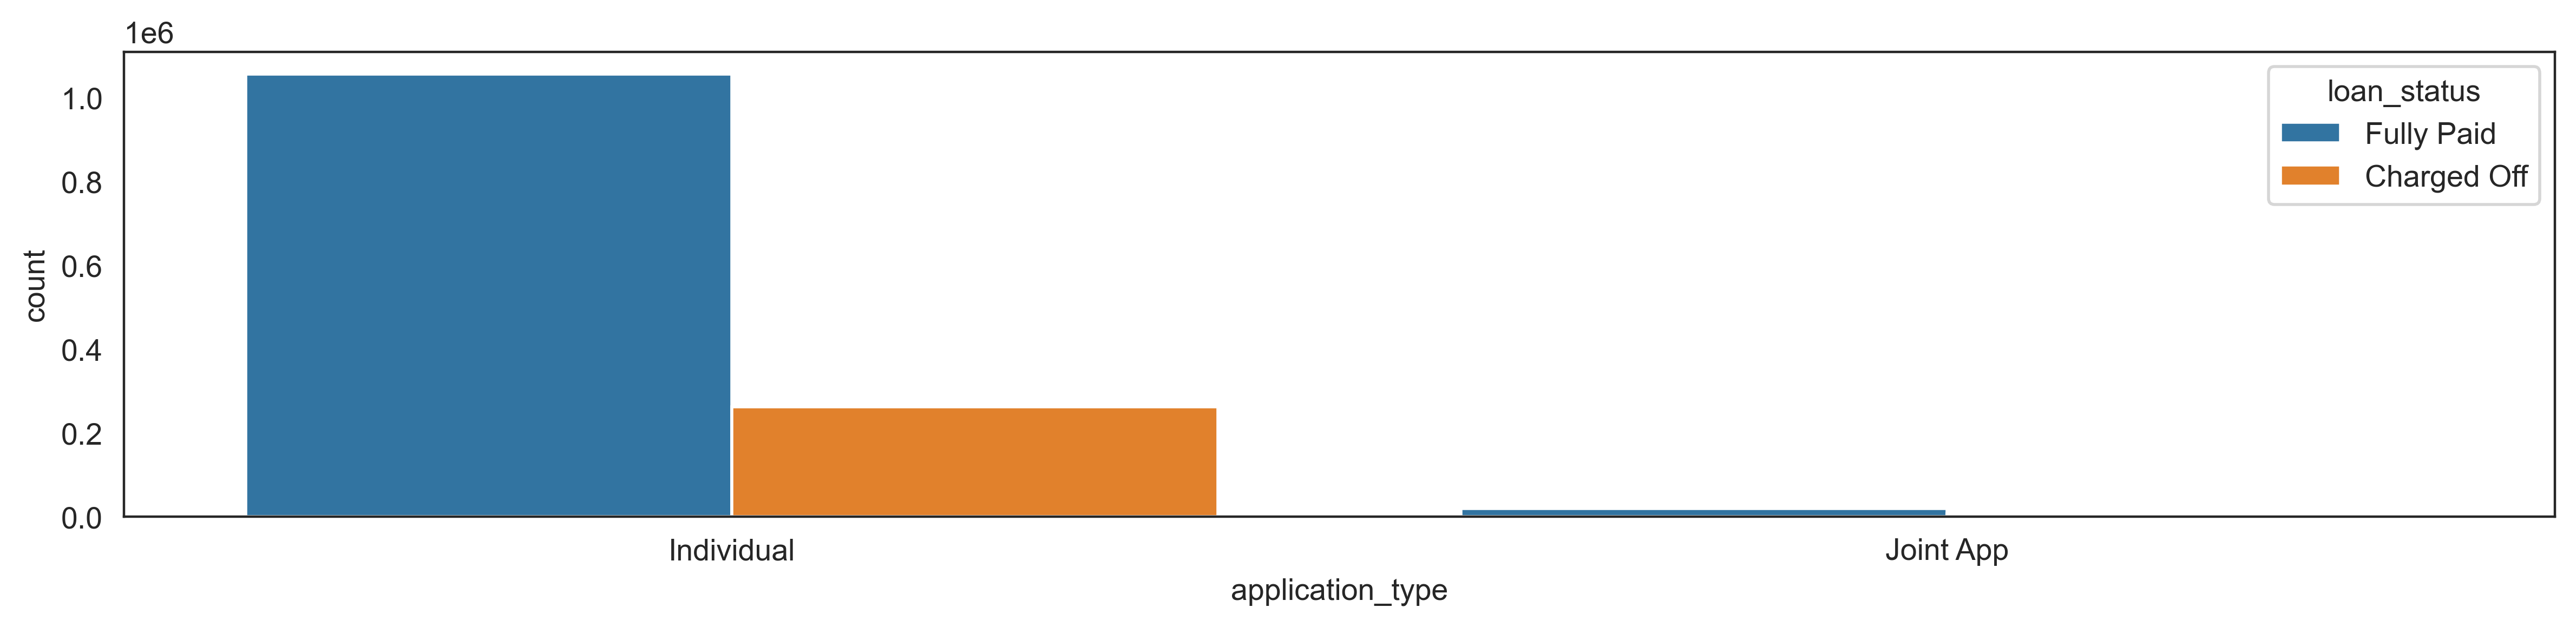

In [110]:
plot_func('application_type', 'Application Type', continuous=False)

98% are individual loans. But still joint applications have higher charge off rate.

### 23. Months since oldest bank installment account opened

In [111]:
df['mo_sin_old_il_acct'].describe()

count   1239735.00
mean        125.80
std          52.23
min           0.00
25%          98.00
50%         129.00
75%         152.00
max         999.00
Name: mo_sin_old_il_acct, dtype: float64

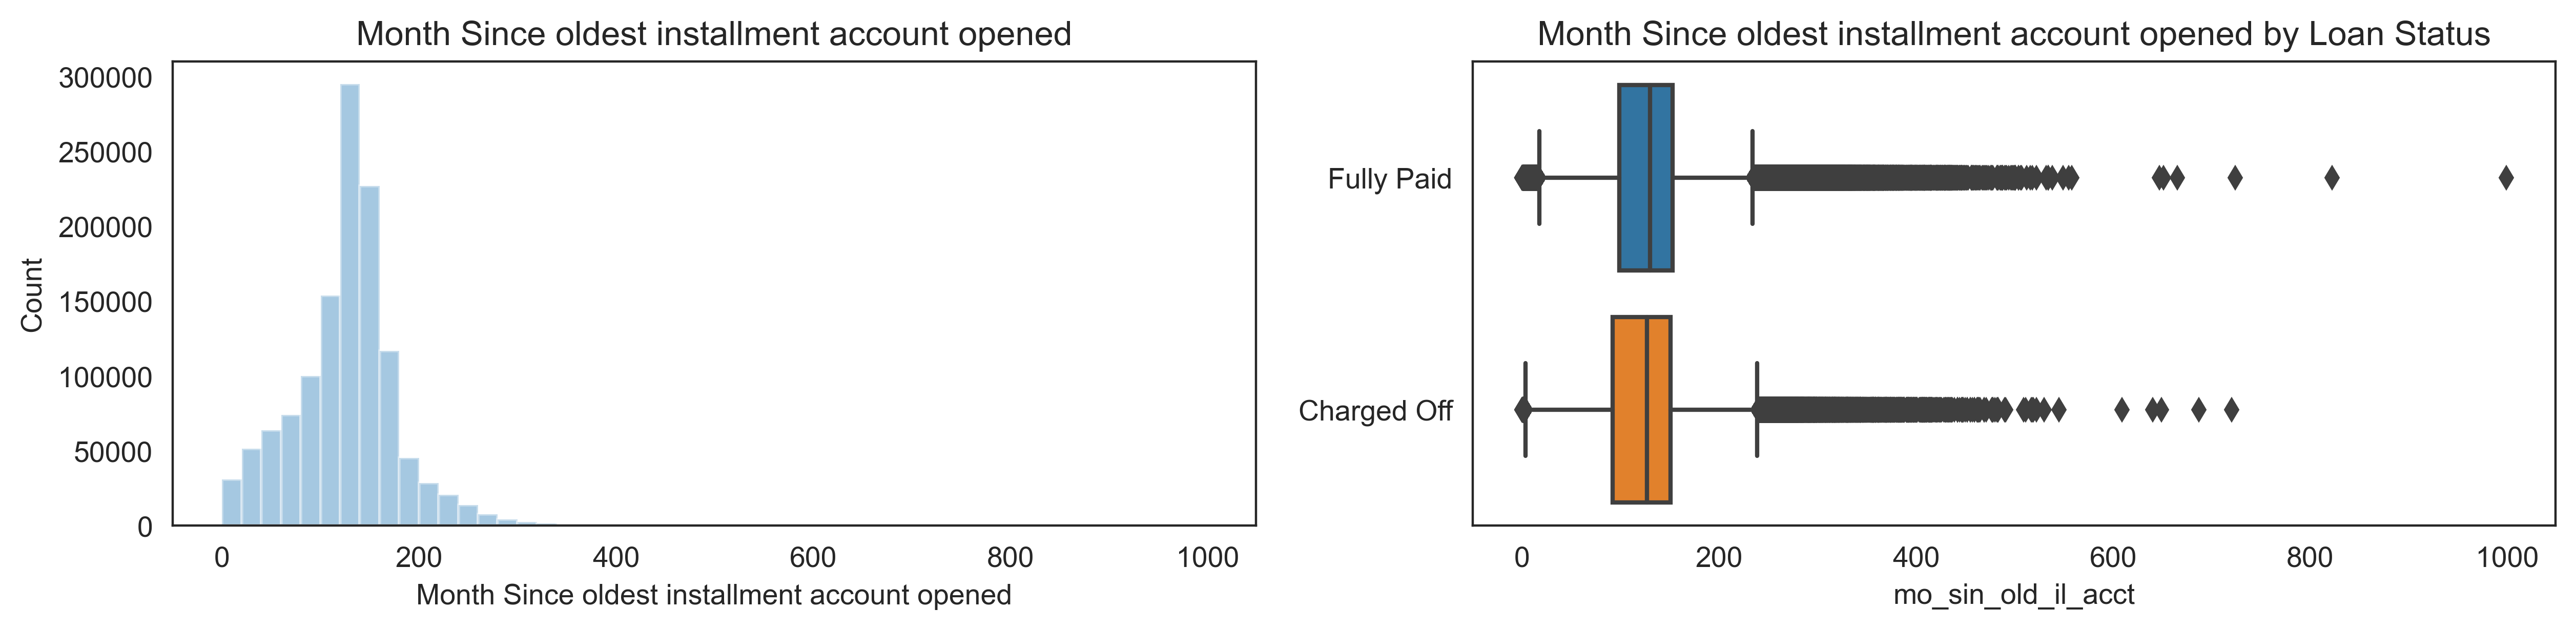

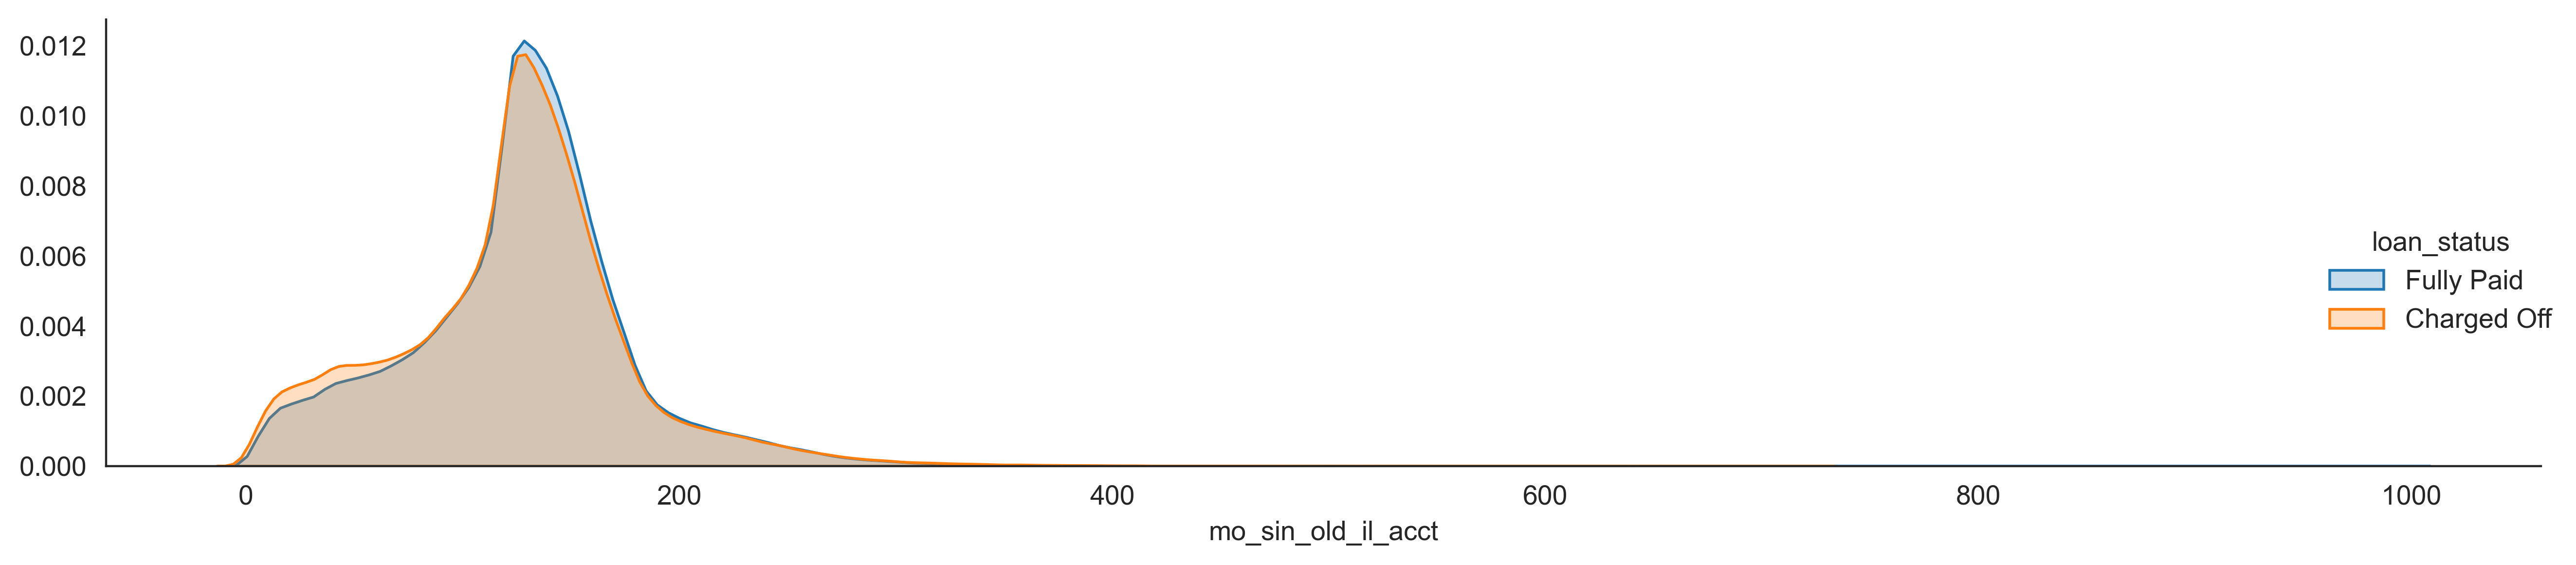

In [112]:
plot_func('mo_sin_old_il_acct', 'Month Since oldest installment account opened', continuous=True)

### 24. Months since oldest revolving account opened

In [113]:
df['mo_sin_old_rev_tl_op'].describe()

count   1277782.00
mean        181.48
std          94.51
min           2.00
25%         117.00
50%         164.00
75%         230.00
max         852.00
Name: mo_sin_old_rev_tl_op, dtype: float64

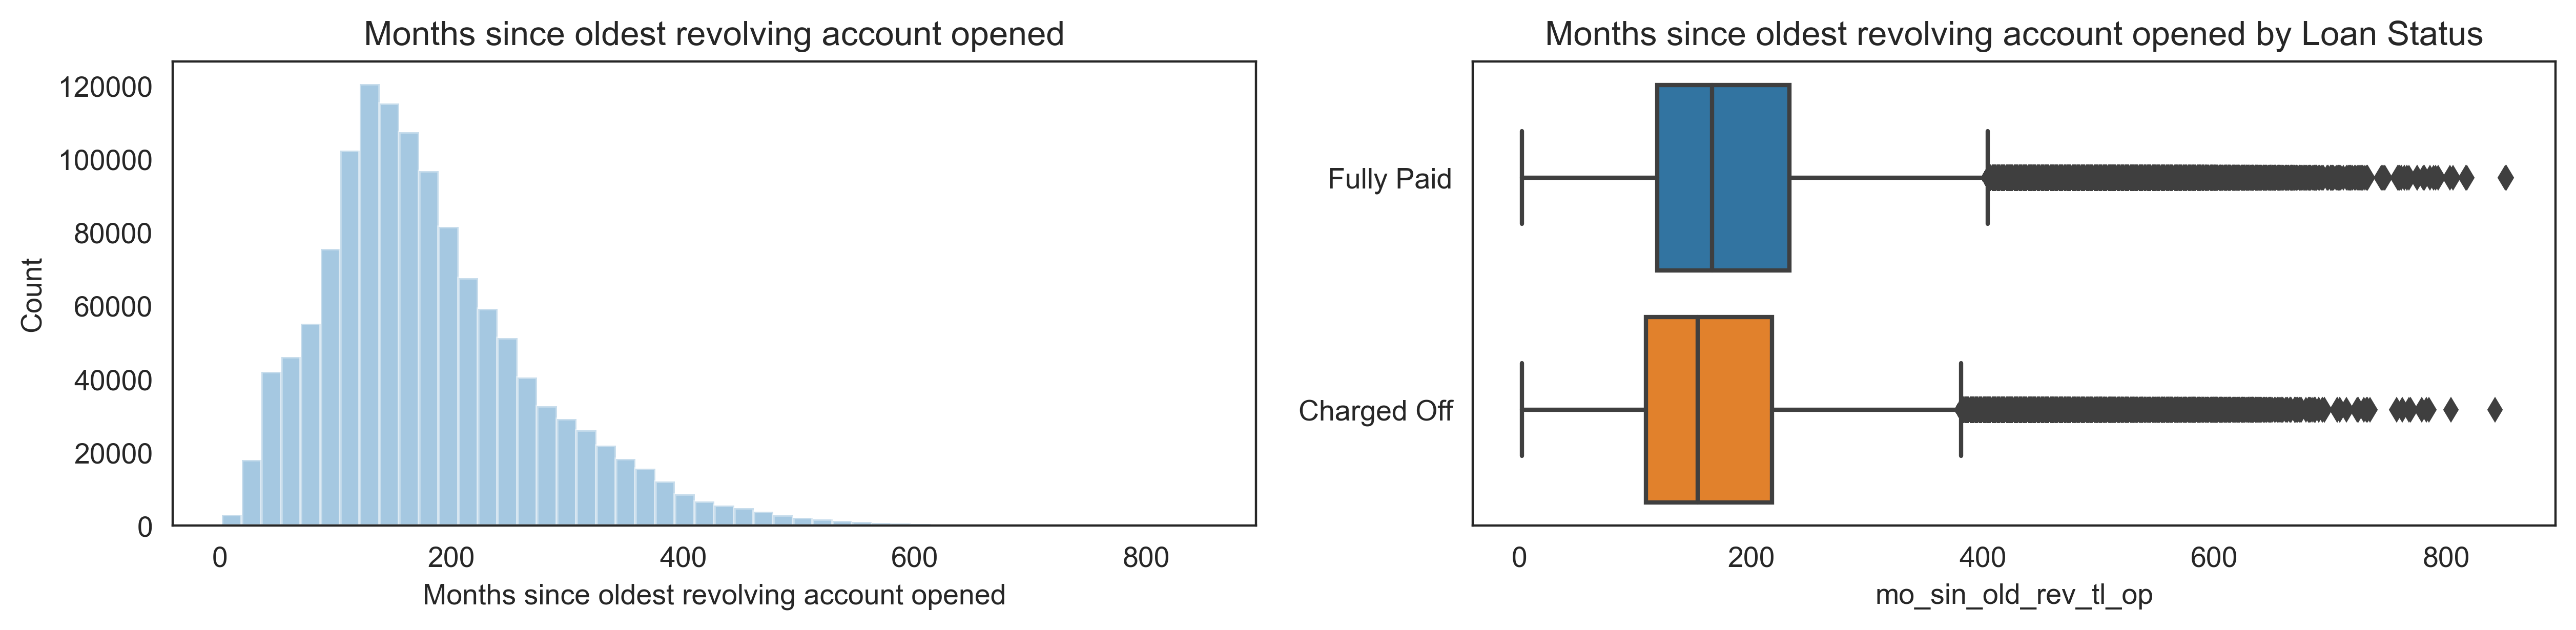

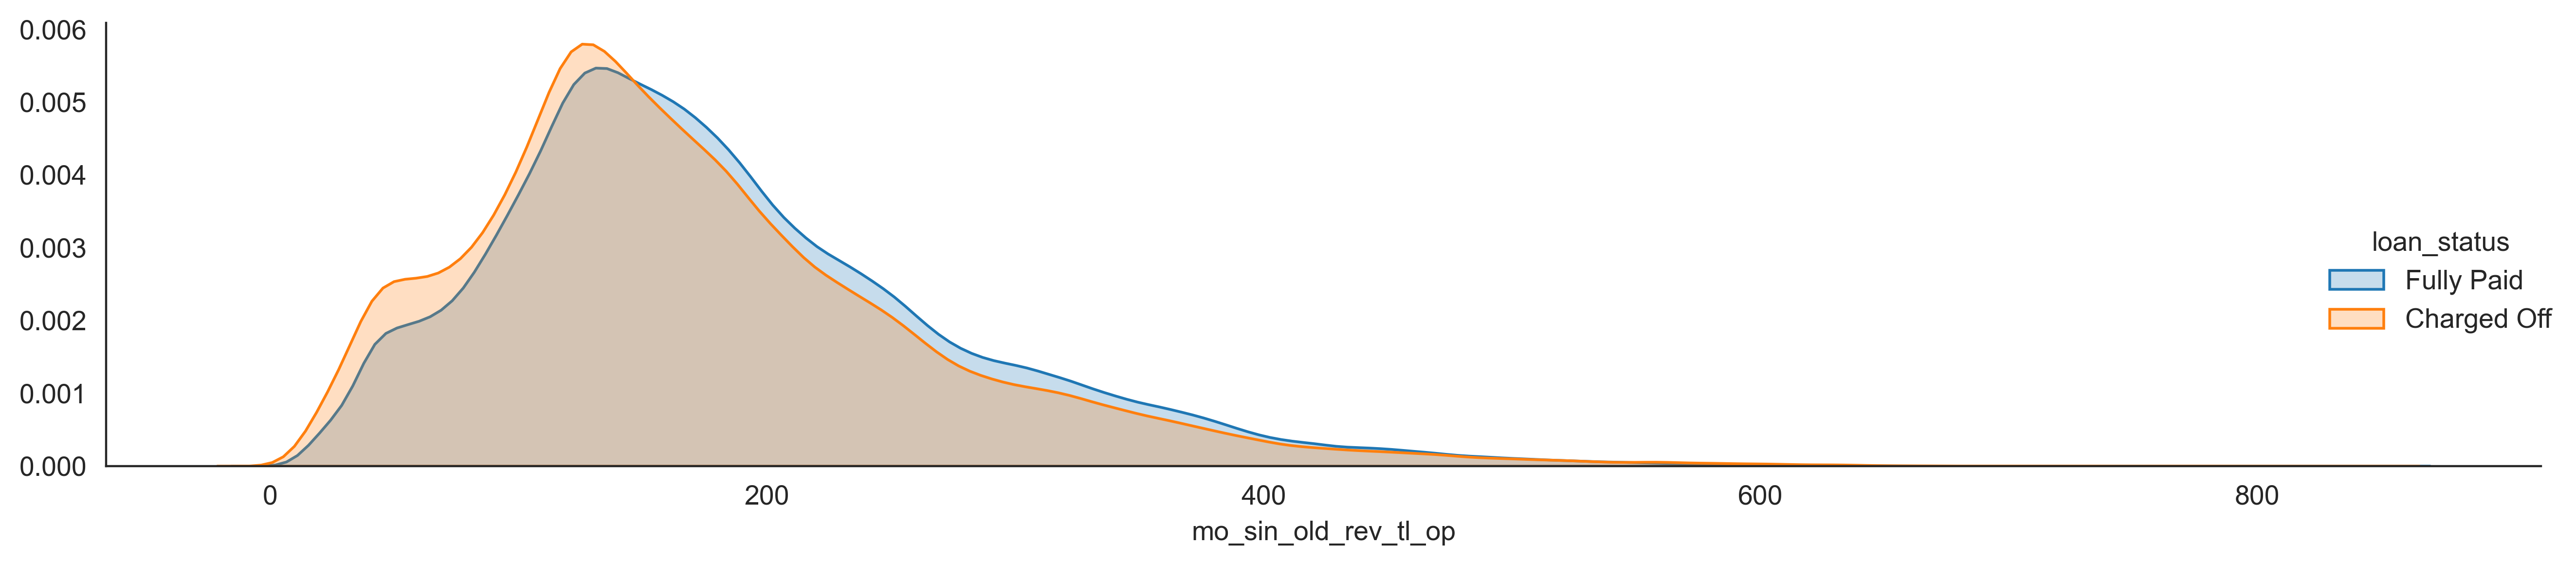

In [114]:
plot_func('mo_sin_old_rev_tl_op', 'Months since oldest revolving account opened', continuous=True)

#### 25. Number of mortgage accounts

In [115]:
df['mort_acc'].value_counts()

0.00     523837
1.00     226135
2.00     188941
3.00     139381
4.00      94920
5.00      57632
6.00      32539
7.00      16850
8.00       8378
9.00       4285
10.00      2197
11.00      1206
12.00       640
13.00       356
14.00       244
15.00       132
16.00        93
17.00        61
18.00        48
19.00        29
20.00        25
24.00        16
21.00        14
22.00        14
23.00        10
25.00         9
27.00         8
26.00         6
28.00         4
29.00         4
34.00         3
30.00         2
32.00         2
37.00         2
31.00         2
51.00         1
47.00         1
36.00         1
35.00         1
Name: mort_acc, dtype: int64

In [116]:
df.mort_acc = df.mort_acc.map(lambda x: 6.0 if x > 6.0 else x)

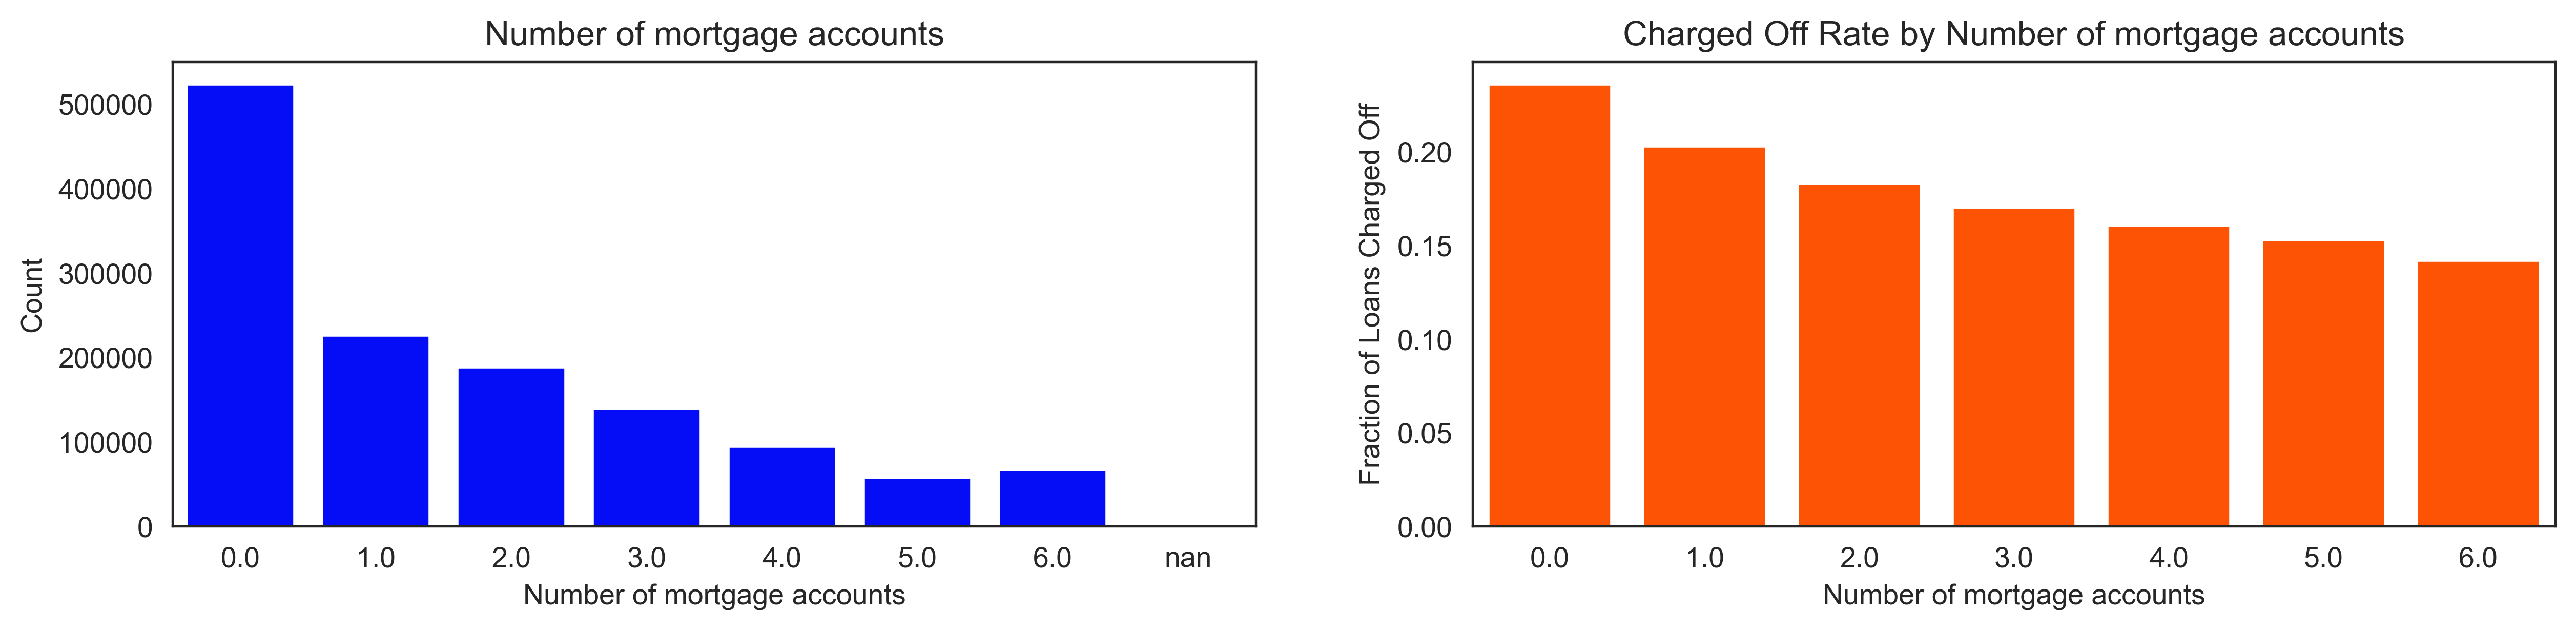

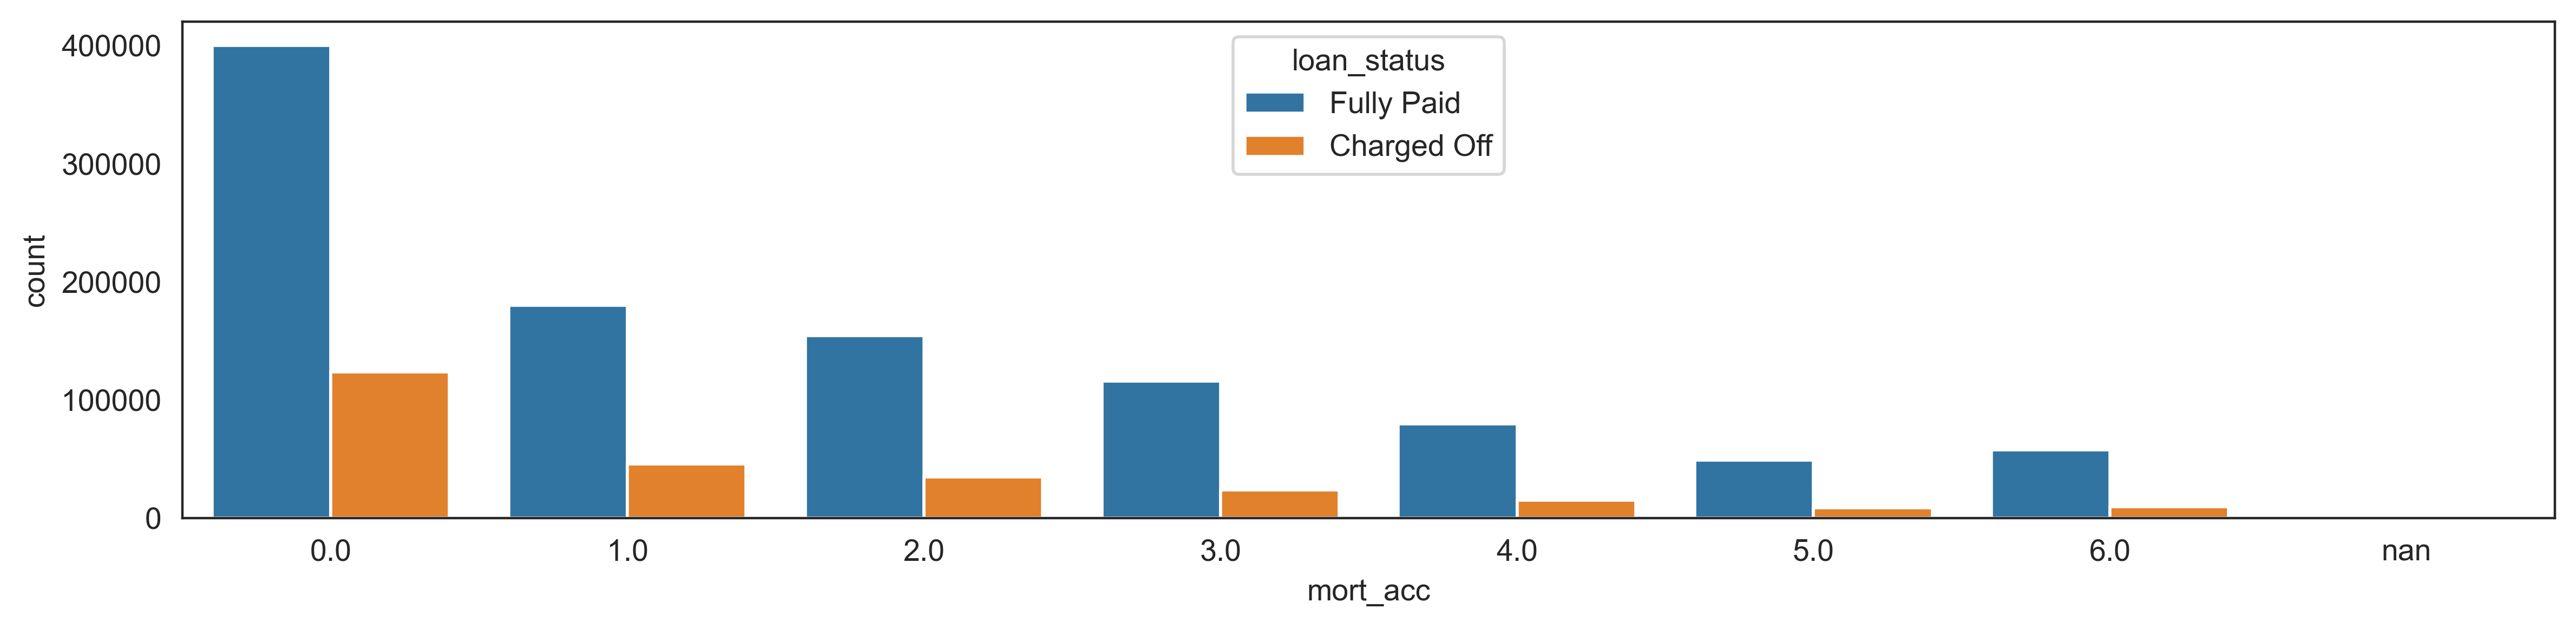

In [117]:
plot_func('mort_acc', 'Number of mortgage accounts', continuous=False)

Loans with higher number of mortgage accounts have lower charge off rate

## 5. Feature Selection - Statistical Overview

In [118]:
df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})
drop_cols('loan_status')

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 27 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1345310 non-null  float64
 1   term                  1345310 non-null  int64  
 2   int_rate              1345310 non-null  float64
 3   installment           1345310 non-null  float64
 4   sub_grade             1345310 non-null  object 
 5   emp_length            1266799 non-null  float64
 6   home_ownership        1345310 non-null  object 
 7   annual_inc            1345310 non-null  float64
 8   verification_status   1345310 non-null  object 
 9   issue_d               1345310 non-null  object 
 10  purpose               1345310 non-null  object 
 11  addr_state            1345310 non-null  object 
 12  dti                   1344936 non-null  float64
 13  open_acc              1345310 non-null  float64
 14  pub_rec               1345310 non-

In [120]:
list_float = df.select_dtypes(exclude=['object']).columns

In [121]:
list_float

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc',
       'pub_rec_bankruptcies', 'earliest_cr_year', 'fico_score',
       'loan_repaid'],
      dtype='object')

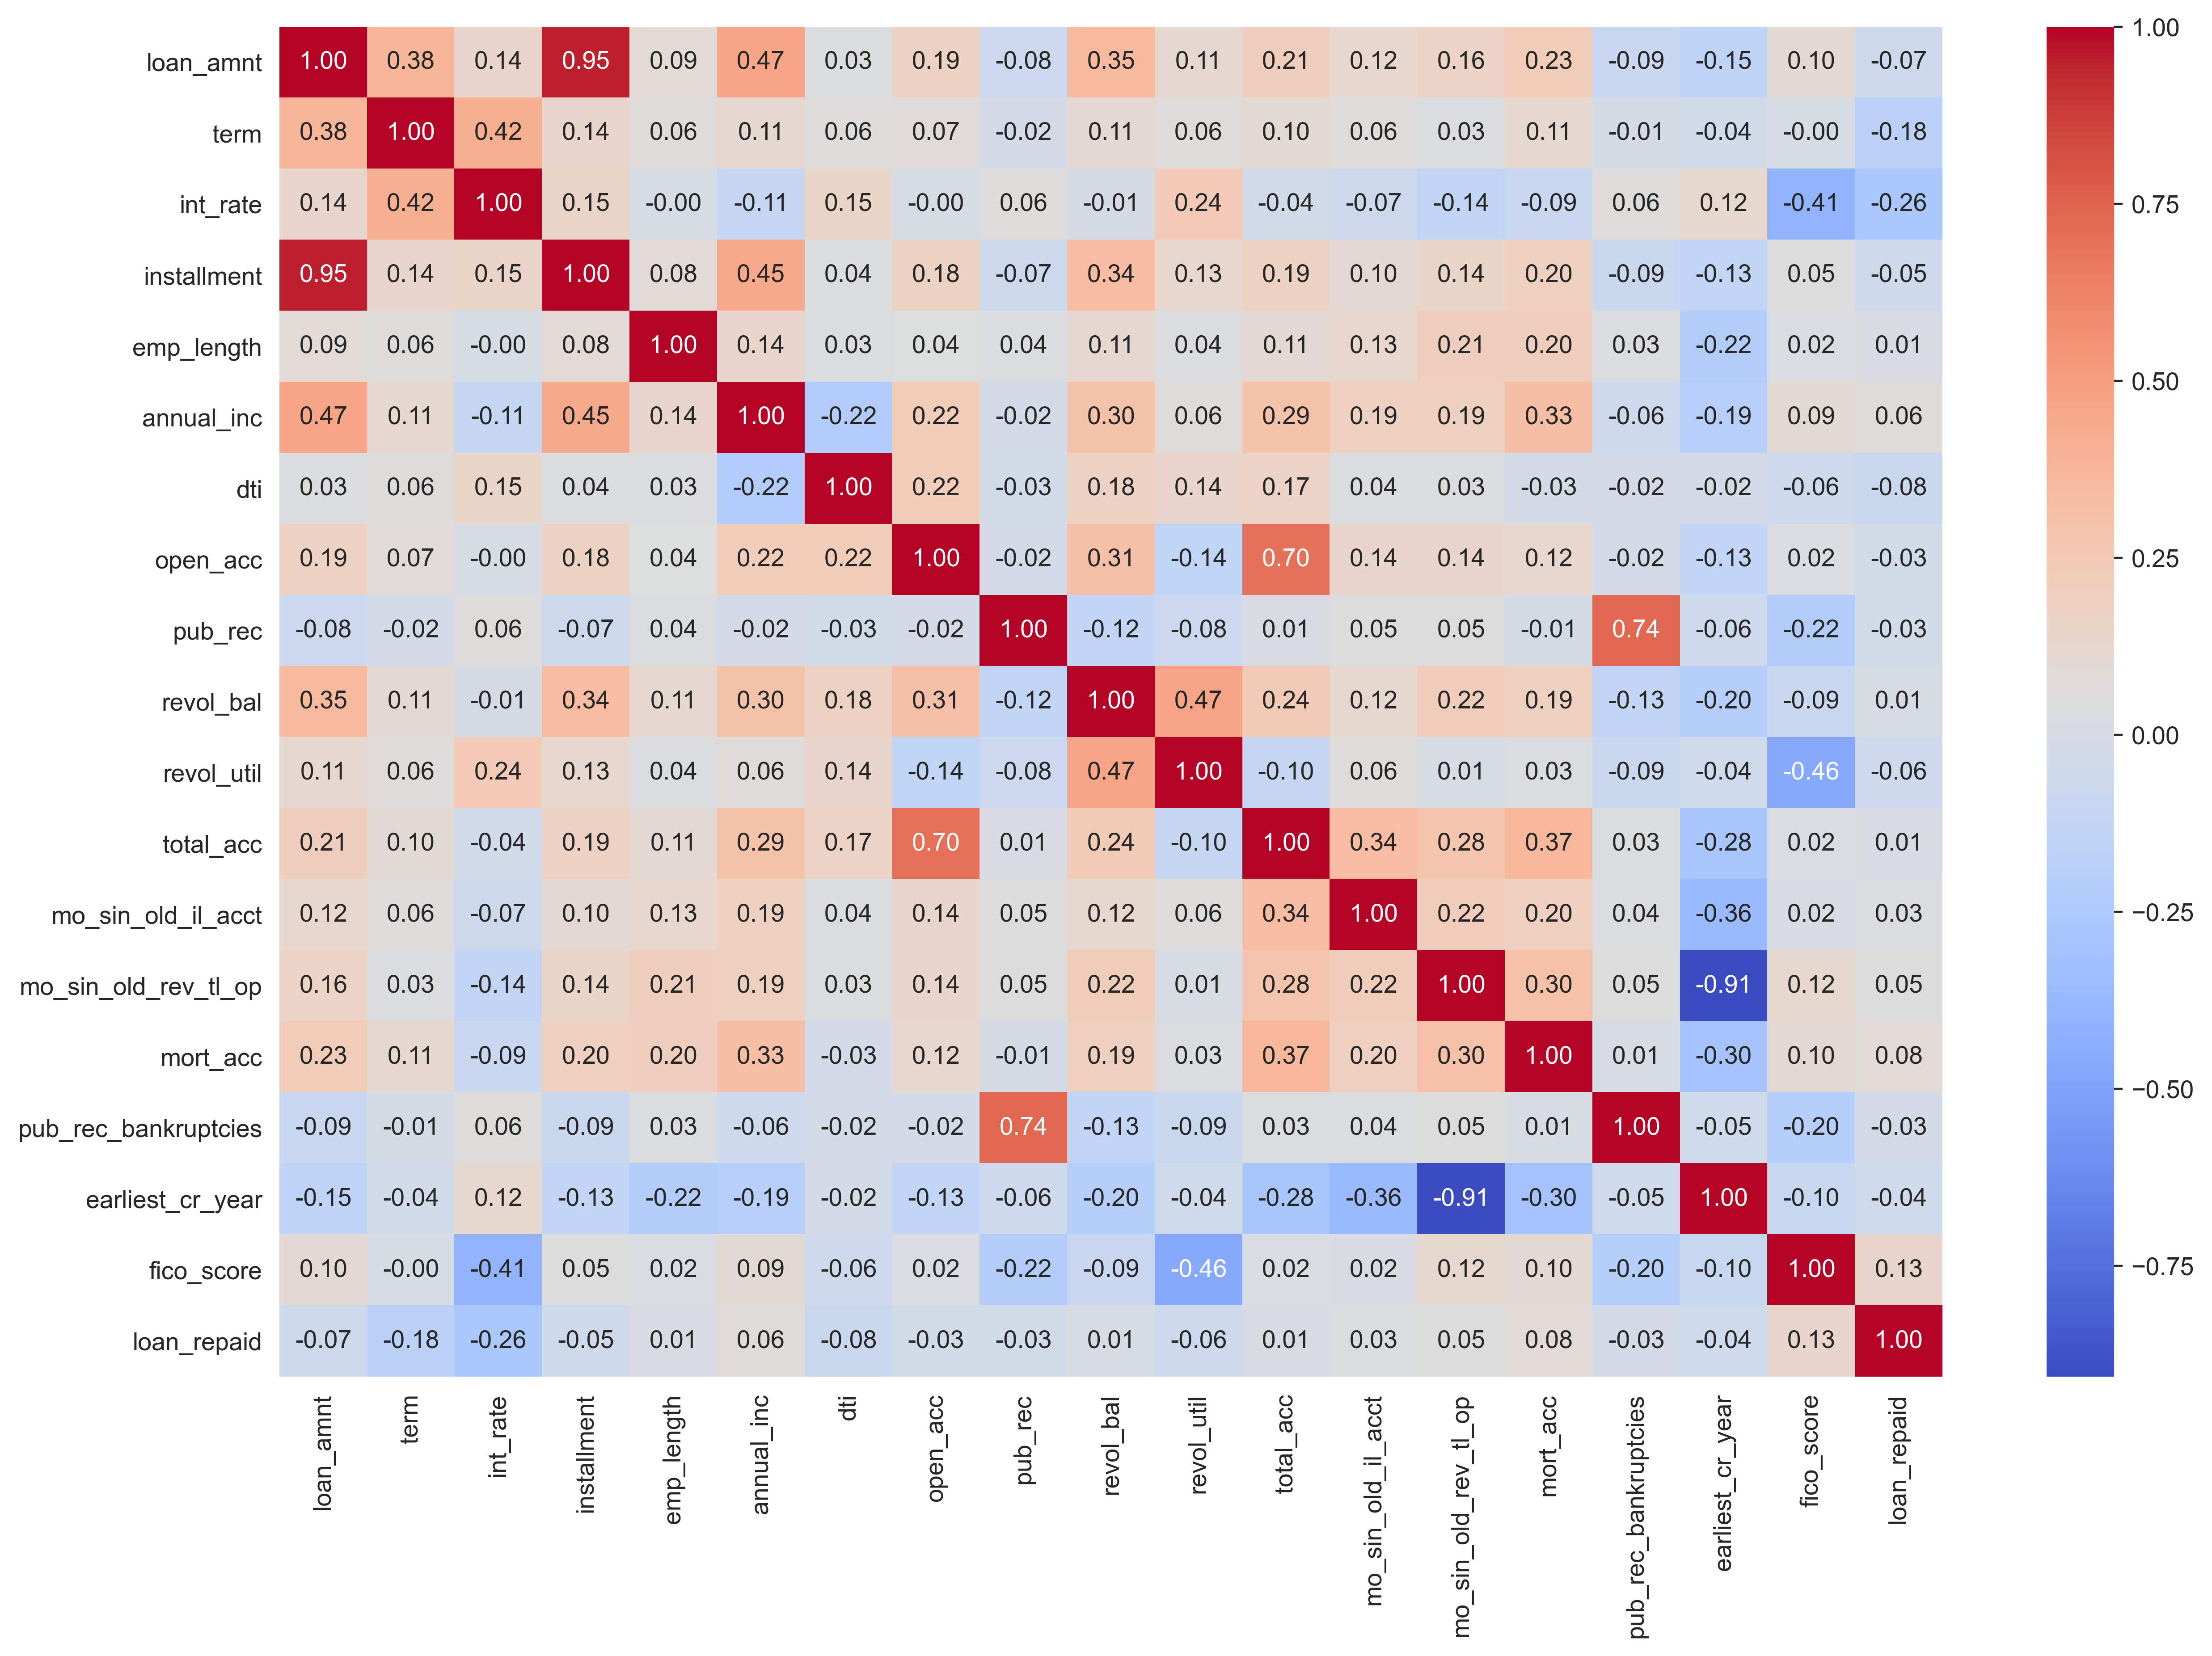

In [122]:
fig, ax = plt.subplots(figsize=(15,10))         
cm_df = sns.heatmap(df[list_float].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

The linearly correlated features are:

- "installment" vs "loan_amnt" (0.95)
- "mo_sin_old_rev_tl_op"* vs "earliest_cr_year" (0.91)
- "pub_rec_bankruptcies"* vs "pub_rec" (0.74)
- "total_acc" vs "open_acc" (0.70)

*** Dependence of Charged-off on the predictors: "int_rate" is the most correlated one.

In [123]:
cor = df[list_float].corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.1) | (cor < -0.1)]

term                  loan_amnt               0.38
int_rate              loan_amnt               0.14
                      term                    0.42
installment           loan_amnt               0.95
                      term                    0.14
                      int_rate                0.15
annual_inc            loan_amnt               0.47
                      term                    0.11
                      int_rate               -0.11
                      installment             0.45
                      emp_length              0.14
dti                   int_rate                0.15
                      annual_inc             -0.22
open_acc              loan_amnt               0.19
                      installment             0.18
                      annual_inc              0.22
                      dti                     0.22
revol_bal             loan_amnt               0.35
                      term                    0.11
                      installme

In [124]:
linear_corr = pd.DataFrame()

In [129]:
# Pearson coefficients
for col in df[list_float].columns:
    linear_corr.loc[col, 'pearson_corr'] = df[col].corr(df['loan_repaid'])
linear_corr['abs_pearson_corr'] = abs(linear_corr['pearson_corr'])

In [130]:
linear_corr.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_corr.drop('abs_pearson_corr', axis=1, inplace=True)
linear_corr.drop('loan_repaid', axis=0, inplace=True)

In [131]:
linear_corr.reset_index(inplace=True)
linear_corr

index  pearson_corr
0               int_rate         -0.26
1                   term         -0.18
2             fico_score          0.13
3                    dti         -0.08
4               mort_acc          0.08
5              loan_amnt         -0.07
6             annual_inc          0.06
7             revol_util         -0.06
8            installment         -0.05
9   mo_sin_old_rev_tl_op          0.05
10      earliest_cr_year         -0.04
11               pub_rec         -0.03
12              open_acc         -0.03
13    mo_sin_old_il_acct          0.03
14  pub_rec_bankruptcies         -0.03
15            emp_length          0.01
16             total_acc          0.01
17             revol_bal          0.01

The variables most linearly correlated with our target variable are interest rate, loan term, Fico Score and debt-to-income ratio. The least correlated features are the revolving balance, employment length, and public record.

We can drop the highly correlated features

In [132]:
list_linear = ['installment', 'mo_sin_old_rev_tl_op','total_acc','pub_rec_bankruptcies']
drop_cols(list_linear)

In [133]:
df.shape

(1345310, 23)

# 6. Feature Engineering
We still have some more cleaning to do
- One-Hot Encoding

We wouldn't know beforehand whether or not a loan would be issued when using our model, so in theory we wouldn't have an issue_date, drop this feature.

In [134]:
drop_cols('issue_d')

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   loan_amnt            1345310 non-null  float64
 1   term                 1345310 non-null  int64  
 2   int_rate             1345310 non-null  float64
 3   sub_grade            1345310 non-null  object 
 4   emp_length           1266799 non-null  float64
 5   home_ownership       1345310 non-null  object 
 6   annual_inc           1345310 non-null  float64
 7   verification_status  1345310 non-null  object 
 8   purpose              1345310 non-null  object 
 9   addr_state           1345310 non-null  object 
 10  dti                  1344936 non-null  float64
 11  open_acc             1345310 non-null  float64
 12  pub_rec              1345310 non-null  float64
 13  revol_bal            1345310 non-null  float64
 14  revol_util           1344453 non-null  float64
 15

In [137]:
dummy_list =['sub_grade','home_ownership','verification_status','purpose','addr_state','initial_list_status','application_type']

In [138]:
df = pd.get_dummies(df, columns=dummy_list, drop_first=True)

In [139]:
df.shape

(1345310, 119)

In [142]:
df.sample(1)

loan_amnt  term  int_rate  emp_length  annual_inc  dti  open_acc  \
1635846   20000.00    60      6.91        3.00        5.27 4.44      9.00   

         pub_rec  revol_bal  revol_util  mo_sin_old_il_acct  mort_acc  \
1635846     0.00       4.83       26.30                 nan       nan   

         earliest_cr_year  fico_score  loan_repaid  sub_grade_A2  \
1635846              1991      767.00            1             0   

         sub_grade_A3  sub_grade_A4  sub_grade_A5  sub_grade_B1  sub_grade_B2  \
1635846             0             0             1             0             0   

         sub_grade_B3  sub_grade_B4  sub_grade_B5  sub_grade_C1  sub_grade_C2  \
1635846             0             0             0             0             0   

         sub_grade_C3  sub_grade_C4  sub_grade_C5  sub_grade_D1  sub_grade_D2  \
1635846             0             0             0             0             0   

         sub_grade_D3  sub_grade_D4  sub_grade_D5  sub_grade_E1  sub_grade_E2  \
1635846             0             0             0             0             0   

         sub_grade_E3  sub_grade_E4  sub_grade_E5  sub_grade_F1  sub_grade_F2  \
1635846             0             0             0             0             0   

         sub_grade_F3  sub_grade_F4  sub_grade_F5  sub_grade_G1  sub_grade_G2  \
1635846             0             0             0             0             0   

         sub_grade_G3  sub_grade_G4  sub_grade_G5  home_ownership_OTHER  \
1635846             0             0             0                     0   

         home_ownership_OWN  home_ownership_RENT  \
1635846                   0                    0   

         verification_status_Source Verified  verification_status_Verified  \
1635846                                    0                             1   

         purpose_credit_card  purpose_debt_consolidation  purpose_educational  \
1635846                    0                           0                    0   

         purpose_home_improvement  purpose_house  purpose_major_purchase  \
1635846                         1              0                       0   

         purpose_medical  purpose_moving  purpose_other  \
1635846                0               0              0   

         purpose_renewable_energy  purpose_small_business  purpose_vacation  \
1635846                         0                       0                 0   

         purpose_wedding  addr_state_AL  addr_state_AR  addr_state_AZ  \
1635846                0              0              0              0   

         addr_state_CA  addr_state_CO  addr_state_CT  addr_state_DC  \
1635846              1              0              0              0   

         addr_state_DE  addr_state_FL  addr_state_GA  addr_state_HI  \
1635846              0              0              0              0   

         addr_state_IA  addr_state_ID  addr_state_IL  addr_state_IN  \
1635846              0              0              0              0   

         addr_state_KS  addr_state_KY  addr_state_LA  addr_state_MA  \
1635846              0              0              0              0   

         addr_state_MD  addr_state_ME  addr_state_MI  addr_state_MN  \
1635846              0              0              0              0   

         addr_state_MO  addr_state_MS  addr_state_MT  addr_state_NC  \
1635846              0              0              0              0   

         addr_state_ND  addr_state_NE  addr_state_NH  addr_state_NJ  \
1635846              0              0              0              0   

         addr_state_NM  addr_state_NV  addr_state_NY  addr_state_OH  \
1635846              0              0              0              0   

         addr_state_OK  addr_state_OR  addr_state_PA  addr_state_RI  \
1635846              0              0              0              0   

         addr_state_SC  addr_state_SD  addr_state_TN  addr_state_TX  \
1635846              0              0              0              0   

        

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Columns: 119 entries, loan_amnt to application_type_Joint App
dtypes: float64(12), int64(3), uint8(104)
memory usage: 337.7 MB


In [145]:
df.to_csv('output/LC_Final.csv.gz', compression='gzip')